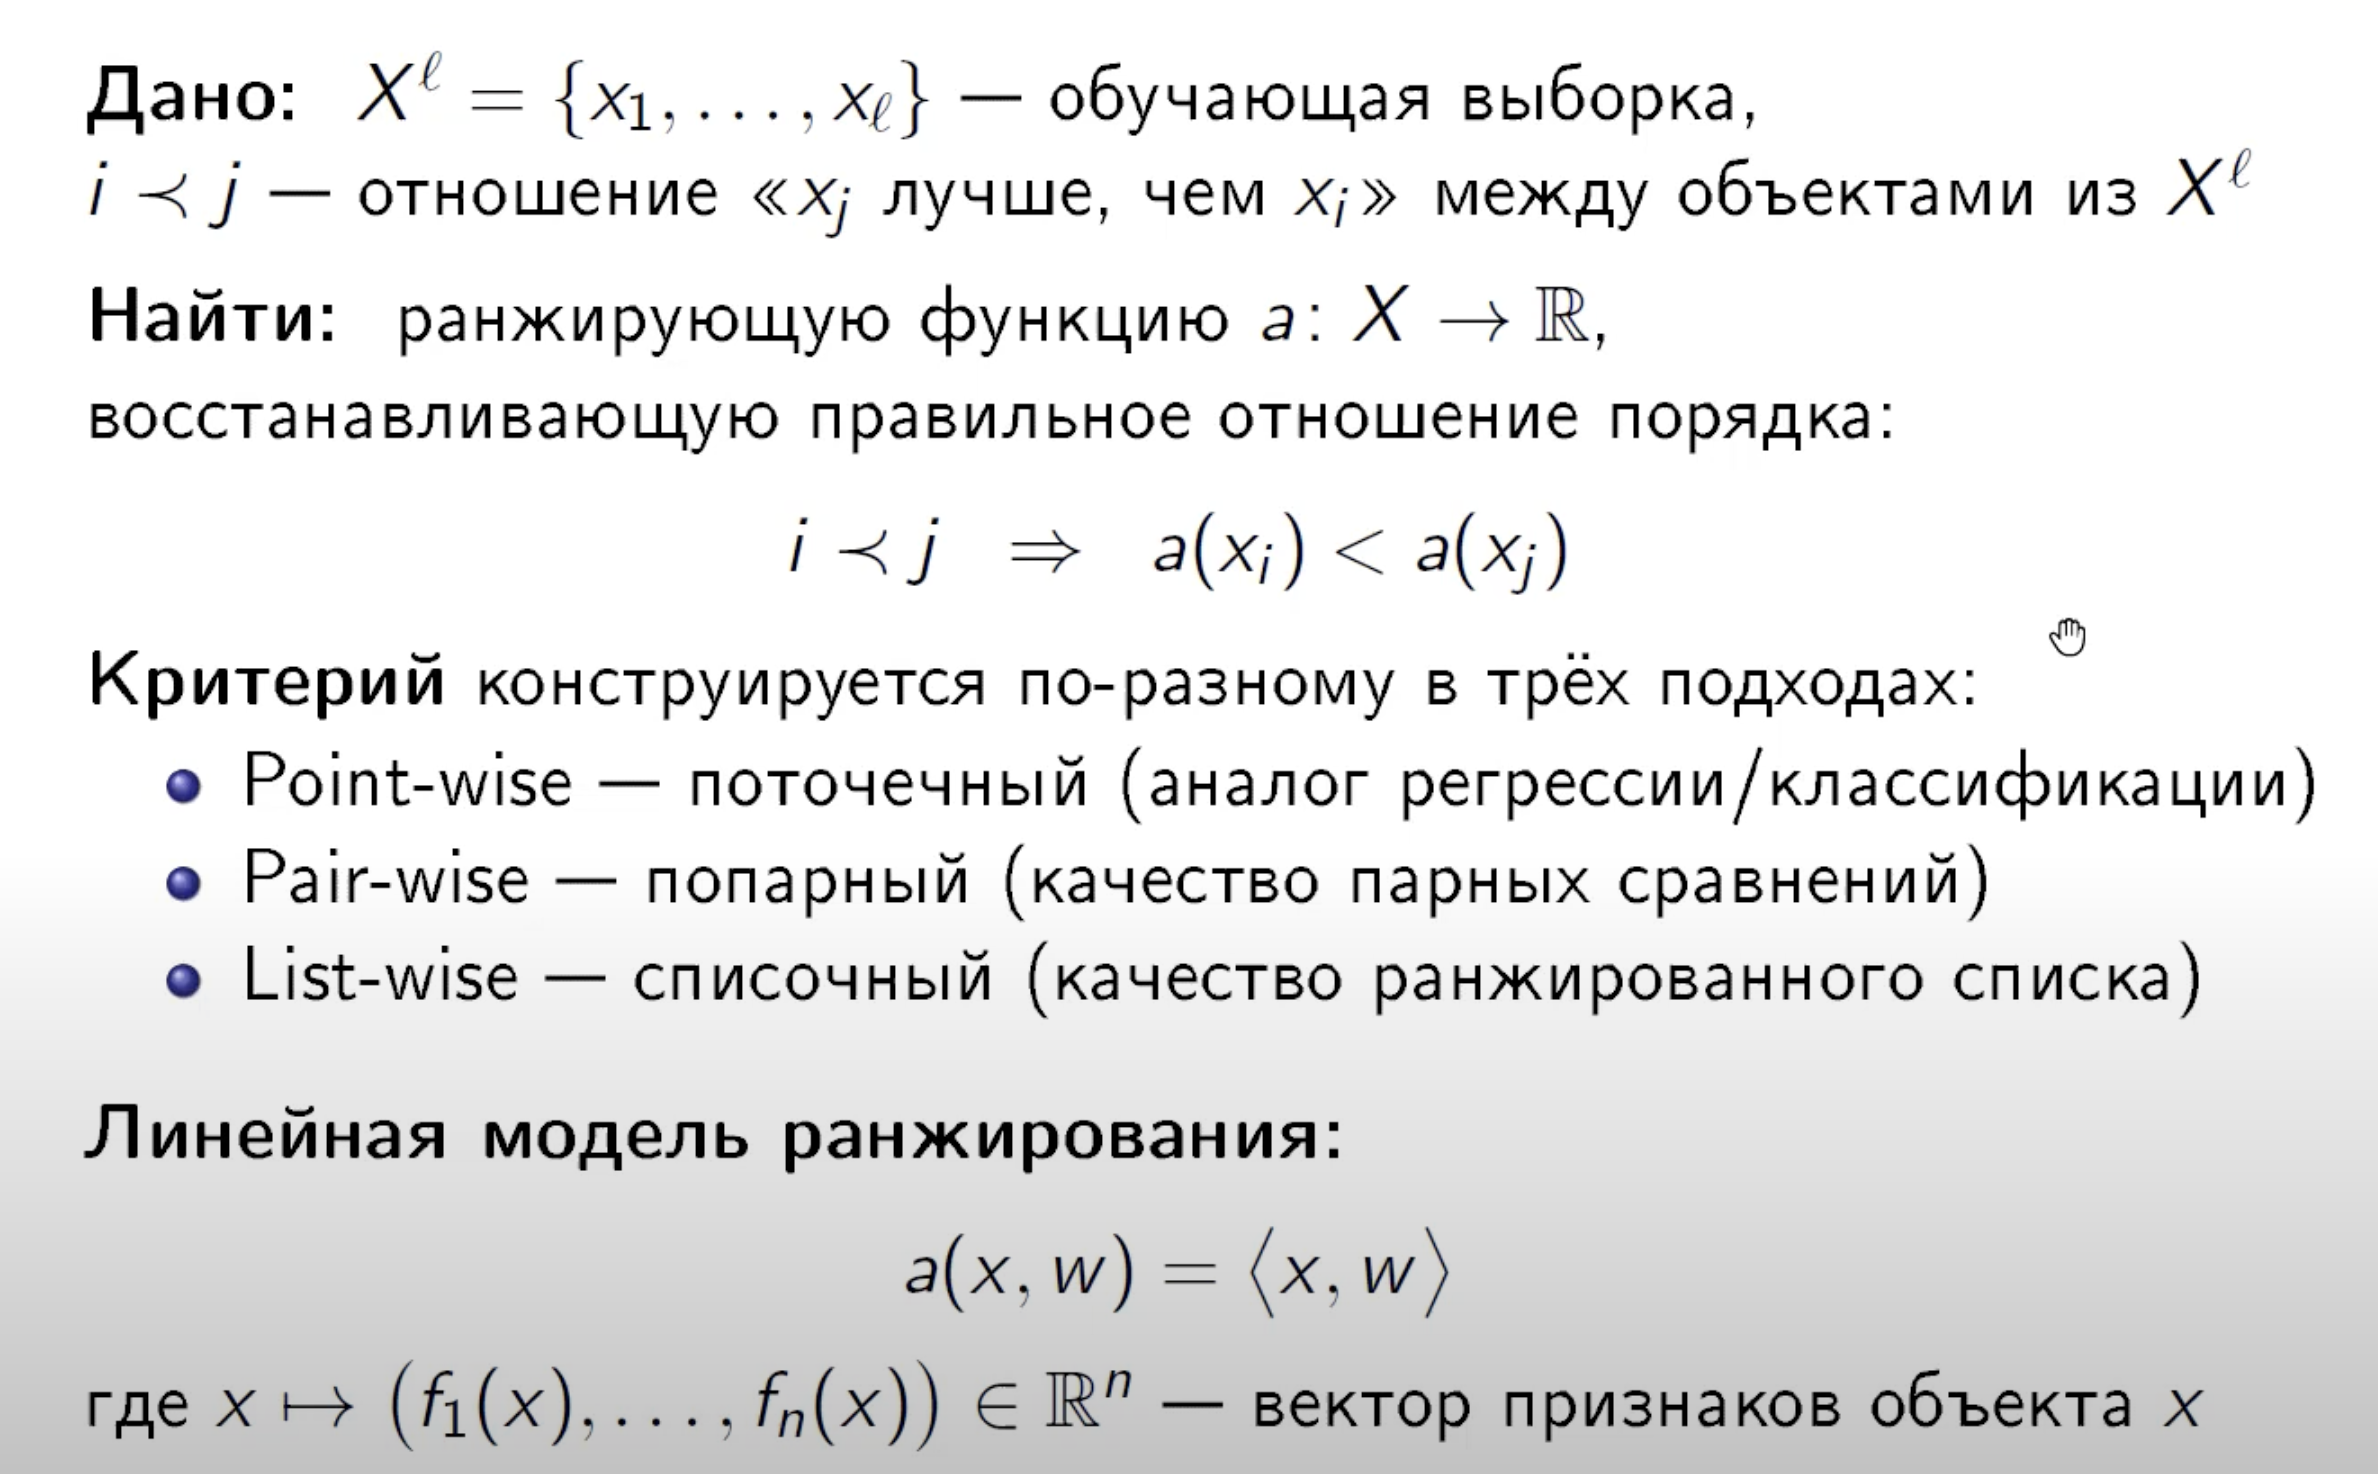

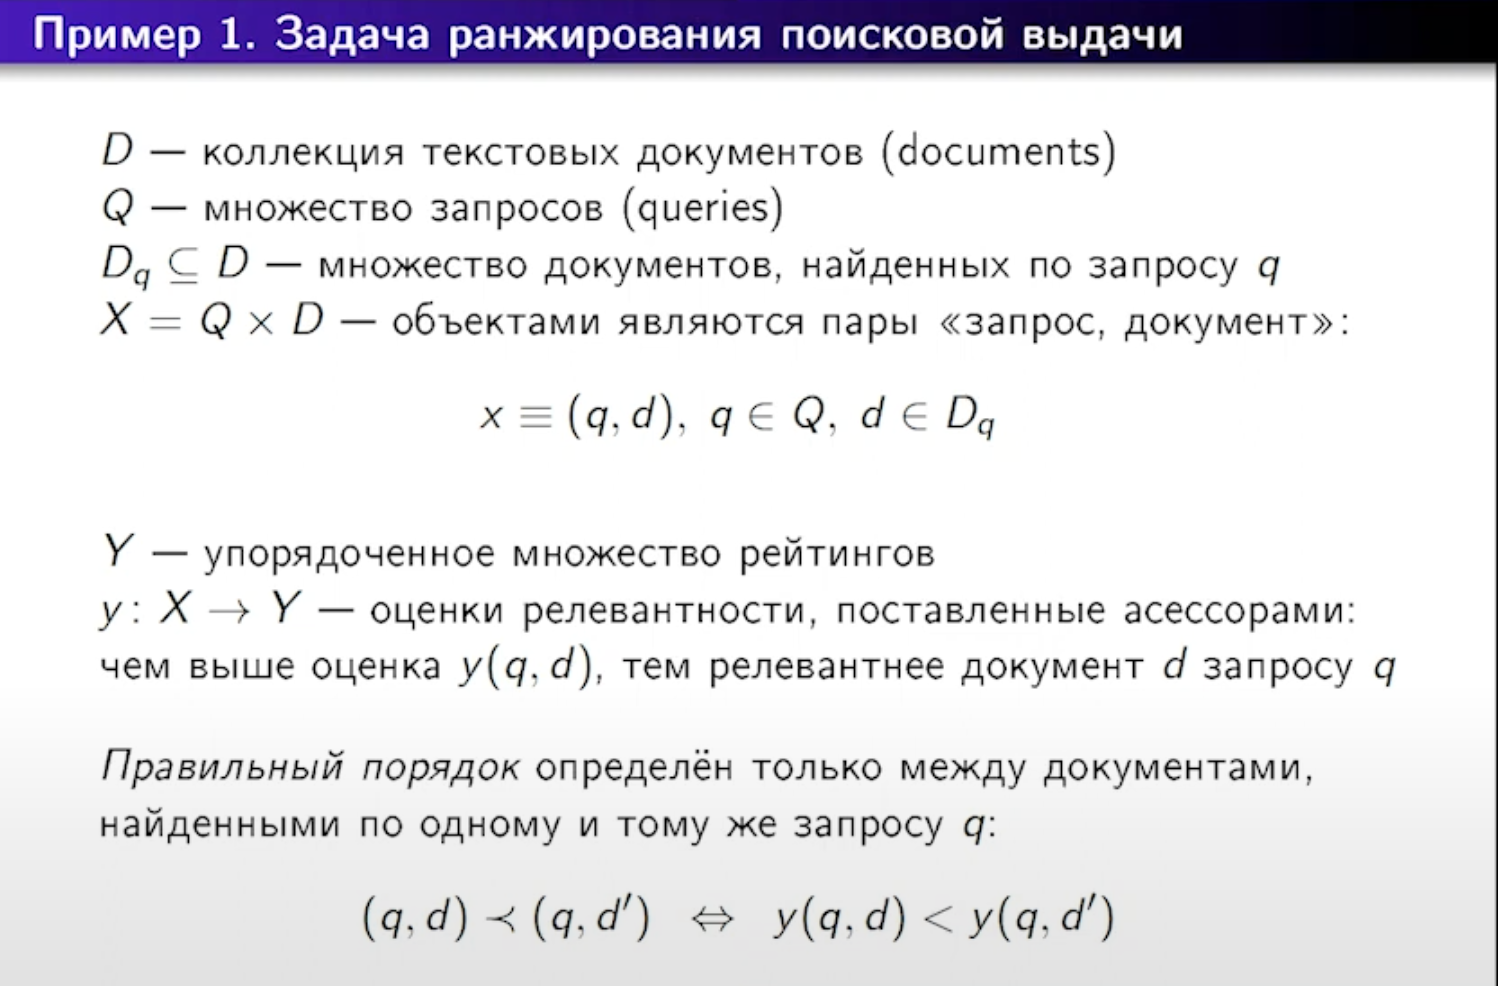

# Load Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm

In [ ]:
columns = ['relevance', 'query_id'] + [f"feature{i}" for i in range(1,137)]
train_df = pd.read_csv("/content/drive/MyDrive/MSLR-WEB10L-fold1/train.txt", sep=" ", index_col=False, names=columns, nrows=30000)
test_df = pd.read_csv("/content/drive/MyDrive/MSLR-WEB10L-fold1/test.txt", sep=" ", index_col=False, names=columns, nrows=7500)

In [ ]:
train_df.iloc[:,1:] = train_df.iloc[:,1:].applymap(lambda x: x.split(':')[1])
test_df.iloc[:,1:] = test_df.iloc[:,1:].applymap(lambda x: x.split(':')[1])

In [ ]:
train_df['relevance'].value_counts()

0    17335
1     8460
2     3677
3      370
4      158
Name: relevance, dtype: int64

# Попарные методы
Вспомним, что изначально мы определяли задачу ранжирования через пары объектов. Если записывать это формально, то получим функционал ошибки
$$ \sum_{(i,j )∈R}{[a(x_j)−a(x_i)<0]} $$
где R — множество пар, для которых известен порядок. Этот функционал не является дифференцируемым, но мы уже решали такую проблему в линейной классификации — надо заменить индикатор ошибки [z < 0] на его гладкую верхнюю оценку L(z):
$$ \sum_{(i,j )∈R} {[a(xj)−a(xi)<0]} <= \sum_{(i,j )∈R} {L(a(x_j)−a(x_i))} $$
В качестве оценки L(z) можно брать, например, логистическую функцию
$$ L(x) = log(1+e^{−σz} ) $$
с параметром σ > 0 — в этом случае получим метод RankNet. Оптимизировать данный функционал можно обычным стохастическим градиентным спуском. Если использовать линейную модель a(x) = ⟨w, x⟩, то один шаг будет иметь вид
$$ w:=w + η\frac {σ} {1+exp(σ⟨x_j − x_i,w⟩)}(x_j −x_i) $$

## Сгенерируем пары

In [ ]:
# предположим, что на один запрос не может быть показано два одинаковых документа
train_df['doc_hash'] = train_df.iloc[:,2:].apply(lambda x: hash(tuple(x)), axis=1)

In [ ]:
def generate_pairs(doc_query_rel_df):
  pairs_df = pd.merge(doc_query_rel_df, doc_query_rel_df, on='query_id')
  return pairs_df[pairs_df['relevance_x'] > pairs_df['relevance_y']]

In [ ]:
pairs_df = shuffle(generate_pairs(train_df[['doc_hash','query_id', 'relevance']]))

## Логистическая регрессия с PairLogit лоссом
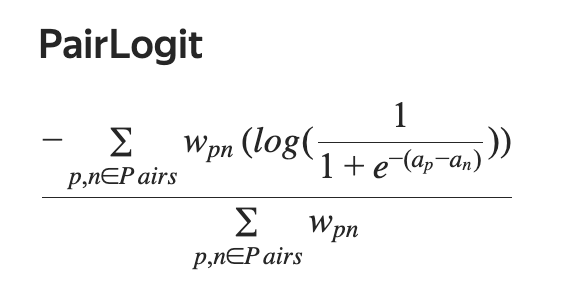

1. В обучении используем PairLogit лосс
2. В процессе обучения подаём пары документов p,n по батчам (должен получаться батч размера (N,2,d),

где
N - размер батча,
d - длина вектора признаков)

In [ ]:
def batch_sampler(batch_size, train_df, pairs_df):
  for i in tqdm(range(len(pairs_df)//batch_size), bar_format='Batch sampler {l_bar}{bar}{r_bar}'):
      batch = pairs_df[i*batch_size:(i+1)*batch_size]
      batch = batch.merge(train_df.iloc[:,1:].rename(columns={'doc_hash':'doc_hash_x'}), on=['doc_hash_x', 'query_id'])
      batch = batch.merge(train_df.iloc[:,1:].rename(columns={'doc_hash':'doc_hash_y'}), on=['doc_hash_y', 'query_id']).drop_duplicates()
      batch_x = batch.iloc[:,5:]
      yield (np.stack((batch_x.iloc[:,:136].to_numpy(), batch_x.iloc[:,136:].to_numpy()), axis=1).astype(float),
            np.stack((batch['relevance_x'].to_numpy(), batch['relevance_y'].to_numpy()), axis=1).astype(int))

In [ ]:
batch_x, batch_y= batch_sampler(6,train_df,pairs_df).__next__()

Batch sampler   0%|          | 0/183752 [00:00<?, ?it/s]


Шаг градиентного спуска для линейной модели с PairLogit лоссом

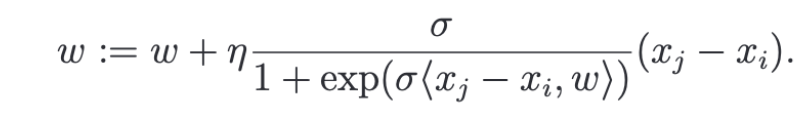

In [ ]:
class RankNet:
  def __init__(self, features_cnt):
    self.weights = np.random.normal(size=features_cnt)

  def batch_norm(self, features):
    return (features - np.mean(features, axis=(0,1))) / np.std(features, axis=(0,1))

  def pair_logit_loss(self, batch_x, batch_y):
    positive_sample = np.dot(batch_x[:,0,:], self.weights)
    negative_sample = np.dot(batch_x[:,1,:], self.weights)
    pair_weights = batch_y[:,0] - batch_y[:,1]
    return np.sum(np.multiply(pair_weights, np.log(1 + np.exp(-1*(positive_sample - negative_sample))))) / np.sum(pair_weights)

  def fit(self, train_df, pairs_df, batch_size, lr=0.02, logging_period = 100):
    step = 0
    for batch_x, batch_y in batch_sampler(batch_size, train_df, pairs_df):
       input = self.batch_norm(batch_x)

       if not (step % logging_period):
          tqdm.write(f'loss: {self.pair_logit_loss(input, batch_y)}')
       step += 1

       positive_sample = np.dot(input[:,0,:], self.weights)
       negative_sample = np.dot(input[:,1,:], self.weights)
       grad = -1 * np.dot(1/(1+np.exp(positive_sample - negative_sample)), (input[:,0,:] - input[:,1,:]))
       self.weights -= lr*grad

In [ ]:
rank_net = RankNet(136)

In [ ]:
rank_net.fit(train_df, pairs_df, 128)

Batch sampler   0%|          | 1/8613 [00:00<1:11:53,  2.00it/s]

loss: 4.468912252002595


Batch sampler   1%|          | 101/8613 [00:48<1:04:21,  2.20it/s]

loss: 3.0365372875123735


Batch sampler   2%|▏         | 201/8613 [01:36<1:18:05,  1.80it/s]

loss: 3.5621883736956


Batch sampler   3%|▎         | 301/8613 [02:24<1:06:28,  2.08it/s]

loss: 1.9828224768845315


Batch sampler   5%|▍         | 401/8613 [03:20<1:15:16,  1.82it/s]

loss: 4.596760821990263


Batch sampler   6%|▌         | 501/8613 [04:18<1:27:12,  1.55it/s]

loss: 2.5422894868124684


Batch sampler   7%|▋         | 601/8613 [05:09<1:09:34,  1.92it/s]

loss: 3.6266170033189566


Batch sampler   8%|▊         | 701/8613 [05:57<1:00:14,  2.19it/s]

loss: 6.0386429556724375


Batch sampler   9%|▉         | 801/8613 [06:47<1:01:22,  2.12it/s]

loss: 4.125370334225642


Batch sampler  10%|█         | 901/8613 [07:36<1:13:52,  1.74it/s]

loss: 4.88804000924388


Batch sampler  12%|█▏        | 1001/8613 [08:23<58:14,  2.18it/s]

loss: 5.439882476095316


Batch sampler  13%|█▎        | 1101/8613 [09:11<57:05,  2.19it/s]

loss: 3.667877023524641


Batch sampler  14%|█▍        | 1201/8613 [10:08<1:11:13,  1.73it/s]

loss: 3.3649681459927097


Batch sampler  15%|█▌        | 1301/8613 [10:59<56:01,  2.18it/s]

loss: 1.3193066772158775


Batch sampler  16%|█▋        | 1401/8613 [11:48<57:17,  2.10it/s]

loss: 2.4405197119963464


Batch sampler  17%|█▋        | 1501/8613 [12:35<57:34,  2.06it/s]

loss: 1.7357785822383265


Batch sampler  19%|█▊        | 1601/8613 [13:24<56:16,  2.08it/s]

loss: 5.277710678920773


Batch sampler  20%|█▉        | 1701/8613 [14:11<55:51,  2.06it/s]

loss: 5.495220313556906


Batch sampler  21%|██        | 1801/8613 [14:59<51:05,  2.22it/s]

loss: 7.230250289552332


Batch sampler  22%|██▏       | 1901/8613 [15:47<53:06,  2.11it/s]

loss: 6.605674410974194


Batch sampler  23%|██▎       | 2001/8613 [16:35<59:39,  1.85it/s]  

loss: 13.115530520603835


Batch sampler  24%|██▍       | 2101/8613 [17:22<51:07,  2.12it/s]

loss: 5.2159202109374005


Batch sampler  26%|██▌       | 2201/8613 [18:11<50:01,  2.14it/s]

loss: 5.5730884438658785


Batch sampler  27%|██▋       | 2301/8613 [18:59<55:06,  1.91it/s]

loss: 5.9985724801794165


Batch sampler  28%|██▊       | 2401/8613 [19:47<46:53,  2.21it/s]

loss: 6.225029236287161


Batch sampler  28%|██▊       | 2424/8613 [19:59<51:01,  2.02it/s]


KeyboardInterrupt: 

## RankNet based Neural Network

In [ ]:
from torch import nn, optim
import torch

In [ ]:
class RankNetTorch(nn.Module):
    def __init__(self, num_features):
        super(RankNetTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    # Функция для вычисления сигмоиды от разности двух счетов
    def forward(self, x):
        positive_samples = self.model(x[:,0,:])
        negative_samples = self.model(x[:,1,:])
        return torch.sigmoid(positive_samples - negative_samples)


In [ ]:
model = RankNetTorch(136)

In [ ]:
def train(train_df, pairs_df, batch_size):

  model = RankNetTorch(136)
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  for batch_x, batch_y in batch_sampler(batch_size, train_df, pairs_df):
      input = torch.FloatTensor(batch_x)
      target = torch.LongTensor(batch_y)

      model.train()
      optimizer.zero_grad()

      output = model(input)
      loss = -torch.mean(torch.log(output))

      loss.backward()
      optimizer.step()
      print("Loss:", loss.item())



In [ ]:
train(train_df, pairs_df, 128)

Batch sampler   0%|          | 1/8613 [00:00<1:03:19,  2.27it/s]

Loss: 0.7445658445358276


Batch sampler   0%|          | 2/8613 [00:00<1:04:47,  2.21it/s]

Loss: 0.6529988050460815


Batch sampler   0%|          | 3/8613 [00:01<1:04:37,  2.22it/s]

Loss: 0.4933610260486603


Batch sampler   0%|          | 4/8613 [00:01<1:04:49,  2.21it/s]

Loss: 0.8749328255653381


Batch sampler   0%|          | 5/8613 [00:02<1:06:51,  2.15it/s]

Loss: 0.6628748774528503


Batch sampler   0%|          | 6/8613 [00:02<1:10:08,  2.04it/s]

Loss: 1.3048735857009888


Batch sampler   0%|          | 7/8613 [00:03<1:12:31,  1.98it/s]

Loss: 0.5102641582489014


Batch sampler   0%|          | 8/8613 [00:03<1:14:17,  1.93it/s]

Loss: 0.8043392896652222


Batch sampler   0%|          | 9/8613 [00:04<1:14:51,  1.92it/s]

Loss: 1.214471697807312


Batch sampler   0%|          | 10/8613 [00:05<1:17:02,  1.86it/s]

Loss: 0.5202983617782593


Batch sampler   0%|          | 11/8613 [00:05<1:14:10,  1.93it/s]

Loss: 0.9177946448326111


Batch sampler   0%|          | 12/8613 [00:06<1:22:23,  1.74it/s]

Loss: 0.7894622087478638


Batch sampler   0%|          | 13/8613 [00:06<1:16:59,  1.86it/s]

Loss: 0.8244501948356628


Batch sampler   0%|          | 14/8613 [00:07<1:13:02,  1.96it/s]

Loss: 0.9186795949935913


Batch sampler   0%|          | 15/8613 [00:07<1:10:32,  2.03it/s]

Loss: 0.5919598937034607


Batch sampler   0%|          | 16/8613 [00:07<1:08:34,  2.09it/s]

Loss: 0.6650038957595825


Batch sampler   0%|          | 17/8613 [00:08<1:07:06,  2.13it/s]

Loss: 0.8276476860046387


Batch sampler   0%|          | 18/8613 [00:08<1:06:07,  2.17it/s]

Loss: 0.713784396648407


Batch sampler   0%|          | 19/8613 [00:09<1:05:40,  2.18it/s]

Loss: 0.6106667518615723


Batch sampler   0%|          | 20/8613 [00:09<1:05:17,  2.19it/s]

Loss: 0.7248123288154602


Batch sampler   0%|          | 21/8613 [00:10<1:05:10,  2.20it/s]

Loss: 0.7403883337974548


Batch sampler   0%|          | 22/8613 [00:10<1:04:49,  2.21it/s]

Loss: 0.763945996761322


Batch sampler   0%|          | 23/8613 [00:11<1:04:28,  2.22it/s]

Loss: 0.6934884190559387


Batch sampler   0%|          | 24/8613 [00:11<1:04:26,  2.22it/s]

Loss: 0.7020854353904724


Batch sampler   0%|          | 25/8613 [00:12<1:03:53,  2.24it/s]

Loss: 0.672064483165741


Batch sampler   0%|          | 26/8613 [00:12<1:03:47,  2.24it/s]

Loss: 0.7680765390396118


Batch sampler   0%|          | 27/8613 [00:12<1:03:41,  2.25it/s]

Loss: 0.7162641286849976


Batch sampler   0%|          | 28/8613 [00:13<1:03:44,  2.24it/s]

Loss: 0.695365309715271


Batch sampler   0%|          | 29/8613 [00:13<1:03:31,  2.25it/s]

Loss: 0.7173507809638977


Batch sampler   0%|          | 30/8613 [00:14<1:03:30,  2.25it/s]

Loss: 0.6937352418899536


Batch sampler   0%|          | 31/8613 [00:14<1:03:19,  2.26it/s]

Loss: 0.6976878643035889


Batch sampler   0%|          | 32/8613 [00:15<1:03:03,  2.27it/s]

Loss: 0.6071419715881348


Batch sampler   0%|          | 33/8613 [00:15<1:07:05,  2.13it/s]

Loss: 0.7298162579536438


Batch sampler   0%|          | 34/8613 [00:16<1:10:23,  2.03it/s]

Loss: 0.7628037333488464


Batch sampler   0%|          | 35/8613 [00:16<1:13:07,  1.96it/s]

Loss: 0.7539787292480469


Batch sampler   0%|          | 36/8613 [00:17<1:14:48,  1.91it/s]

Loss: 0.6255013942718506


Batch sampler   0%|          | 37/8613 [00:17<1:16:08,  1.88it/s]

Loss: 0.6918342113494873


Batch sampler   0%|          | 38/8613 [00:18<1:16:57,  1.86it/s]

Loss: 0.7088381052017212


Batch sampler   0%|          | 39/8613 [00:18<1:13:38,  1.94it/s]

Loss: 0.7204172015190125


Batch sampler   0%|          | 40/8613 [00:19<1:11:04,  2.01it/s]

Loss: 0.6893799901008606


Batch sampler   0%|          | 41/8613 [00:19<1:09:40,  2.05it/s]

Loss: 0.7687127590179443


Batch sampler   0%|          | 42/8613 [00:20<1:08:35,  2.08it/s]

Loss: 0.683109700679779


Batch sampler   0%|          | 43/8613 [00:20<1:07:50,  2.11it/s]

Loss: 0.6926848292350769


Batch sampler   1%|          | 44/8613 [00:21<1:06:23,  2.15it/s]

Loss: 0.7459585666656494


Batch sampler   1%|          | 45/8613 [00:21<1:05:46,  2.17it/s]

Loss: 0.6675339341163635


Batch sampler   1%|          | 46/8613 [00:22<1:04:37,  2.21it/s]

Loss: 0.7065445780754089


Batch sampler   1%|          | 47/8613 [00:22<1:04:16,  2.22it/s]

Loss: 0.8429697155952454


Batch sampler   1%|          | 48/8613 [00:22<1:04:40,  2.21it/s]

Loss: 0.5688076019287109


Batch sampler   1%|          | 49/8613 [00:23<1:04:05,  2.23it/s]

Loss: 0.893389105796814


Batch sampler   1%|          | 50/8613 [00:23<1:04:12,  2.22it/s]

Loss: 0.6644278764724731


Batch sampler   1%|          | 51/8613 [00:24<1:03:46,  2.24it/s]

Loss: 0.6597208380699158


Batch sampler   1%|          | 52/8613 [00:24<1:03:59,  2.23it/s]

Loss: 0.7536409497261047


Batch sampler   1%|          | 53/8613 [00:25<1:03:52,  2.23it/s]

Loss: 0.6045800447463989


Batch sampler   1%|          | 54/8613 [00:25<1:03:53,  2.23it/s]

Loss: 0.7640247344970703


Batch sampler   1%|          | 55/8613 [00:26<1:03:35,  2.24it/s]

Loss: 0.8158241510391235


Batch sampler   1%|          | 56/8613 [00:26<1:03:40,  2.24it/s]

Loss: 0.6817455291748047


Batch sampler   1%|          | 57/8613 [00:26<1:03:35,  2.24it/s]

Loss: 0.770026445388794


Batch sampler   1%|          | 58/8613 [00:27<1:03:15,  2.25it/s]

Loss: 0.6683693528175354


Batch sampler   1%|          | 59/8613 [00:27<1:03:45,  2.24it/s]

Loss: 0.6925132274627686


Batch sampler   1%|          | 60/8613 [00:28<1:03:48,  2.23it/s]

Loss: 0.7400410771369934


Batch sampler   1%|          | 61/8613 [00:28<1:07:49,  2.10it/s]

Loss: 0.6935852766036987


Batch sampler   1%|          | 62/8613 [00:29<1:10:25,  2.02it/s]

Loss: 0.6931410431861877


Batch sampler   1%|          | 63/8613 [00:29<1:13:20,  1.94it/s]

Loss: 0.6860979199409485


Batch sampler   1%|          | 64/8613 [00:30<1:13:59,  1.93it/s]

Loss: 0.7029688954353333


Batch sampler   1%|          | 65/8613 [00:31<1:15:54,  1.88it/s]

Loss: 0.7171446084976196


Batch sampler   1%|          | 66/8613 [00:31<1:15:17,  1.89it/s]

Loss: 0.6692168116569519


Batch sampler   1%|          | 67/8613 [00:32<1:12:13,  1.97it/s]

Loss: 0.7033210396766663


Batch sampler   1%|          | 68/8613 [00:32<1:09:01,  2.06it/s]

Loss: 0.6880353689193726


Batch sampler   1%|          | 69/8613 [00:32<1:07:22,  2.11it/s]

Loss: 0.6715849041938782


Batch sampler   1%|          | 70/8613 [00:33<1:06:01,  2.16it/s]

Loss: 0.6852640509605408


Batch sampler   1%|          | 71/8613 [00:33<1:05:16,  2.18it/s]

Loss: 0.693832516670227


Batch sampler   1%|          | 72/8613 [00:34<1:04:54,  2.19it/s]

Loss: 0.7486207485198975


Batch sampler   1%|          | 73/8613 [00:34<1:04:24,  2.21it/s]

Loss: 0.70344477891922


Batch sampler   1%|          | 74/8613 [00:35<1:04:00,  2.22it/s]

Loss: 0.8414939045906067


Batch sampler   1%|          | 75/8613 [00:35<1:04:02,  2.22it/s]

Loss: 0.74993896484375


Batch sampler   1%|          | 76/8613 [00:36<1:03:59,  2.22it/s]

Loss: 0.7837761640548706


Batch sampler   1%|          | 77/8613 [00:36<1:03:34,  2.24it/s]

Loss: 0.7303105592727661


Batch sampler   1%|          | 78/8613 [00:36<1:03:51,  2.23it/s]

Loss: 0.6849684715270996


Batch sampler   1%|          | 79/8613 [00:37<1:03:29,  2.24it/s]

Loss: 0.703967809677124


Batch sampler   1%|          | 80/8613 [00:37<1:03:02,  2.26it/s]

Loss: 0.6798087954521179


Batch sampler   1%|          | 81/8613 [00:38<1:03:10,  2.25it/s]

Loss: 0.6641683578491211


Batch sampler   1%|          | 82/8613 [00:38<1:03:21,  2.24it/s]

Loss: 0.7776944637298584


Batch sampler   1%|          | 83/8613 [00:39<1:03:44,  2.23it/s]

Loss: 0.7299401760101318


Batch sampler   1%|          | 84/8613 [00:39<1:12:18,  1.97it/s]

Loss: 0.6149345636367798


Batch sampler   1%|          | 85/8613 [00:40<1:09:48,  2.04it/s]

Loss: 0.7190184593200684


Batch sampler   1%|          | 86/8613 [00:40<1:08:09,  2.08it/s]

Loss: 0.6874560117721558


Batch sampler   1%|          | 87/8613 [00:41<1:06:55,  2.12it/s]

Loss: 0.7101620435714722


Batch sampler   1%|          | 88/8613 [00:41<1:07:49,  2.10it/s]

Loss: 0.786107063293457


Batch sampler   1%|          | 89/8613 [00:42<1:10:16,  2.02it/s]

Loss: 0.6532099843025208


Batch sampler   1%|          | 90/8613 [00:42<1:12:29,  1.96it/s]

Loss: 0.648241400718689


Batch sampler   1%|          | 91/8613 [00:43<1:13:33,  1.93it/s]

Loss: 0.6699109673500061


Batch sampler   1%|          | 92/8613 [00:43<1:14:08,  1.92it/s]

Loss: 0.7019044160842896


Batch sampler   1%|          | 93/8613 [00:44<1:15:55,  1.87it/s]

Loss: 0.7257118225097656


Batch sampler   1%|          | 94/8613 [00:44<1:13:52,  1.92it/s]

Loss: 0.6223816871643066


Batch sampler   1%|          | 95/8613 [00:45<1:10:47,  2.01it/s]

Loss: 0.8709901571273804


Batch sampler   1%|          | 96/8613 [00:45<1:08:32,  2.07it/s]

Loss: 0.9889545440673828


Batch sampler   1%|          | 97/8613 [00:46<1:07:32,  2.10it/s]

Loss: 0.7521048784255981


Batch sampler   1%|          | 98/8613 [00:46<1:06:24,  2.14it/s]

Loss: 0.6928094625473022


Batch sampler   1%|          | 99/8613 [00:47<1:05:27,  2.17it/s]

Loss: 0.6593021154403687


Batch sampler   1%|          | 100/8613 [00:47<1:05:20,  2.17it/s]

Loss: 0.5435216426849365


Batch sampler   1%|          | 101/8613 [00:47<1:04:51,  2.19it/s]

Loss: 0.6050806045532227


Batch sampler   1%|          | 102/8613 [00:48<1:04:34,  2.20it/s]

Loss: 0.7622498273849487


Batch sampler   1%|          | 103/8613 [00:48<1:04:13,  2.21it/s]

Loss: 0.7648578882217407


Batch sampler   1%|          | 104/8613 [00:49<1:04:08,  2.21it/s]

Loss: 0.8242654800415039


Batch sampler   1%|          | 105/8613 [00:49<1:03:56,  2.22it/s]

Loss: 0.6758232116699219


Batch sampler   1%|          | 106/8613 [00:50<1:04:01,  2.21it/s]

Loss: 0.707059919834137


Batch sampler   1%|          | 107/8613 [00:50<1:03:54,  2.22it/s]

Loss: 0.7284223437309265


Batch sampler   1%|▏         | 108/8613 [00:51<1:03:49,  2.22it/s]

Loss: 0.5982051491737366


Batch sampler   1%|▏         | 109/8613 [00:51<1:03:52,  2.22it/s]

Loss: 0.7266639471054077


Batch sampler   1%|▏         | 110/8613 [00:52<1:03:35,  2.23it/s]

Loss: 0.5781788229942322


Batch sampler   1%|▏         | 111/8613 [00:52<1:03:38,  2.23it/s]

Loss: 0.7269759178161621


Batch sampler   1%|▏         | 112/8613 [00:52<1:03:20,  2.24it/s]

Loss: 0.6995561122894287


Batch sampler   1%|▏         | 113/8613 [00:53<1:03:33,  2.23it/s]

Loss: 0.704496443271637


Batch sampler   1%|▏         | 114/8613 [00:53<1:03:40,  2.22it/s]

Loss: 0.7083284854888916


Batch sampler   1%|▏         | 115/8613 [00:54<1:03:28,  2.23it/s]

Loss: 0.6610925197601318


Batch sampler   1%|▏         | 116/8613 [00:54<1:05:38,  2.16it/s]

Loss: 0.6103041172027588


Batch sampler   1%|▏         | 117/8613 [00:55<1:08:22,  2.07it/s]

Loss: 0.6050206422805786


Batch sampler   1%|▏         | 118/8613 [00:55<1:11:26,  1.98it/s]

Loss: 0.9253516793251038


Batch sampler   1%|▏         | 119/8613 [00:56<1:12:12,  1.96it/s]

Loss: 0.5344663262367249


Batch sampler   1%|▏         | 120/8613 [00:56<1:13:44,  1.92it/s]

Loss: 0.8002023696899414


Batch sampler   1%|▏         | 121/8613 [00:57<1:15:17,  1.88it/s]

Loss: 0.6939622163772583


Batch sampler   1%|▏         | 122/8613 [00:57<1:12:08,  1.96it/s]

Loss: 0.6041452884674072


Batch sampler   1%|▏         | 123/8613 [00:58<1:09:14,  2.04it/s]

Loss: 0.7869724035263062


Batch sampler   1%|▏         | 124/8613 [00:58<1:07:23,  2.10it/s]

Loss: 0.5250391364097595


Batch sampler   1%|▏         | 125/8613 [00:59<1:05:53,  2.15it/s]

Loss: 0.8038956522941589


Batch sampler   1%|▏         | 126/8613 [00:59<1:05:14,  2.17it/s]

Loss: 1.0753917694091797


Batch sampler   1%|▏         | 127/8613 [01:00<1:04:38,  2.19it/s]

Loss: 0.5298208594322205


Batch sampler   1%|▏         | 128/8613 [01:00<1:04:00,  2.21it/s]

Loss: 0.47510838508605957


Batch sampler   1%|▏         | 129/8613 [01:01<1:03:42,  2.22it/s]

Loss: 0.5358509421348572


Batch sampler   2%|▏         | 130/8613 [01:01<1:03:34,  2.22it/s]

Loss: 1.0257338285446167


Batch sampler   2%|▏         | 131/8613 [01:01<1:03:47,  2.22it/s]

Loss: 0.7216670513153076


Batch sampler   2%|▏         | 132/8613 [01:02<1:03:26,  2.23it/s]

Loss: 0.7632305026054382


Batch sampler   2%|▏         | 133/8613 [01:02<1:03:24,  2.23it/s]

Loss: 0.8352639079093933


Batch sampler   2%|▏         | 134/8613 [01:03<1:02:56,  2.25it/s]

Loss: 0.42102447152137756


Batch sampler   2%|▏         | 135/8613 [01:03<1:03:04,  2.24it/s]

Loss: 0.7010338306427002


Batch sampler   2%|▏         | 136/8613 [01:04<1:02:45,  2.25it/s]

Loss: 0.7126560211181641


Batch sampler   2%|▏         | 137/8613 [01:04<1:03:18,  2.23it/s]

Loss: 0.694627046585083


Batch sampler   2%|▏         | 138/8613 [01:05<1:03:24,  2.23it/s]

Loss: 0.43872857093811035


Batch sampler   2%|▏         | 139/8613 [01:05<1:03:37,  2.22it/s]

Loss: 0.4869598150253296


Batch sampler   2%|▏         | 140/8613 [01:05<1:03:23,  2.23it/s]

Loss: 0.7852480411529541


Batch sampler   2%|▏         | 141/8613 [01:06<1:03:15,  2.23it/s]

Loss: 0.43709471821784973


Batch sampler   2%|▏         | 142/8613 [01:07<1:11:36,  1.97it/s]

Loss: 0.8058551549911499


Batch sampler   2%|▏         | 143/8613 [01:07<1:09:12,  2.04it/s]

Loss: 0.7146585583686829


Batch sampler   2%|▏         | 144/8613 [01:08<1:12:11,  1.96it/s]

Loss: 1.051008939743042


Batch sampler   2%|▏         | 145/8613 [01:08<1:13:48,  1.91it/s]

Loss: 0.9584540724754333


Batch sampler   2%|▏         | 146/8613 [01:09<1:15:13,  1.88it/s]

Loss: 0.7490634322166443


Batch sampler   2%|▏         | 147/8613 [01:09<1:15:33,  1.87it/s]

Loss: 0.6224654912948608


Batch sampler   2%|▏         | 148/8613 [01:10<1:17:14,  1.83it/s]

Loss: 0.5372976064682007


Batch sampler   2%|▏         | 149/8613 [01:10<1:16:06,  1.85it/s]

Loss: 0.5017884373664856


Batch sampler   2%|▏         | 150/8613 [01:11<1:12:12,  1.95it/s]

Loss: 0.5736444592475891


Batch sampler   2%|▏         | 151/8613 [01:11<1:09:53,  2.02it/s]

Loss: 0.643494188785553


Batch sampler   2%|▏         | 152/8613 [01:12<1:07:54,  2.08it/s]

Loss: 0.588310182094574


Batch sampler   2%|▏         | 153/8613 [01:12<1:06:28,  2.12it/s]

Loss: 0.6053792834281921


Batch sampler   2%|▏         | 154/8613 [01:13<1:05:46,  2.14it/s]

Loss: 0.767162561416626


Batch sampler   2%|▏         | 155/8613 [01:13<1:04:55,  2.17it/s]

Loss: 0.4176507592201233


Batch sampler   2%|▏         | 156/8613 [01:13<1:04:33,  2.18it/s]

Loss: 0.9086810946464539


Batch sampler   2%|▏         | 157/8613 [01:14<1:03:57,  2.20it/s]

Loss: 0.5369012355804443


Batch sampler   2%|▏         | 158/8613 [01:14<1:03:51,  2.21it/s]

Loss: 1.0379688739776611


Batch sampler   2%|▏         | 159/8613 [01:15<1:03:42,  2.21it/s]

Loss: 0.70804363489151


Batch sampler   2%|▏         | 160/8613 [01:15<1:03:23,  2.22it/s]

Loss: 0.7162905335426331


Batch sampler   2%|▏         | 161/8613 [01:16<1:03:43,  2.21it/s]

Loss: 0.7319574356079102


Batch sampler   2%|▏         | 162/8613 [01:16<1:03:29,  2.22it/s]

Loss: 0.6586877703666687


Batch sampler   2%|▏         | 163/8613 [01:17<1:03:28,  2.22it/s]

Loss: 0.5028288960456848


Batch sampler   2%|▏         | 164/8613 [01:17<1:03:29,  2.22it/s]

Loss: 0.4630184769630432


Batch sampler   2%|▏         | 165/8613 [01:18<1:03:59,  2.20it/s]

Loss: 0.5211688876152039


Batch sampler   2%|▏         | 166/8613 [01:18<1:04:12,  2.19it/s]

Loss: 0.5400918126106262


Batch sampler   2%|▏         | 167/8613 [01:18<1:03:46,  2.21it/s]

Loss: 0.46336066722869873


Batch sampler   2%|▏         | 168/8613 [01:19<1:03:43,  2.21it/s]

Loss: 0.45600616931915283


Batch sampler   2%|▏         | 169/8613 [01:19<1:03:29,  2.22it/s]

Loss: 0.4576602876186371


Batch sampler   2%|▏         | 170/8613 [01:20<1:03:31,  2.22it/s]

Loss: 0.8058792948722839


Batch sampler   2%|▏         | 171/8613 [01:20<1:04:42,  2.17it/s]

Loss: 0.7911815643310547


Batch sampler   2%|▏         | 172/8613 [01:21<1:09:21,  2.03it/s]

Loss: 1.3225077390670776


Batch sampler   2%|▏         | 173/8613 [01:21<1:12:01,  1.95it/s]

Loss: 0.709500789642334


Batch sampler   2%|▏         | 174/8613 [01:22<1:13:10,  1.92it/s]

Loss: 0.2699809968471527


Batch sampler   2%|▏         | 175/8613 [01:22<1:13:07,  1.92it/s]

Loss: 0.5566647052764893


Batch sampler   2%|▏         | 176/8613 [01:23<1:15:07,  1.87it/s]

Loss: 0.5016739368438721


Batch sampler   2%|▏         | 177/8613 [01:24<1:13:48,  1.90it/s]

Loss: 0.7982622385025024


Batch sampler   2%|▏         | 178/8613 [01:24<1:10:41,  1.99it/s]

Loss: 0.2506764531135559


Batch sampler   2%|▏         | 179/8613 [01:24<1:08:03,  2.07it/s]

Loss: 0.6518762707710266


Batch sampler   2%|▏         | 180/8613 [01:25<1:06:43,  2.11it/s]

Loss: 0.35113289952278137


Batch sampler   2%|▏         | 181/8613 [01:25<1:05:36,  2.14it/s]

Loss: 0.37671518325805664


Batch sampler   2%|▏         | 182/8613 [01:26<1:04:33,  2.18it/s]

Loss: 0.4347761273384094


Batch sampler   2%|▏         | 183/8613 [01:26<1:04:14,  2.19it/s]

Loss: 1.7750890254974365


Batch sampler   2%|▏         | 184/8613 [01:27<1:03:46,  2.20it/s]

Loss: 0.6874272227287292


Batch sampler   2%|▏         | 185/8613 [01:27<1:03:33,  2.21it/s]

Loss: 1.1082689762115479


Batch sampler   2%|▏         | 186/8613 [01:28<1:03:00,  2.23it/s]

Loss: 1.6986266374588013


Batch sampler   2%|▏         | 187/8613 [01:28<1:02:33,  2.24it/s]

Loss: 0.7508974075317383


Batch sampler   2%|▏         | 188/8613 [01:28<1:02:40,  2.24it/s]

Loss: 0.7441756725311279


Batch sampler   2%|▏         | 189/8613 [01:29<1:02:25,  2.25it/s]

Loss: 0.4022808074951172


Batch sampler   2%|▏         | 190/8613 [01:29<1:02:51,  2.23it/s]

Loss: 0.6635991930961609


Batch sampler   2%|▏         | 191/8613 [01:30<1:02:46,  2.24it/s]

Loss: 0.6233641505241394


Batch sampler   2%|▏         | 192/8613 [01:30<1:02:45,  2.24it/s]

Loss: 0.7283259630203247


Batch sampler   2%|▏         | 193/8613 [01:31<1:11:00,  1.98it/s]

Loss: 0.6405806541442871


Batch sampler   2%|▏         | 194/8613 [01:31<1:08:59,  2.03it/s]

Loss: 0.7154780030250549


Batch sampler   2%|▏         | 195/8613 [01:32<1:07:08,  2.09it/s]

Loss: 0.5356996059417725


Batch sampler   2%|▏         | 196/8613 [01:32<1:06:03,  2.12it/s]

Loss: 0.8543941974639893


Batch sampler   2%|▏         | 197/8613 [01:33<1:05:01,  2.16it/s]

Loss: 0.6983541250228882


Batch sampler   2%|▏         | 198/8613 [01:33<1:04:10,  2.19it/s]

Loss: 0.805973470211029


Batch sampler   2%|▏         | 199/8613 [01:34<1:06:42,  2.10it/s]

Loss: 0.42770445346832275


Batch sampler   2%|▏         | 200/8613 [01:34<1:08:59,  2.03it/s]

Loss: 0.695950984954834


Batch sampler   2%|▏         | 201/8613 [01:35<1:11:44,  1.95it/s]

Loss: 0.45780616998672485


Batch sampler   2%|▏         | 202/8613 [01:35<1:12:50,  1.92it/s]

Loss: 0.531218409538269


Batch sampler   2%|▏         | 203/8613 [01:36<1:13:41,  1.90it/s]

Loss: 0.7305406928062439


Batch sampler   2%|▏         | 204/8613 [01:36<1:15:35,  1.85it/s]

Loss: 0.5879369974136353


Batch sampler   2%|▏         | 205/8613 [01:37<1:11:58,  1.95it/s]

Loss: 0.5456838011741638


Batch sampler   2%|▏         | 206/8613 [01:37<1:08:56,  2.03it/s]

Loss: 0.6660988330841064


Batch sampler   2%|▏         | 207/8613 [01:38<1:07:15,  2.08it/s]

Loss: 0.6405631303787231


Batch sampler   2%|▏         | 208/8613 [01:38<1:05:39,  2.13it/s]

Loss: 0.6332437992095947


Batch sampler   2%|▏         | 209/8613 [01:39<1:05:21,  2.14it/s]

Loss: 0.6752095818519592


Batch sampler   2%|▏         | 210/8613 [01:39<1:04:20,  2.18it/s]

Loss: 0.3897932171821594


Batch sampler   2%|▏         | 211/8613 [01:40<1:04:02,  2.19it/s]

Loss: 0.7262523770332336


Batch sampler   2%|▏         | 212/8613 [01:40<1:03:16,  2.21it/s]

Loss: 0.7555747032165527


Batch sampler   2%|▏         | 213/8613 [01:40<1:02:41,  2.23it/s]

Loss: 0.7303680181503296


Batch sampler   2%|▏         | 214/8613 [01:41<1:02:41,  2.23it/s]

Loss: 0.48552900552749634


Batch sampler   2%|▏         | 215/8613 [01:41<1:02:32,  2.24it/s]

Loss: 0.3990684151649475


Batch sampler   3%|▎         | 216/8613 [01:42<1:02:38,  2.23it/s]

Loss: 0.7075840830802917


Batch sampler   3%|▎         | 217/8613 [01:42<1:02:35,  2.24it/s]

Loss: 1.3193552494049072


Batch sampler   3%|▎         | 218/8613 [01:43<1:02:38,  2.23it/s]

Loss: 1.3696250915527344


Batch sampler   3%|▎         | 219/8613 [01:43<1:02:26,  2.24it/s]

Loss: 0.3903684914112091


Batch sampler   3%|▎         | 220/8613 [01:44<1:02:33,  2.24it/s]

Loss: 0.873992919921875


Batch sampler   3%|▎         | 221/8613 [01:44<1:02:13,  2.25it/s]

Loss: 0.5025588870048523


Batch sampler   3%|▎         | 222/8613 [01:44<1:02:08,  2.25it/s]

Loss: 0.6510053277015686


Batch sampler   3%|▎         | 223/8613 [01:45<1:02:27,  2.24it/s]

Loss: 0.6779041290283203


Batch sampler   3%|▎         | 224/8613 [01:45<1:02:30,  2.24it/s]

Loss: 0.7224451899528503


Batch sampler   3%|▎         | 225/8613 [01:46<1:02:34,  2.23it/s]

Loss: 0.6275195479393005


Batch sampler   3%|▎         | 226/8613 [01:46<1:02:55,  2.22it/s]

Loss: 0.7210027575492859


Batch sampler   3%|▎         | 227/8613 [01:47<1:05:35,  2.13it/s]

Loss: 0.64345383644104


Batch sampler   3%|▎         | 228/8613 [01:47<1:07:53,  2.06it/s]

Loss: 0.5390197038650513


Batch sampler   3%|▎         | 229/8613 [01:48<1:11:35,  1.95it/s]

Loss: 0.6798219680786133


Batch sampler   3%|▎         | 230/8613 [01:48<1:12:44,  1.92it/s]

Loss: 0.7769027352333069


Batch sampler   3%|▎         | 231/8613 [01:49<1:14:22,  1.88it/s]

Loss: 0.5887517333030701


Batch sampler   3%|▎         | 232/8613 [01:50<1:15:55,  1.84it/s]

Loss: 0.7113658785820007


Batch sampler   3%|▎         | 233/8613 [01:50<1:12:51,  1.92it/s]

Loss: 0.4199789762496948


Batch sampler   3%|▎         | 234/8613 [01:50<1:09:51,  2.00it/s]

Loss: 0.6914727091789246


Batch sampler   3%|▎         | 235/8613 [01:51<1:07:58,  2.05it/s]

Loss: 0.9410976767539978


Batch sampler   3%|▎         | 236/8613 [01:51<1:06:23,  2.10it/s]

Loss: 0.7128843069076538


Batch sampler   3%|▎         | 237/8613 [01:52<1:05:06,  2.14it/s]

Loss: 0.3410414159297943


Batch sampler   3%|▎         | 238/8613 [01:52<1:04:52,  2.15it/s]

Loss: 0.5395227074623108


Batch sampler   3%|▎         | 239/8613 [01:53<1:04:31,  2.16it/s]

Loss: 0.61988365650177


Batch sampler   3%|▎         | 240/8613 [01:53<1:04:03,  2.18it/s]

Loss: 0.49110904335975647


Batch sampler   3%|▎         | 241/8613 [01:54<1:03:19,  2.20it/s]

Loss: 0.7468188405036926


Batch sampler   3%|▎         | 242/8613 [01:54<1:03:04,  2.21it/s]

Loss: 0.7531946897506714


Batch sampler   3%|▎         | 243/8613 [01:55<1:10:49,  1.97it/s]

Loss: 0.7133113145828247


Batch sampler   3%|▎         | 244/8613 [01:55<1:08:47,  2.03it/s]

Loss: 0.44656944274902344


Batch sampler   3%|▎         | 245/8613 [01:56<1:06:25,  2.10it/s]

Loss: 0.7300517559051514


Batch sampler   3%|▎         | 246/8613 [01:56<1:05:29,  2.13it/s]

Loss: 0.7473075985908508


Batch sampler   3%|▎         | 247/8613 [01:56<1:04:16,  2.17it/s]

Loss: 0.8020327687263489


Batch sampler   3%|▎         | 248/8613 [01:57<1:03:01,  2.21it/s]

Loss: 0.4524281919002533


Batch sampler   3%|▎         | 249/8613 [01:57<1:02:32,  2.23it/s]

Loss: 0.380371630191803


Batch sampler   3%|▎         | 250/8613 [01:58<1:02:07,  2.24it/s]

Loss: 0.5691031813621521


Batch sampler   3%|▎         | 251/8613 [01:58<1:01:49,  2.25it/s]

Loss: 0.6616697907447815


Batch sampler   3%|▎         | 252/8613 [01:59<1:01:22,  2.27it/s]

Loss: 0.6605181694030762


Batch sampler   3%|▎         | 253/8613 [01:59<1:02:06,  2.24it/s]

Loss: 0.6116491556167603


Batch sampler   3%|▎         | 254/8613 [02:00<1:01:56,  2.25it/s]

Loss: 0.7234394550323486


Batch sampler   3%|▎         | 255/8613 [02:00<1:06:25,  2.10it/s]

Loss: 0.70619797706604


Batch sampler   3%|▎         | 256/8613 [02:01<1:09:33,  2.00it/s]

Loss: 0.6837288737297058


Batch sampler   3%|▎         | 257/8613 [02:01<1:11:42,  1.94it/s]

Loss: 1.0208868980407715


Batch sampler   3%|▎         | 258/8613 [02:02<1:12:23,  1.92it/s]

Loss: 0.2978312075138092


Batch sampler   3%|▎         | 259/8613 [02:02<1:14:09,  1.88it/s]

Loss: 0.6334381103515625


Batch sampler   3%|▎         | 260/8613 [02:03<1:14:02,  1.88it/s]

Loss: 0.558884859085083


Batch sampler   3%|▎         | 261/8613 [02:03<1:11:06,  1.96it/s]

Loss: 0.2949715256690979


Batch sampler   3%|▎         | 262/8613 [02:04<1:08:18,  2.04it/s]

Loss: 0.6637203693389893


Batch sampler   3%|▎         | 263/8613 [02:04<1:06:03,  2.11it/s]

Loss: 0.9307185411453247


Batch sampler   3%|▎         | 264/8613 [02:05<1:05:03,  2.14it/s]

Loss: 0.2169605940580368


Batch sampler   3%|▎         | 265/8613 [02:05<1:04:01,  2.17it/s]

Loss: 1.0694948434829712


Batch sampler   3%|▎         | 266/8613 [02:06<1:03:31,  2.19it/s]

Loss: 0.3932279646396637


Batch sampler   3%|▎         | 267/8613 [02:06<1:02:48,  2.21it/s]

Loss: 0.5593060255050659


Batch sampler   3%|▎         | 268/8613 [02:06<1:02:40,  2.22it/s]

Loss: 0.6658639311790466


Batch sampler   3%|▎         | 269/8613 [02:07<1:02:34,  2.22it/s]

Loss: 0.6914141178131104


Batch sampler   3%|▎         | 270/8613 [02:07<1:02:23,  2.23it/s]

Loss: 1.0216751098632812


Batch sampler   3%|▎         | 271/8613 [02:08<1:02:18,  2.23it/s]

Loss: 0.23423844575881958


Batch sampler   3%|▎         | 272/8613 [02:08<1:02:09,  2.24it/s]

Loss: 0.694848358631134


Batch sampler   3%|▎         | 273/8613 [02:09<1:02:54,  2.21it/s]

Loss: 0.6323001980781555


Batch sampler   3%|▎         | 274/8613 [02:09<1:02:27,  2.23it/s]

Loss: 0.713098406791687


Batch sampler   3%|▎         | 275/8613 [02:10<1:02:29,  2.22it/s]

Loss: 0.6634694337844849


Batch sampler   3%|▎         | 276/8613 [02:10<1:02:39,  2.22it/s]

Loss: 0.7746064066886902


Batch sampler   3%|▎         | 277/8613 [02:11<1:05:42,  2.11it/s]

Loss: 1.286116361618042


Batch sampler   3%|▎         | 278/8613 [02:11<1:04:44,  2.15it/s]

Loss: 0.719119131565094


Batch sampler   3%|▎         | 279/8613 [02:11<1:03:39,  2.18it/s]

Loss: 0.7790184617042542


Batch sampler   3%|▎         | 280/8613 [02:12<1:08:47,  2.02it/s]

Loss: 0.6190364360809326


Batch sampler   3%|▎         | 281/8613 [02:12<1:08:36,  2.02it/s]

Loss: 0.3876938223838806


Batch sampler   3%|▎         | 282/8613 [02:13<1:09:57,  1.98it/s]

Loss: 0.7965192198753357


Batch sampler   3%|▎         | 283/8613 [02:14<1:10:41,  1.96it/s]

Loss: 0.7654755711555481


Batch sampler   3%|▎         | 284/8613 [02:14<1:12:49,  1.91it/s]

Loss: 0.6171714663505554


Batch sampler   3%|▎         | 285/8613 [02:15<1:13:00,  1.90it/s]

Loss: 1.198187232017517


Batch sampler   3%|▎         | 286/8613 [02:15<1:13:36,  1.89it/s]

Loss: 0.6501178741455078


Batch sampler   3%|▎         | 287/8613 [02:16<1:15:09,  1.85it/s]

Loss: 0.8099225163459778


Batch sampler   3%|▎         | 288/8613 [02:16<1:11:54,  1.93it/s]

Loss: 0.4359651505947113


Batch sampler   3%|▎         | 289/8613 [02:17<1:08:51,  2.01it/s]

Loss: 0.4857785105705261


Batch sampler   3%|▎         | 290/8613 [02:17<1:07:26,  2.06it/s]

Loss: 0.7024984955787659


Batch sampler   3%|▎         | 291/8613 [02:18<1:05:54,  2.10it/s]

Loss: 0.711381733417511


Batch sampler   3%|▎         | 292/8613 [02:18<1:05:24,  2.12it/s]

Loss: 0.7830061912536621


Batch sampler   3%|▎         | 293/8613 [02:19<1:13:02,  1.90it/s]

Loss: 0.8277950286865234


Batch sampler   3%|▎         | 294/8613 [02:19<1:10:18,  1.97it/s]

Loss: 0.7306747436523438


Batch sampler   3%|▎         | 295/8613 [02:20<1:07:56,  2.04it/s]

Loss: 0.6658903360366821


Batch sampler   3%|▎         | 296/8613 [02:20<1:06:28,  2.09it/s]

Loss: 0.7758598923683167


Batch sampler   3%|▎         | 297/8613 [02:20<1:05:07,  2.13it/s]

Loss: 0.6559234261512756


Batch sampler   3%|▎         | 298/8613 [02:21<1:04:22,  2.15it/s]

Loss: 0.7139932513237


Batch sampler   3%|▎         | 299/8613 [02:21<1:03:28,  2.18it/s]

Loss: 0.6247934699058533


Batch sampler   3%|▎         | 300/8613 [02:22<1:03:00,  2.20it/s]

Loss: 0.30624014139175415


Batch sampler   3%|▎         | 301/8613 [02:22<1:03:11,  2.19it/s]

Loss: 0.7907474040985107


Batch sampler   4%|▎         | 302/8613 [02:23<1:03:08,  2.19it/s]

Loss: 0.6465240716934204


Batch sampler   4%|▎         | 303/8613 [02:23<1:03:28,  2.18it/s]

Loss: 0.7354894280433655


Batch sampler   4%|▎         | 304/8613 [02:24<1:03:04,  2.20it/s]

Loss: 0.6387081146240234


Batch sampler   4%|▎         | 305/8613 [02:24<1:03:02,  2.20it/s]

Loss: 0.6450270414352417


Batch sampler   4%|▎         | 306/8613 [02:25<1:02:31,  2.21it/s]

Loss: 0.7061398029327393


Batch sampler   4%|▎         | 307/8613 [02:25<1:02:25,  2.22it/s]

Loss: 0.7073466181755066


Batch sampler   4%|▎         | 308/8613 [02:25<1:02:16,  2.22it/s]

Loss: 0.6581777930259705


Batch sampler   4%|▎         | 309/8613 [02:26<1:03:49,  2.17it/s]

Loss: 0.7221031188964844


Batch sampler   4%|▎         | 310/8613 [02:26<1:07:41,  2.04it/s]

Loss: 0.8617323637008667


Batch sampler   4%|▎         | 311/8613 [02:27<1:11:18,  1.94it/s]

Loss: 0.7104284167289734


Batch sampler   4%|▎         | 312/8613 [02:28<1:11:40,  1.93it/s]

Loss: 0.6387870907783508


Batch sampler   4%|▎         | 313/8613 [02:28<1:13:41,  1.88it/s]

Loss: 0.7475151419639587


Batch sampler   4%|▎         | 314/8613 [02:29<1:14:31,  1.86it/s]

Loss: 0.526300847530365


Batch sampler   4%|▎         | 315/8613 [02:29<1:11:45,  1.93it/s]

Loss: 0.9538031816482544


Batch sampler   4%|▎         | 316/8613 [02:30<1:08:53,  2.01it/s]

Loss: 0.4453088343143463


Batch sampler   4%|▎         | 317/8613 [02:30<1:06:50,  2.07it/s]

Loss: 0.5459344387054443


Batch sampler   4%|▎         | 318/8613 [02:31<1:05:36,  2.11it/s]

Loss: 0.693450391292572


Batch sampler   4%|▎         | 319/8613 [02:31<1:04:12,  2.15it/s]

Loss: 1.1877745389938354


Batch sampler   4%|▎         | 320/8613 [02:31<1:03:34,  2.17it/s]

Loss: 0.6972569823265076


Batch sampler   4%|▎         | 321/8613 [02:32<1:02:54,  2.20it/s]

Loss: 0.7025090456008911


Batch sampler   4%|▎         | 322/8613 [02:32<1:02:57,  2.20it/s]

Loss: 0.7187142372131348


Batch sampler   4%|▍         | 323/8613 [02:33<1:02:36,  2.21it/s]

Loss: 0.4552218019962311


Batch sampler   4%|▍         | 324/8613 [02:33<1:02:33,  2.21it/s]

Loss: 0.4845806658267975


Batch sampler   4%|▍         | 325/8613 [02:34<1:02:35,  2.21it/s]

Loss: 0.7147948145866394


Batch sampler   4%|▍         | 326/8613 [02:34<1:02:22,  2.21it/s]

Loss: 0.8703685998916626


Batch sampler   4%|▍         | 327/8613 [02:35<1:02:25,  2.21it/s]

Loss: 0.8835936188697815


Batch sampler   4%|▍         | 328/8613 [02:35<1:02:14,  2.22it/s]

Loss: 0.3837568759918213


Batch sampler   4%|▍         | 329/8613 [02:35<1:02:05,  2.22it/s]

Loss: 0.4820327162742615


Batch sampler   4%|▍         | 330/8613 [02:36<1:01:42,  2.24it/s]

Loss: 0.8670041561126709


Batch sampler   4%|▍         | 331/8613 [02:36<1:01:59,  2.23it/s]

Loss: 0.656758725643158


Batch sampler   4%|▍         | 332/8613 [02:37<1:01:28,  2.25it/s]

Loss: 0.7189218401908875


Batch sampler   4%|▍         | 333/8613 [02:37<1:01:29,  2.24it/s]

Loss: 0.8428636193275452


Batch sampler   4%|▍         | 334/8613 [02:38<1:01:32,  2.24it/s]

Loss: 0.4472811818122864


Batch sampler   4%|▍         | 335/8613 [02:38<1:01:25,  2.25it/s]

Loss: 0.8328325748443604


Batch sampler   4%|▍         | 336/8613 [02:39<1:01:51,  2.23it/s]

Loss: 0.6295856833457947


Batch sampler   4%|▍         | 337/8613 [02:39<1:04:17,  2.15it/s]

Loss: 0.6987245678901672


Batch sampler   4%|▍         | 338/8613 [02:40<1:07:37,  2.04it/s]

Loss: 0.6720754504203796


Batch sampler   4%|▍         | 339/8613 [02:40<1:10:15,  1.96it/s]

Loss: 0.7073231339454651


Batch sampler   4%|▍         | 340/8613 [02:41<1:12:13,  1.91it/s]

Loss: 0.7081501483917236


Batch sampler   4%|▍         | 341/8613 [02:41<1:13:13,  1.88it/s]

Loss: 0.5085808038711548


Batch sampler   4%|▍         | 342/8613 [02:42<1:14:55,  1.84it/s]

Loss: 0.6120272874832153


Batch sampler   4%|▍         | 343/8613 [02:43<1:20:11,  1.72it/s]

Loss: 0.7070310711860657


Batch sampler   4%|▍         | 344/8613 [02:43<1:14:58,  1.84it/s]

Loss: 0.5479632019996643


Batch sampler   4%|▍         | 345/8613 [02:43<1:11:12,  1.94it/s]

Loss: 0.6127604842185974


Batch sampler   4%|▍         | 346/8613 [02:44<1:08:27,  2.01it/s]

Loss: 0.6752324104309082


Batch sampler   4%|▍         | 347/8613 [02:44<1:06:20,  2.08it/s]

Loss: 0.7369429469108582


Batch sampler   4%|▍         | 348/8613 [02:45<1:04:58,  2.12it/s]

Loss: 0.41660529375076294


Batch sampler   4%|▍         | 349/8613 [02:45<1:03:34,  2.17it/s]

Loss: 0.7146441340446472


Batch sampler   4%|▍         | 350/8613 [02:46<1:03:35,  2.17it/s]

Loss: 0.5877862572669983


Batch sampler   4%|▍         | 351/8613 [02:46<1:03:07,  2.18it/s]

Loss: 1.1689045429229736


Batch sampler   4%|▍         | 352/8613 [02:47<1:02:35,  2.20it/s]

Loss: 0.4461178779602051


Batch sampler   4%|▍         | 353/8613 [02:47<1:02:23,  2.21it/s]

Loss: 0.5754753351211548


Batch sampler   4%|▍         | 354/8613 [02:47<1:01:58,  2.22it/s]

Loss: 0.4449497163295746


Batch sampler   4%|▍         | 355/8613 [02:48<1:02:00,  2.22it/s]

Loss: 0.4591122269630432


Batch sampler   4%|▍         | 356/8613 [02:48<1:01:53,  2.22it/s]

Loss: 1.1042495965957642


Batch sampler   4%|▍         | 357/8613 [02:49<1:02:09,  2.21it/s]

Loss: 0.5445262789726257


Batch sampler   4%|▍         | 358/8613 [02:49<1:01:49,  2.23it/s]

Loss: 0.40576228499412537


Batch sampler   4%|▍         | 359/8613 [02:50<1:01:55,  2.22it/s]

Loss: 0.6921848058700562


Batch sampler   4%|▍         | 360/8613 [02:50<1:01:49,  2.22it/s]

Loss: 1.1328264474868774


Batch sampler   4%|▍         | 361/8613 [02:51<1:01:42,  2.23it/s]

Loss: 1.3759626150131226


Batch sampler   4%|▍         | 362/8613 [02:51<1:01:48,  2.23it/s]

Loss: 0.5097294449806213


Batch sampler   4%|▍         | 363/8613 [02:52<1:01:20,  2.24it/s]

Loss: 1.034968614578247


Batch sampler   4%|▍         | 364/8613 [02:52<1:02:01,  2.22it/s]

Loss: 0.8911234736442566


Batch sampler   4%|▍         | 365/8613 [02:53<1:05:16,  2.11it/s]

Loss: 0.6427487134933472


Batch sampler   4%|▍         | 366/8613 [02:53<1:08:58,  1.99it/s]

Loss: 0.7001920938491821


Batch sampler   4%|▍         | 367/8613 [02:54<1:10:50,  1.94it/s]

Loss: 0.6967827081680298


Batch sampler   4%|▍         | 368/8613 [02:54<1:11:44,  1.92it/s]

Loss: 0.7898241877555847


Batch sampler   4%|▍         | 369/8613 [02:55<1:13:13,  1.88it/s]

Loss: 0.7280875444412231


Batch sampler   4%|▍         | 370/8613 [02:55<1:12:02,  1.91it/s]

Loss: 0.7027305364608765


Batch sampler   4%|▍         | 371/8613 [02:56<1:08:35,  2.00it/s]

Loss: 0.7777562141418457


Batch sampler   4%|▍         | 372/8613 [02:56<1:06:28,  2.07it/s]

Loss: 0.751796305179596


Batch sampler   4%|▍         | 373/8613 [02:57<1:04:31,  2.13it/s]

Loss: 0.5259478688240051


Batch sampler   4%|▍         | 374/8613 [02:57<1:03:51,  2.15it/s]

Loss: 0.6410509943962097


Batch sampler   4%|▍         | 375/8613 [02:57<1:03:21,  2.17it/s]

Loss: 0.8120192289352417


Batch sampler   4%|▍         | 376/8613 [02:58<1:02:38,  2.19it/s]

Loss: 0.6862429976463318


Batch sampler   4%|▍         | 377/8613 [02:58<1:02:18,  2.20it/s]

Loss: 0.7304386496543884


Batch sampler   4%|▍         | 378/8613 [02:59<1:02:05,  2.21it/s]

Loss: 0.697722852230072


Batch sampler   4%|▍         | 379/8613 [02:59<1:01:52,  2.22it/s]

Loss: 0.623816967010498


Batch sampler   4%|▍         | 380/8613 [03:00<1:01:39,  2.23it/s]

Loss: 0.7393189668655396


Batch sampler   4%|▍         | 381/8613 [03:00<1:02:18,  2.20it/s]

Loss: 0.6324567198753357


Batch sampler   4%|▍         | 382/8613 [03:01<1:01:45,  2.22it/s]

Loss: 0.7561696171760559


Batch sampler   4%|▍         | 383/8613 [03:01<1:01:45,  2.22it/s]

Loss: 0.6515161395072937


Batch sampler   4%|▍         | 384/8613 [03:02<1:01:54,  2.22it/s]

Loss: 0.7195311784744263


Batch sampler   4%|▍         | 385/8613 [03:02<1:01:25,  2.23it/s]

Loss: 0.6109010577201843


Batch sampler   4%|▍         | 386/8613 [03:02<1:01:34,  2.23it/s]

Loss: 0.6444634795188904


Batch sampler   4%|▍         | 387/8613 [03:03<1:01:43,  2.22it/s]

Loss: 0.9163001775741577


Batch sampler   5%|▍         | 388/8613 [03:03<1:01:40,  2.22it/s]

Loss: 0.9877760410308838


Batch sampler   5%|▍         | 389/8613 [03:04<1:01:41,  2.22it/s]

Loss: 0.8352835774421692


Batch sampler   5%|▍         | 390/8613 [03:04<1:01:34,  2.23it/s]

Loss: 0.5957260131835938


Batch sampler   5%|▍         | 391/8613 [03:05<1:02:04,  2.21it/s]

Loss: 0.5369879007339478


Batch sampler   5%|▍         | 392/8613 [03:05<1:02:55,  2.18it/s]

Loss: 0.8817044496536255


Batch sampler   5%|▍         | 393/8613 [03:06<1:15:33,  1.81it/s]

Loss: 0.6620025038719177


Batch sampler   5%|▍         | 394/8613 [03:06<1:15:37,  1.81it/s]

Loss: 0.7067711353302002


Batch sampler   5%|▍         | 395/8613 [03:07<1:14:53,  1.83it/s]

Loss: 0.8329257369041443


Batch sampler   5%|▍         | 396/8613 [03:08<1:15:10,  1.82it/s]

Loss: 0.7667087316513062


Batch sampler   5%|▍         | 397/8613 [03:08<1:15:03,  1.82it/s]

Loss: 0.6805397868156433


Batch sampler   5%|▍         | 398/8613 [03:09<1:10:49,  1.93it/s]

Loss: 0.6277145147323608


Batch sampler   5%|▍         | 399/8613 [03:09<1:07:53,  2.02it/s]

Loss: 0.8237029314041138


Batch sampler   5%|▍         | 400/8613 [03:09<1:06:08,  2.07it/s]

Loss: 0.7221662402153015


Batch sampler   5%|▍         | 401/8613 [03:10<1:04:33,  2.12it/s]

Loss: 0.7422997951507568


Batch sampler   5%|▍         | 402/8613 [03:10<1:03:22,  2.16it/s]

Loss: 0.6799394488334656


Batch sampler   5%|▍         | 403/8613 [03:11<1:02:40,  2.18it/s]

Loss: 0.7052695155143738


Batch sampler   5%|▍         | 404/8613 [03:11<1:02:02,  2.21it/s]

Loss: 0.6429941654205322


Batch sampler   5%|▍         | 405/8613 [03:12<1:01:50,  2.21it/s]

Loss: 0.6467698812484741


Batch sampler   5%|▍         | 406/8613 [03:12<1:01:38,  2.22it/s]

Loss: 0.645862877368927


Batch sampler   5%|▍         | 407/8613 [03:13<1:01:53,  2.21it/s]

Loss: 0.7168715596199036


Batch sampler   5%|▍         | 408/8613 [03:13<1:01:29,  2.22it/s]

Loss: 0.6124528646469116


Batch sampler   5%|▍         | 409/8613 [03:13<1:01:21,  2.23it/s]

Loss: 0.6393764615058899


Batch sampler   5%|▍         | 410/8613 [03:14<1:01:15,  2.23it/s]

Loss: 0.6329806447029114


Batch sampler   5%|▍         | 411/8613 [03:14<1:01:15,  2.23it/s]

Loss: 0.672816276550293


Batch sampler   5%|▍         | 412/8613 [03:15<1:01:12,  2.23it/s]

Loss: 0.6428013443946838


Batch sampler   5%|▍         | 413/8613 [03:15<1:00:49,  2.25it/s]

Loss: 0.711100161075592


Batch sampler   5%|▍         | 414/8613 [03:16<1:01:24,  2.23it/s]

Loss: 0.8857734799385071


Batch sampler   5%|▍         | 415/8613 [03:16<1:01:07,  2.24it/s]

Loss: 0.6959859132766724


Batch sampler   5%|▍         | 416/8613 [03:17<1:01:08,  2.23it/s]

Loss: 0.6508011221885681


Batch sampler   5%|▍         | 417/8613 [03:17<1:01:26,  2.22it/s]

Loss: 0.6878201961517334


Batch sampler   5%|▍         | 418/8613 [03:18<1:01:52,  2.21it/s]

Loss: 0.6430252194404602


Batch sampler   5%|▍         | 419/8613 [03:18<1:01:43,  2.21it/s]

Loss: 0.6933183670043945


Batch sampler   5%|▍         | 420/8613 [03:18<1:05:12,  2.09it/s]

Loss: 0.7539014220237732


Batch sampler   5%|▍         | 421/8613 [03:19<1:08:41,  1.99it/s]

Loss: 0.6554226875305176


Batch sampler   5%|▍         | 422/8613 [03:20<1:10:16,  1.94it/s]

Loss: 0.8308708071708679


Batch sampler   5%|▍         | 423/8613 [03:20<1:11:16,  1.92it/s]

Loss: 0.6925124526023865


Batch sampler   5%|▍         | 424/8613 [03:21<1:12:42,  1.88it/s]

Loss: 0.5739641189575195


Batch sampler   5%|▍         | 425/8613 [03:21<1:12:21,  1.89it/s]

Loss: 0.5909746885299683


Batch sampler   5%|▍         | 426/8613 [03:22<1:08:56,  1.98it/s]

Loss: 0.5414947867393494


Batch sampler   5%|▍         | 427/8613 [03:22<1:06:49,  2.04it/s]

Loss: 0.6478906273841858


Batch sampler   5%|▍         | 428/8613 [03:23<1:05:01,  2.10it/s]

Loss: 0.5081130862236023


Batch sampler   5%|▍         | 429/8613 [03:23<1:04:10,  2.13it/s]

Loss: 0.7830681204795837


Batch sampler   5%|▍         | 430/8613 [03:23<1:02:52,  2.17it/s]

Loss: 0.5355388522148132


Batch sampler   5%|▌         | 431/8613 [03:24<1:02:22,  2.19it/s]

Loss: 0.5095247626304626


Batch sampler   5%|▌         | 432/8613 [03:24<1:02:16,  2.19it/s]

Loss: 0.6084261536598206


Batch sampler   5%|▌         | 433/8613 [03:25<1:01:44,  2.21it/s]

Loss: 0.7256035208702087


Batch sampler   5%|▌         | 434/8613 [03:25<1:01:32,  2.21it/s]

Loss: 0.6832017302513123


Batch sampler   5%|▌         | 435/8613 [03:26<1:01:17,  2.22it/s]

Loss: 0.7205876708030701


Batch sampler   5%|▌         | 436/8613 [03:26<1:01:12,  2.23it/s]

Loss: 0.49776706099510193


Batch sampler   5%|▌         | 437/8613 [03:27<1:00:55,  2.24it/s]

Loss: 0.8018444180488586


Batch sampler   5%|▌         | 438/8613 [03:27<1:01:22,  2.22it/s]

Loss: 0.4348411560058594


Batch sampler   5%|▌         | 439/8613 [03:27<1:01:08,  2.23it/s]

Loss: 0.9754771590232849


Batch sampler   5%|▌         | 440/8613 [03:28<1:01:05,  2.23it/s]

Loss: 0.4895109236240387


Batch sampler   5%|▌         | 441/8613 [03:28<1:01:14,  2.22it/s]

Loss: 0.6650700569152832


Batch sampler   5%|▌         | 442/8613 [03:29<1:01:02,  2.23it/s]

Loss: 0.7333523035049438


Batch sampler   5%|▌         | 443/8613 [03:29<1:08:56,  1.98it/s]

Loss: 0.6393221616744995


Batch sampler   5%|▌         | 444/8613 [03:30<1:06:09,  2.06it/s]

Loss: 0.5888298749923706


Batch sampler   5%|▌         | 445/8613 [03:30<1:04:37,  2.11it/s]

Loss: 0.7032589912414551


Batch sampler   5%|▌         | 446/8613 [03:31<1:03:14,  2.15it/s]

Loss: 0.6602624654769897


Batch sampler   5%|▌         | 447/8613 [03:31<1:04:12,  2.12it/s]

Loss: 0.7642942070960999


Batch sampler   5%|▌         | 448/8613 [03:32<1:06:49,  2.04it/s]

Loss: 0.7921839952468872


Batch sampler   5%|▌         | 449/8613 [03:32<1:09:26,  1.96it/s]

Loss: 0.69459468126297


Batch sampler   5%|▌         | 450/8613 [03:33<1:10:55,  1.92it/s]

Loss: 0.7062296271324158


Batch sampler   5%|▌         | 451/8613 [03:34<1:13:30,  1.85it/s]

Loss: 1.0129241943359375


Batch sampler   5%|▌         | 452/8613 [03:34<1:14:01,  1.84it/s]

Loss: 0.6231353282928467


Batch sampler   5%|▌         | 453/8613 [03:35<1:18:58,  1.72it/s]

Loss: 0.4661099910736084


Batch sampler   5%|▌         | 454/8613 [03:35<1:13:52,  1.84it/s]

Loss: 0.9626612663269043


Batch sampler   5%|▌         | 455/8613 [03:36<1:10:53,  1.92it/s]

Loss: 0.4642459452152252


Batch sampler   5%|▌         | 456/8613 [03:36<1:08:07,  2.00it/s]

Loss: 0.7591685652732849


Batch sampler   5%|▌         | 457/8613 [03:37<1:06:01,  2.06it/s]

Loss: 0.924587607383728


Batch sampler   5%|▌         | 458/8613 [03:37<1:04:37,  2.10it/s]

Loss: 0.7379500865936279


Batch sampler   5%|▌         | 459/8613 [03:37<1:03:39,  2.14it/s]

Loss: 0.5635349750518799


Batch sampler   5%|▌         | 460/8613 [03:38<1:02:30,  2.17it/s]

Loss: 0.45025184750556946


Batch sampler   5%|▌         | 461/8613 [03:38<1:01:41,  2.20it/s]

Loss: 0.4816579818725586


Batch sampler   5%|▌         | 462/8613 [03:39<1:01:21,  2.21it/s]

Loss: 0.44947001338005066


Batch sampler   5%|▌         | 463/8613 [03:39<1:01:21,  2.21it/s]

Loss: 0.6965564489364624


Batch sampler   5%|▌         | 464/8613 [03:40<1:01:28,  2.21it/s]

Loss: 0.6425307989120483


Batch sampler   5%|▌         | 465/8613 [03:40<1:01:23,  2.21it/s]

Loss: 0.674343466758728


Batch sampler   5%|▌         | 466/8613 [03:41<1:01:11,  2.22it/s]

Loss: 0.9085967540740967


Batch sampler   5%|▌         | 467/8613 [03:41<1:01:15,  2.22it/s]

Loss: 0.7329434752464294


Batch sampler   5%|▌         | 468/8613 [03:42<1:01:01,  2.22it/s]

Loss: 0.6653971672058105


Batch sampler   5%|▌         | 469/8613 [03:42<1:01:35,  2.20it/s]

Loss: 0.314343124628067


Batch sampler   5%|▌         | 470/8613 [03:42<1:01:39,  2.20it/s]

Loss: 0.6603291034698486


Batch sampler   5%|▌         | 471/8613 [03:43<1:01:44,  2.20it/s]

Loss: 0.4836761951446533


Batch sampler   5%|▌         | 472/8613 [03:43<1:01:03,  2.22it/s]

Loss: 0.6260016560554504


Batch sampler   5%|▌         | 473/8613 [03:44<1:01:00,  2.22it/s]

Loss: 0.322693407535553


Batch sampler   6%|▌         | 474/8613 [03:44<1:00:49,  2.23it/s]

Loss: 0.7555004358291626


Batch sampler   6%|▌         | 475/8613 [03:45<1:05:02,  2.09it/s]

Loss: 0.7189403176307678


Batch sampler   6%|▌         | 476/8613 [03:45<1:08:06,  1.99it/s]

Loss: 0.8245546817779541


Batch sampler   6%|▌         | 477/8613 [03:46<1:11:09,  1.91it/s]

Loss: 0.8019881844520569


Batch sampler   6%|▌         | 478/8613 [03:46<1:12:02,  1.88it/s]

Loss: 0.65079265832901


Batch sampler   6%|▌         | 479/8613 [03:47<1:13:19,  1.85it/s]

Loss: 0.2707017660140991


Batch sampler   6%|▌         | 480/8613 [03:48<1:13:07,  1.85it/s]

Loss: 0.626659631729126


Batch sampler   6%|▌         | 481/8613 [03:48<1:09:11,  1.96it/s]

Loss: 0.6483374238014221


Batch sampler   6%|▌         | 482/8613 [03:48<1:06:36,  2.03it/s]

Loss: 1.1005496978759766


Batch sampler   6%|▌         | 483/8613 [03:49<1:04:55,  2.09it/s]

Loss: 0.7747673392295837


Batch sampler   6%|▌         | 484/8613 [03:49<1:03:34,  2.13it/s]

Loss: 0.44736260175704956


Batch sampler   6%|▌         | 485/8613 [03:50<1:02:46,  2.16it/s]

Loss: 0.5067538619041443


Batch sampler   6%|▌         | 486/8613 [03:50<1:02:11,  2.18it/s]

Loss: 0.8663289546966553


Batch sampler   6%|▌         | 487/8613 [03:51<1:02:10,  2.18it/s]

Loss: 0.345053493976593


Batch sampler   6%|▌         | 488/8613 [03:51<1:01:57,  2.19it/s]

Loss: 0.7218607664108276


Batch sampler   6%|▌         | 489/8613 [03:52<1:01:36,  2.20it/s]

Loss: 0.44269004464149475


Batch sampler   6%|▌         | 490/8613 [03:52<1:01:41,  2.19it/s]

Loss: 0.25977781414985657


Batch sampler   6%|▌         | 491/8613 [03:52<1:01:09,  2.21it/s]

Loss: 0.47671496868133545


Batch sampler   6%|▌         | 492/8613 [03:53<1:00:38,  2.23it/s]

Loss: 0.7513541579246521


Batch sampler   6%|▌         | 493/8613 [03:54<1:08:57,  1.96it/s]

Loss: 0.7131234407424927


Batch sampler   6%|▌         | 494/8613 [03:54<1:06:40,  2.03it/s]

Loss: 0.7796612977981567


Batch sampler   6%|▌         | 495/8613 [03:54<1:04:34,  2.10it/s]

Loss: 0.3443860709667206


Batch sampler   6%|▌         | 496/8613 [03:55<1:03:23,  2.13it/s]

Loss: 0.37363895773887634


Batch sampler   6%|▌         | 497/8613 [03:55<1:02:27,  2.17it/s]

Loss: 0.5747048854827881


Batch sampler   6%|▌         | 498/8613 [03:56<1:01:51,  2.19it/s]

Loss: 0.9653881192207336


Batch sampler   6%|▌         | 499/8613 [03:56<1:01:57,  2.18it/s]

Loss: 1.1760503053665161


Batch sampler   6%|▌         | 500/8613 [03:57<1:01:34,  2.20it/s]

Loss: 0.28098201751708984


Batch sampler   6%|▌         | 501/8613 [03:57<1:01:29,  2.20it/s]

Loss: 0.24586983025074005


Batch sampler   6%|▌         | 502/8613 [03:58<1:03:27,  2.13it/s]

Loss: 0.937095046043396


Batch sampler   6%|▌         | 503/8613 [03:58<1:06:42,  2.03it/s]

Loss: 0.12462302297353745


Batch sampler   6%|▌         | 504/8613 [03:59<1:09:07,  1.96it/s]

Loss: 1.010054111480713


Batch sampler   6%|▌         | 505/8613 [03:59<1:10:33,  1.92it/s]

Loss: 0.7129751443862915


Batch sampler   6%|▌         | 506/8613 [04:00<1:11:43,  1.88it/s]

Loss: 0.4249534010887146


Batch sampler   6%|▌         | 507/8613 [04:00<1:13:15,  1.84it/s]

Loss: 0.9574291706085205


Batch sampler   6%|▌         | 508/8613 [04:01<1:09:58,  1.93it/s]

Loss: 0.20031897723674774


Batch sampler   6%|▌         | 509/8613 [04:01<1:07:26,  2.00it/s]

Loss: 0.7145754098892212


Batch sampler   6%|▌         | 510/8613 [04:02<1:05:31,  2.06it/s]

Loss: 0.7301818132400513


Batch sampler   6%|▌         | 511/8613 [04:02<1:03:49,  2.12it/s]

Loss: 0.2974768280982971


Batch sampler   6%|▌         | 512/8613 [04:03<1:03:10,  2.14it/s]

Loss: 0.6984449625015259


Batch sampler   6%|▌         | 513/8613 [04:03<1:02:22,  2.16it/s]

Loss: 0.22660791873931885


Batch sampler   6%|▌         | 514/8613 [04:04<1:02:33,  2.16it/s]

Loss: 0.7275149822235107


Batch sampler   6%|▌         | 515/8613 [04:04<1:01:28,  2.20it/s]

Loss: 0.17962832748889923


Batch sampler   6%|▌         | 516/8613 [04:05<1:00:37,  2.23it/s]

Loss: 0.8359140753746033


Batch sampler   6%|▌         | 517/8613 [04:05<1:00:20,  2.24it/s]

Loss: 0.7067808508872986


Batch sampler   6%|▌         | 518/8613 [04:05<1:00:16,  2.24it/s]

Loss: 0.14968670904636383


Batch sampler   6%|▌         | 519/8613 [04:06<1:00:04,  2.25it/s]

Loss: 0.6140024662017822


Batch sampler   6%|▌         | 520/8613 [04:06<59:48,  2.26it/s]  

Loss: 0.6345604658126831


Batch sampler   6%|▌         | 521/8613 [04:07<1:00:25,  2.23it/s]

Loss: 0.11845805495977402


Batch sampler   6%|▌         | 522/8613 [04:07<1:00:12,  2.24it/s]

Loss: 0.6941725015640259


Batch sampler   6%|▌         | 523/8613 [04:08<1:00:08,  2.24it/s]

Loss: 0.6747288703918457


Batch sampler   6%|▌         | 524/8613 [04:08<1:00:05,  2.24it/s]

Loss: 2.1955020427703857


Batch sampler   6%|▌         | 525/8613 [04:09<1:00:12,  2.24it/s]

Loss: 0.7680532932281494


Batch sampler   6%|▌         | 526/8613 [04:09<59:50,  2.25it/s]  

Loss: 2.274747133255005


Batch sampler   6%|▌         | 527/8613 [04:09<59:40,  2.26it/s]

Loss: 0.5579479336738586


Batch sampler   6%|▌         | 528/8613 [04:10<59:49,  2.25it/s]

Loss: 1.7558369636535645


Batch sampler   6%|▌         | 529/8613 [04:10<59:44,  2.26it/s]

Loss: 0.7573011517524719


Batch sampler   6%|▌         | 530/8613 [04:11<1:02:09,  2.17it/s]

Loss: 0.7391927242279053


Batch sampler   6%|▌         | 531/8613 [04:11<1:04:23,  2.09it/s]

Loss: 0.7794278264045715


Batch sampler   6%|▌         | 532/8613 [04:12<1:08:02,  1.98it/s]

Loss: 0.694071888923645


Batch sampler   6%|▌         | 533/8613 [04:12<1:09:18,  1.94it/s]

Loss: 0.7477741241455078


Batch sampler   6%|▌         | 534/8613 [04:13<1:10:24,  1.91it/s]

Loss: 0.4924789071083069


Batch sampler   6%|▌         | 535/8613 [04:14<1:11:23,  1.89it/s]

Loss: 0.6737062335014343


Batch sampler   6%|▌         | 536/8613 [04:14<1:08:53,  1.95it/s]

Loss: 0.6457632780075073


Batch sampler   6%|▌         | 537/8613 [04:14<1:05:58,  2.04it/s]

Loss: 0.7250528931617737


Batch sampler   6%|▌         | 538/8613 [04:15<1:04:27,  2.09it/s]

Loss: 0.7028990983963013


Batch sampler   6%|▋         | 539/8613 [04:15<1:02:45,  2.14it/s]

Loss: 0.8012778759002686


Batch sampler   6%|▋         | 540/8613 [04:16<1:02:25,  2.16it/s]

Loss: 0.6820588111877441


Batch sampler   6%|▋         | 541/8613 [04:16<1:01:27,  2.19it/s]

Loss: 0.6902827024459839


Batch sampler   6%|▋         | 542/8613 [04:17<1:00:48,  2.21it/s]

Loss: 0.4373573958873749


Batch sampler   6%|▋         | 543/8613 [04:17<1:08:37,  1.96it/s]

Loss: 0.5794795155525208


Batch sampler   6%|▋         | 544/8613 [04:18<1:06:23,  2.03it/s]

Loss: 0.6958013772964478


Batch sampler   6%|▋         | 545/8613 [04:18<1:04:46,  2.08it/s]

Loss: 0.6208577156066895


Batch sampler   6%|▋         | 546/8613 [04:19<1:03:36,  2.11it/s]

Loss: 0.9331614971160889


Batch sampler   6%|▋         | 547/8613 [04:19<1:03:00,  2.13it/s]

Loss: 0.7191894054412842


Batch sampler   6%|▋         | 548/8613 [04:20<1:01:57,  2.17it/s]

Loss: 1.0578484535217285


Batch sampler   6%|▋         | 549/8613 [04:20<1:01:25,  2.19it/s]

Loss: 0.33732813596725464


Batch sampler   6%|▋         | 550/8613 [04:20<1:01:05,  2.20it/s]

Loss: 0.3522481322288513


Batch sampler   6%|▋         | 551/8613 [04:21<1:00:59,  2.20it/s]

Loss: 0.6772662401199341


Batch sampler   6%|▋         | 552/8613 [04:21<1:00:34,  2.22it/s]

Loss: 0.3840921223163605


Batch sampler   6%|▋         | 553/8613 [04:22<1:00:08,  2.23it/s]

Loss: 0.6795029640197754


Batch sampler   6%|▋         | 554/8613 [04:22<1:00:06,  2.23it/s]

Loss: 0.7345697283744812


Batch sampler   6%|▋         | 555/8613 [04:23<59:58,  2.24it/s]  

Loss: 0.493368923664093


Batch sampler   6%|▋         | 556/8613 [04:23<1:00:38,  2.21it/s]

Loss: 0.32739579677581787


Batch sampler   6%|▋         | 557/8613 [04:24<1:00:13,  2.23it/s]

Loss: 0.6113032102584839


Batch sampler   6%|▋         | 558/8613 [04:24<1:04:37,  2.08it/s]

Loss: 0.7434102296829224


Batch sampler   6%|▋         | 559/8613 [04:25<1:06:42,  2.01it/s]

Loss: 0.6799194812774658


Batch sampler   7%|▋         | 560/8613 [04:25<1:08:45,  1.95it/s]

Loss: 0.36669111251831055


Batch sampler   7%|▋         | 561/8613 [04:26<1:09:01,  1.94it/s]

Loss: 0.6789796352386475


Batch sampler   7%|▋         | 562/8613 [04:26<1:10:54,  1.89it/s]

Loss: 0.3631076216697693


Batch sampler   7%|▋         | 563/8613 [04:27<1:09:56,  1.92it/s]

Loss: 0.8575599193572998


Batch sampler   7%|▋         | 564/8613 [04:27<1:07:38,  1.98it/s]

Loss: 0.7246506810188293


Batch sampler   7%|▋         | 565/8613 [04:28<1:05:29,  2.05it/s]

Loss: 0.7083581686019897


Batch sampler   7%|▋         | 566/8613 [04:28<1:03:55,  2.10it/s]

Loss: 0.6843973994255066


Batch sampler   7%|▋         | 567/8613 [04:29<1:02:52,  2.13it/s]

Loss: 0.44873884320259094


Batch sampler   7%|▋         | 568/8613 [04:29<1:02:15,  2.15it/s]

Loss: 0.4821329712867737


Batch sampler   7%|▋         | 569/8613 [04:30<1:01:39,  2.17it/s]

Loss: 0.6359082460403442


Batch sampler   7%|▋         | 570/8613 [04:30<1:01:14,  2.19it/s]

Loss: 0.7229762077331543


Batch sampler   7%|▋         | 571/8613 [04:30<1:01:49,  2.17it/s]

Loss: 1.418574333190918


Batch sampler   7%|▋         | 572/8613 [04:31<1:01:49,  2.17it/s]

Loss: 1.444179654121399


Batch sampler   7%|▋         | 573/8613 [04:31<1:01:34,  2.18it/s]

Loss: 0.6855319142341614


Batch sampler   7%|▋         | 574/8613 [04:32<1:01:02,  2.19it/s]

Loss: 0.28038913011550903


Batch sampler   7%|▋         | 575/8613 [04:32<1:00:47,  2.20it/s]

Loss: 0.7389679551124573


Batch sampler   7%|▋         | 576/8613 [04:33<1:01:06,  2.19it/s]

Loss: 0.6623987555503845


Batch sampler   7%|▋         | 577/8613 [04:33<1:00:57,  2.20it/s]

Loss: 0.738903820514679


Batch sampler   7%|▋         | 578/8613 [04:34<1:01:10,  2.19it/s]

Loss: 0.9784615635871887


Batch sampler   7%|▋         | 579/8613 [04:34<1:00:45,  2.20it/s]

Loss: 0.7667243480682373


Batch sampler   7%|▋         | 580/8613 [04:35<1:00:28,  2.21it/s]

Loss: 0.6055242419242859


Batch sampler   7%|▋         | 581/8613 [04:35<59:56,  2.23it/s]  

Loss: 0.502025842666626


Batch sampler   7%|▋         | 582/8613 [04:35<1:00:30,  2.21it/s]

Loss: 0.7990055084228516


Batch sampler   7%|▋         | 583/8613 [04:36<1:00:28,  2.21it/s]

Loss: 0.7543466687202454


Batch sampler   7%|▋         | 584/8613 [04:36<1:00:27,  2.21it/s]

Loss: 0.7290716767311096


Batch sampler   7%|▋         | 585/8613 [04:37<1:02:12,  2.15it/s]

Loss: 0.43006011843681335


Batch sampler   7%|▋         | 586/8613 [04:37<1:05:10,  2.05it/s]

Loss: 0.6719783544540405


Batch sampler   7%|▋         | 587/8613 [04:38<1:08:11,  1.96it/s]

Loss: 0.6060702800750732


Batch sampler   7%|▋         | 588/8613 [04:38<1:09:15,  1.93it/s]

Loss: 0.7031285762786865


Batch sampler   7%|▋         | 589/8613 [04:39<1:10:52,  1.89it/s]

Loss: 0.7333663105964661


Batch sampler   7%|▋         | 590/8613 [04:40<1:12:33,  1.84it/s]

Loss: 1.1201790571212769


Batch sampler   7%|▋         | 591/8613 [04:40<1:11:11,  1.88it/s]

Loss: 0.5375236868858337


Batch sampler   7%|▋         | 592/8613 [04:41<1:07:27,  1.98it/s]

Loss: 0.739101767539978


Batch sampler   7%|▋         | 593/8613 [04:41<1:13:33,  1.82it/s]

Loss: 0.6122300624847412


Batch sampler   7%|▋         | 594/8613 [04:42<1:09:23,  1.93it/s]

Loss: 0.821222186088562


Batch sampler   7%|▋         | 595/8613 [04:42<1:07:09,  1.99it/s]

Loss: 0.9606583714485168


Batch sampler   7%|▋         | 596/8613 [04:43<1:04:44,  2.06it/s]

Loss: 0.670573353767395


Batch sampler   7%|▋         | 597/8613 [04:43<1:03:28,  2.10it/s]

Loss: 0.46332645416259766


Batch sampler   7%|▋         | 598/8613 [04:43<1:02:28,  2.14it/s]

Loss: 0.4639250636100769


Batch sampler   7%|▋         | 599/8613 [04:44<1:02:01,  2.15it/s]

Loss: 0.5544877052307129


Batch sampler   7%|▋         | 600/8613 [04:44<1:01:41,  2.16it/s]

Loss: 0.5186029672622681


Batch sampler   7%|▋         | 601/8613 [04:45<1:01:03,  2.19it/s]

Loss: 0.3187139928340912


Batch sampler   7%|▋         | 602/8613 [04:45<1:00:40,  2.20it/s]

Loss: 0.32261931896209717


Batch sampler   7%|▋         | 603/8613 [04:46<1:00:14,  2.22it/s]

Loss: 0.31586816906929016


Batch sampler   7%|▋         | 604/8613 [04:46<1:00:20,  2.21it/s]

Loss: 0.6532869935035706


Batch sampler   7%|▋         | 605/8613 [04:47<59:54,  2.23it/s]  

Loss: 0.5197067260742188


Batch sampler   7%|▋         | 606/8613 [04:47<59:55,  2.23it/s]

Loss: 0.30487170815467834


Batch sampler   7%|▋         | 607/8613 [04:47<59:38,  2.24it/s]

Loss: 1.3877722024917603


Batch sampler   7%|▋         | 608/8613 [04:48<1:00:06,  2.22it/s]

Loss: 0.35608506202697754


Batch sampler   7%|▋         | 609/8613 [04:48<1:00:09,  2.22it/s]

Loss: 0.6321949362754822


Batch sampler   7%|▋         | 610/8613 [04:49<59:50,  2.23it/s]  

Loss: 0.6963568329811096


Batch sampler   7%|▋         | 611/8613 [04:49<1:00:05,  2.22it/s]

Loss: 0.22722582519054413


Batch sampler   7%|▋         | 612/8613 [04:50<1:00:05,  2.22it/s]

Loss: 0.6993555426597595


Batch sampler   7%|▋         | 613/8613 [04:50<1:03:11,  2.11it/s]

Loss: 1.6308350563049316


Batch sampler   7%|▋         | 614/8613 [04:51<1:05:20,  2.04it/s]

Loss: 0.35877394676208496


Batch sampler   7%|▋         | 615/8613 [04:51<1:08:16,  1.95it/s]

Loss: 0.9540562629699707


Batch sampler   7%|▋         | 616/8613 [04:52<1:09:14,  1.93it/s]

Loss: 0.3311995565891266


Batch sampler   7%|▋         | 617/8613 [04:52<1:10:32,  1.89it/s]

Loss: 0.7090963125228882


Batch sampler   7%|▋         | 618/8613 [04:53<1:13:02,  1.82it/s]

Loss: 0.30520516633987427


Batch sampler   7%|▋         | 619/8613 [04:54<1:09:06,  1.93it/s]

Loss: 0.7871440649032593


Batch sampler   7%|▋         | 620/8613 [04:54<1:06:18,  2.01it/s]

Loss: 0.7027543783187866


Batch sampler   7%|▋         | 621/8613 [04:54<1:04:20,  2.07it/s]

Loss: 0.6775974631309509


Batch sampler   7%|▋         | 622/8613 [04:55<1:02:53,  2.12it/s]

Loss: 0.6915833353996277


Batch sampler   7%|▋         | 623/8613 [04:55<1:02:01,  2.15it/s]

Loss: 0.8478938341140747


Batch sampler   7%|▋         | 624/8613 [04:56<1:01:09,  2.18it/s]

Loss: 1.4204339981079102


Batch sampler   7%|▋         | 625/8613 [04:56<1:00:59,  2.18it/s]

Loss: 0.6565412282943726


Batch sampler   7%|▋         | 626/8613 [04:57<1:00:30,  2.20it/s]

Loss: 0.7297245264053345


Batch sampler   7%|▋         | 627/8613 [04:57<1:00:26,  2.20it/s]

Loss: 0.30315107107162476


Batch sampler   7%|▋         | 628/8613 [04:58<59:55,  2.22it/s]  

Loss: 0.4696504771709442


Batch sampler   7%|▋         | 629/8613 [04:58<59:38,  2.23it/s]

Loss: 0.8249146342277527


Batch sampler   7%|▋         | 630/8613 [04:58<59:48,  2.22it/s]

Loss: 0.6655172109603882


Batch sampler   7%|▋         | 631/8613 [04:59<59:16,  2.24it/s]

Loss: 0.7199512720108032


Batch sampler   7%|▋         | 632/8613 [04:59<59:34,  2.23it/s]

Loss: 0.37321746349334717


Batch sampler   7%|▋         | 633/8613 [05:00<59:18,  2.24it/s]

Loss: 0.6844949722290039


Batch sampler   7%|▋         | 634/8613 [05:00<59:25,  2.24it/s]

Loss: 0.6098597645759583


Batch sampler   7%|▋         | 635/8613 [05:01<59:38,  2.23it/s]

Loss: 0.38305556774139404


Batch sampler   7%|▋         | 636/8613 [05:01<59:56,  2.22it/s]

Loss: 0.3581307530403137


Batch sampler   7%|▋         | 637/8613 [05:02<59:44,  2.22it/s]

Loss: 0.6430950164794922


Batch sampler   7%|▋         | 638/8613 [05:02<59:39,  2.23it/s]

Loss: 0.6710207462310791


Batch sampler   7%|▋         | 639/8613 [05:02<59:31,  2.23it/s]

Loss: 0.6396770477294922


Batch sampler   7%|▋         | 640/8613 [05:03<59:14,  2.24it/s]

Loss: 0.3104512095451355


Batch sampler   7%|▋         | 641/8613 [05:03<1:02:48,  2.12it/s]

Loss: 0.5934789776802063


Batch sampler   7%|▋         | 642/8613 [05:04<1:06:00,  2.01it/s]

Loss: 0.263702929019928


Batch sampler   7%|▋         | 643/8613 [05:05<1:18:00,  1.70it/s]

Loss: 0.1897595226764679


Batch sampler   7%|▋         | 644/8613 [05:05<1:16:15,  1.74it/s]

Loss: 0.7502437829971313


Batch sampler   7%|▋         | 645/8613 [05:06<1:15:58,  1.75it/s]

Loss: 0.6224695444107056


Batch sampler   8%|▊         | 646/8613 [05:06<1:12:54,  1.82it/s]

Loss: 0.716651439666748


Batch sampler   8%|▊         | 647/8613 [05:07<1:09:28,  1.91it/s]

Loss: 0.17264488339424133


Batch sampler   8%|▊         | 648/8613 [05:07<1:06:46,  1.99it/s]

Loss: 0.6095499992370605


Batch sampler   8%|▊         | 649/8613 [05:08<1:04:29,  2.06it/s]

Loss: 1.0448248386383057


Batch sampler   8%|▊         | 650/8613 [05:08<1:02:58,  2.11it/s]

Loss: 0.2606775462627411


Batch sampler   8%|▊         | 651/8613 [05:09<1:02:20,  2.13it/s]

Loss: 0.5018877983093262


Batch sampler   8%|▊         | 652/8613 [05:09<1:01:40,  2.15it/s]

Loss: 0.9571046829223633


Batch sampler   8%|▊         | 653/8613 [05:10<1:00:54,  2.18it/s]

Loss: 0.29626598954200745


Batch sampler   8%|▊         | 654/8613 [05:10<1:00:47,  2.18it/s]

Loss: 0.4720051884651184


Batch sampler   8%|▊         | 655/8613 [05:10<1:00:22,  2.20it/s]

Loss: 0.6214634776115417


Batch sampler   8%|▊         | 656/8613 [05:11<1:00:03,  2.21it/s]

Loss: 0.42276930809020996


Batch sampler   8%|▊         | 657/8613 [05:11<1:00:09,  2.20it/s]

Loss: 0.2126329392194748


Batch sampler   8%|▊         | 658/8613 [05:12<59:50,  2.22it/s]  

Loss: 0.7057325839996338


Batch sampler   8%|▊         | 659/8613 [05:12<59:52,  2.21it/s]

Loss: 0.728853166103363


Batch sampler   8%|▊         | 660/8613 [05:13<1:00:05,  2.21it/s]

Loss: 1.575218677520752


Batch sampler   8%|▊         | 661/8613 [05:13<59:46,  2.22it/s]  

Loss: 1.1421364545822144


Batch sampler   8%|▊         | 662/8613 [05:14<59:26,  2.23it/s]

Loss: 0.9315675497055054


Batch sampler   8%|▊         | 663/8613 [05:14<59:31,  2.23it/s]

Loss: 0.26372718811035156


Batch sampler   8%|▊         | 664/8613 [05:15<59:23,  2.23it/s]

Loss: 0.7935972213745117


Batch sampler   8%|▊         | 665/8613 [05:15<59:47,  2.22it/s]

Loss: 1.7866097688674927


Batch sampler   8%|▊         | 666/8613 [05:15<59:39,  2.22it/s]

Loss: 0.1855023354291916


Batch sampler   8%|▊         | 667/8613 [05:16<59:35,  2.22it/s]

Loss: 1.3525936603546143


Batch sampler   8%|▊         | 668/8613 [05:16<1:01:43,  2.15it/s]

Loss: 0.6957476139068604


Batch sampler   8%|▊         | 669/8613 [05:17<1:05:04,  2.03it/s]

Loss: 1.24794340133667


Batch sampler   8%|▊         | 670/8613 [05:18<1:08:30,  1.93it/s]

Loss: 0.5963136553764343


Batch sampler   8%|▊         | 671/8613 [05:18<1:10:41,  1.87it/s]

Loss: 0.2674875557422638


Batch sampler   8%|▊         | 672/8613 [05:19<1:11:53,  1.84it/s]

Loss: 0.7486633062362671


Batch sampler   8%|▊         | 673/8613 [05:19<1:13:31,  1.80it/s]

Loss: 0.7616851925849915


Batch sampler   8%|▊         | 674/8613 [05:20<1:09:52,  1.89it/s]

Loss: 0.560808002948761


Batch sampler   8%|▊         | 675/8613 [05:20<1:07:19,  1.97it/s]

Loss: 0.9423179626464844


Batch sampler   8%|▊         | 676/8613 [05:21<1:04:54,  2.04it/s]

Loss: 0.8276026248931885


Batch sampler   8%|▊         | 677/8613 [05:21<1:03:30,  2.08it/s]

Loss: 0.8326472043991089


Batch sampler   8%|▊         | 678/8613 [05:21<1:01:49,  2.14it/s]

Loss: 0.7420676946640015


Batch sampler   8%|▊         | 679/8613 [05:22<1:00:47,  2.18it/s]

Loss: 0.7209881544113159


Batch sampler   8%|▊         | 680/8613 [05:22<1:00:47,  2.18it/s]

Loss: 0.5122498273849487


Batch sampler   8%|▊         | 681/8613 [05:23<1:00:06,  2.20it/s]

Loss: 0.6108158826828003


Batch sampler   8%|▊         | 682/8613 [05:23<1:00:15,  2.19it/s]

Loss: 0.6253549456596375


Batch sampler   8%|▊         | 683/8613 [05:24<59:25,  2.22it/s]  

Loss: 0.4952012300491333


Batch sampler   8%|▊         | 684/8613 [05:24<59:12,  2.23it/s]

Loss: 0.7393097281455994


Batch sampler   8%|▊         | 685/8613 [05:25<58:52,  2.24it/s]

Loss: 0.9977033734321594


Batch sampler   8%|▊         | 686/8613 [05:25<58:54,  2.24it/s]

Loss: 0.5753101110458374


Batch sampler   8%|▊         | 687/8613 [05:26<59:08,  2.23it/s]

Loss: 0.7594456672668457


Batch sampler   8%|▊         | 688/8613 [05:26<58:55,  2.24it/s]

Loss: 0.5808280110359192


Batch sampler   8%|▊         | 689/8613 [05:26<59:25,  2.22it/s]

Loss: 0.47682666778564453


Batch sampler   8%|▊         | 690/8613 [05:27<59:14,  2.23it/s]

Loss: 0.716831624507904


Batch sampler   8%|▊         | 691/8613 [05:27<59:09,  2.23it/s]

Loss: 0.5432294607162476


Batch sampler   8%|▊         | 692/8613 [05:28<59:01,  2.24it/s]

Loss: 1.004576563835144


Batch sampler   8%|▊         | 693/8613 [05:28<1:06:49,  1.98it/s]

Loss: 1.0794737339019775


Batch sampler   8%|▊         | 694/8613 [05:29<1:04:12,  2.06it/s]

Loss: 1.1403189897537231


Batch sampler   8%|▊         | 695/8613 [05:29<1:03:02,  2.09it/s]

Loss: 0.8169885873794556


Batch sampler   8%|▊         | 696/8613 [05:30<1:04:55,  2.03it/s]

Loss: 0.7763649225234985


Batch sampler   8%|▊         | 697/8613 [05:30<1:07:28,  1.96it/s]

Loss: 0.694684624671936


Batch sampler   8%|▊         | 698/8613 [05:31<1:09:14,  1.91it/s]

Loss: 0.7749305367469788


Batch sampler   8%|▊         | 699/8613 [05:31<1:09:34,  1.90it/s]

Loss: 0.8620499968528748


Batch sampler   8%|▊         | 700/8613 [05:32<1:10:58,  1.86it/s]

Loss: 0.7774128317832947


Batch sampler   8%|▊         | 701/8613 [05:33<1:11:31,  1.84it/s]

Loss: 0.7903716564178467


Batch sampler   8%|▊         | 702/8613 [05:33<1:07:46,  1.95it/s]

Loss: 0.5450500249862671


Batch sampler   8%|▊         | 703/8613 [05:33<1:05:37,  2.01it/s]

Loss: 0.6707395911216736


Batch sampler   8%|▊         | 704/8613 [05:34<1:03:20,  2.08it/s]

Loss: 0.6297178268432617


Batch sampler   8%|▊         | 705/8613 [05:34<1:02:28,  2.11it/s]

Loss: 0.7733866572380066


Batch sampler   8%|▊         | 706/8613 [05:35<1:01:30,  2.14it/s]

Loss: 0.776772677898407


Batch sampler   8%|▊         | 707/8613 [05:35<1:00:28,  2.18it/s]

Loss: 0.7198696732521057


Batch sampler   8%|▊         | 708/8613 [05:36<1:00:21,  2.18it/s]

Loss: 0.594302773475647


Batch sampler   8%|▊         | 709/8613 [05:36<59:38,  2.21it/s]  

Loss: 0.7081064581871033


Batch sampler   8%|▊         | 710/8613 [05:37<59:56,  2.20it/s]

Loss: 0.6562897562980652


Batch sampler   8%|▊         | 711/8613 [05:37<59:35,  2.21it/s]

Loss: 0.7004120945930481


Batch sampler   8%|▊         | 712/8613 [05:38<59:09,  2.23it/s]

Loss: 0.5986581444740295


Batch sampler   8%|▊         | 713/8613 [05:38<59:11,  2.22it/s]

Loss: 0.8249589800834656


Batch sampler   8%|▊         | 714/8613 [05:38<59:12,  2.22it/s]

Loss: 0.612189531326294


Batch sampler   8%|▊         | 715/8613 [05:39<59:19,  2.22it/s]

Loss: 0.7008215188980103


Batch sampler   8%|▊         | 716/8613 [05:39<59:10,  2.22it/s]

Loss: 0.6401242017745972


Batch sampler   8%|▊         | 717/8613 [05:40<59:28,  2.21it/s]

Loss: 0.6274805068969727


Batch sampler   8%|▊         | 718/8613 [05:40<59:15,  2.22it/s]

Loss: 0.7621881365776062


Batch sampler   8%|▊         | 719/8613 [05:41<59:53,  2.20it/s]

Loss: 0.6849589347839355


Batch sampler   8%|▊         | 720/8613 [05:41<59:31,  2.21it/s]

Loss: 0.612754762172699


Batch sampler   8%|▊         | 721/8613 [05:42<59:16,  2.22it/s]

Loss: 0.651056706905365


Batch sampler   8%|▊         | 722/8613 [05:42<59:07,  2.22it/s]

Loss: 0.7206337451934814


Batch sampler   8%|▊         | 723/8613 [05:42<58:57,  2.23it/s]

Loss: 0.7971079349517822


Batch sampler   8%|▊         | 724/8613 [05:43<1:03:07,  2.08it/s]

Loss: 0.7163084149360657


Batch sampler   8%|▊         | 725/8613 [05:44<1:06:07,  1.99it/s]

Loss: 0.7245196104049683


Batch sampler   8%|▊         | 726/8613 [05:44<1:08:25,  1.92it/s]

Loss: 0.8041744232177734


Batch sampler   8%|▊         | 727/8613 [05:45<1:08:48,  1.91it/s]

Loss: 0.5814605951309204


Batch sampler   8%|▊         | 728/8613 [05:45<1:10:35,  1.86it/s]

Loss: 0.7122328877449036


Batch sampler   8%|▊         | 729/8613 [05:46<1:10:06,  1.87it/s]

Loss: 0.6211040019989014


Batch sampler   8%|▊         | 730/8613 [05:46<1:06:47,  1.97it/s]

Loss: 0.6969552636146545


Batch sampler   8%|▊         | 731/8613 [05:47<1:04:17,  2.04it/s]

Loss: 0.600408673286438


Batch sampler   8%|▊         | 732/8613 [05:47<1:02:53,  2.09it/s]

Loss: 0.5792086124420166


Batch sampler   9%|▊         | 733/8613 [05:48<1:02:07,  2.11it/s]

Loss: 0.5923165082931519


Batch sampler   9%|▊         | 734/8613 [05:48<1:01:34,  2.13it/s]

Loss: 0.838958740234375


Batch sampler   9%|▊         | 735/8613 [05:48<1:00:54,  2.16it/s]

Loss: 0.6660293936729431


Batch sampler   9%|▊         | 736/8613 [05:49<1:00:13,  2.18it/s]

Loss: 0.6392540335655212


Batch sampler   9%|▊         | 737/8613 [05:49<1:00:09,  2.18it/s]

Loss: 0.7253570556640625


Batch sampler   9%|▊         | 738/8613 [05:50<59:36,  2.20it/s]  

Loss: 0.8256580233573914


Batch sampler   9%|▊         | 739/8613 [05:50<59:36,  2.20it/s]

Loss: 0.6933883428573608


Batch sampler   9%|▊         | 740/8613 [05:51<59:17,  2.21it/s]

Loss: 0.5853458046913147


Batch sampler   9%|▊         | 741/8613 [05:51<59:03,  2.22it/s]

Loss: 0.537821352481842


Batch sampler   9%|▊         | 742/8613 [05:52<59:27,  2.21it/s]

Loss: 0.5574244260787964


Batch sampler   9%|▊         | 743/8613 [05:52<1:07:01,  1.96it/s]

Loss: 0.5973778963088989


Batch sampler   9%|▊         | 744/8613 [05:53<1:04:18,  2.04it/s]

Loss: 0.8172335624694824


Batch sampler   9%|▊         | 745/8613 [05:53<1:02:40,  2.09it/s]

Loss: 0.5141491889953613


Batch sampler   9%|▊         | 746/8613 [05:54<1:01:45,  2.12it/s]

Loss: 0.8556593656539917


Batch sampler   9%|▊         | 747/8613 [05:54<1:01:08,  2.14it/s]

Loss: 0.6795024275779724


Batch sampler   9%|▊         | 748/8613 [05:55<1:00:28,  2.17it/s]

Loss: 0.6422418355941772


Batch sampler   9%|▊         | 749/8613 [05:55<1:00:19,  2.17it/s]

Loss: 0.5794771909713745


Batch sampler   9%|▊         | 750/8613 [05:55<1:00:19,  2.17it/s]

Loss: 0.6909963488578796


Batch sampler   9%|▊         | 751/8613 [05:56<1:01:49,  2.12it/s]

Loss: 0.8395476937294006


Batch sampler   9%|▊         | 752/8613 [05:57<1:05:05,  2.01it/s]

Loss: 0.5418586730957031


Batch sampler   9%|▊         | 753/8613 [05:57<1:07:54,  1.93it/s]

Loss: 0.55745530128479


Batch sampler   9%|▉         | 754/8613 [05:58<1:09:13,  1.89it/s]

Loss: 0.3965620994567871


Batch sampler   9%|▉         | 755/8613 [05:58<1:10:28,  1.86it/s]

Loss: 0.5431114435195923


Batch sampler   9%|▉         | 756/8613 [05:59<1:11:27,  1.83it/s]

Loss: 0.5831632018089294


Batch sampler   9%|▉         | 757/8613 [05:59<1:08:37,  1.91it/s]

Loss: 0.6684062480926514


Batch sampler   9%|▉         | 758/8613 [06:00<1:05:53,  1.99it/s]

Loss: 0.6248800158500671


Batch sampler   9%|▉         | 759/8613 [06:00<1:03:55,  2.05it/s]

Loss: 0.6009864807128906


Batch sampler   9%|▉         | 760/8613 [06:01<1:02:48,  2.08it/s]

Loss: 0.7355258464813232


Batch sampler   9%|▉         | 761/8613 [06:01<1:01:48,  2.12it/s]

Loss: 0.6190754771232605


Batch sampler   9%|▉         | 762/8613 [06:02<1:01:18,  2.13it/s]

Loss: 0.7417683601379395


Batch sampler   9%|▉         | 763/8613 [06:02<1:00:16,  2.17it/s]

Loss: 0.6135970950126648


Batch sampler   9%|▉         | 764/8613 [06:02<59:46,  2.19it/s]  

Loss: 0.800517201423645


Batch sampler   9%|▉         | 765/8613 [06:03<59:53,  2.18it/s]

Loss: 0.6333724856376648


Batch sampler   9%|▉         | 766/8613 [06:03<59:36,  2.19it/s]

Loss: 0.3359646201133728


Batch sampler   9%|▉         | 767/8613 [06:04<59:26,  2.20it/s]

Loss: 0.8134182095527649


Batch sampler   9%|▉         | 768/8613 [06:04<59:08,  2.21it/s]

Loss: 1.0895658731460571


Batch sampler   9%|▉         | 769/8613 [06:05<59:28,  2.20it/s]

Loss: 0.7635307908058167


Batch sampler   9%|▉         | 770/8613 [06:05<59:14,  2.21it/s]

Loss: 0.5151181221008301


Batch sampler   9%|▉         | 771/8613 [06:06<59:16,  2.20it/s]

Loss: 0.7289348244667053


Batch sampler   9%|▉         | 772/8613 [06:06<59:10,  2.21it/s]

Loss: 0.6428173780441284


Batch sampler   9%|▉         | 773/8613 [06:06<59:15,  2.21it/s]

Loss: 0.8854883909225464


Batch sampler   9%|▉         | 774/8613 [06:07<59:25,  2.20it/s]

Loss: 0.7550547122955322


Batch sampler   9%|▉         | 775/8613 [06:07<59:12,  2.21it/s]

Loss: 0.7968829870223999


Batch sampler   9%|▉         | 776/8613 [06:08<59:03,  2.21it/s]

Loss: 1.1177507638931274


Batch sampler   9%|▉         | 777/8613 [06:08<59:22,  2.20it/s]

Loss: 0.6940324306488037


Batch sampler   9%|▉         | 778/8613 [06:09<59:36,  2.19it/s]

Loss: 0.7488134503364563


Batch sampler   9%|▉         | 779/8613 [06:09<1:02:36,  2.09it/s]

Loss: 0.6886740922927856


Batch sampler   9%|▉         | 780/8613 [06:10<1:04:27,  2.03it/s]

Loss: 0.4942528307437897


Batch sampler   9%|▉         | 781/8613 [06:10<1:07:06,  1.95it/s]

Loss: 0.7259939908981323


Batch sampler   9%|▉         | 782/8613 [06:11<1:08:33,  1.90it/s]

Loss: 0.7141138315200806


Batch sampler   9%|▉         | 783/8613 [06:11<1:09:17,  1.88it/s]

Loss: 1.0680420398712158


Batch sampler   9%|▉         | 784/8613 [06:12<1:11:16,  1.83it/s]

Loss: 0.7438814640045166


Batch sampler   9%|▉         | 785/8613 [06:13<1:09:09,  1.89it/s]

Loss: 0.418637752532959


Batch sampler   9%|▉         | 786/8613 [06:13<1:06:07,  1.97it/s]

Loss: 0.6987258195877075


Batch sampler   9%|▉         | 787/8613 [06:13<1:03:48,  2.04it/s]

Loss: 0.6798644065856934


Batch sampler   9%|▉         | 788/8613 [06:14<1:02:17,  2.09it/s]

Loss: 0.6264193654060364


Batch sampler   9%|▉         | 789/8613 [06:14<1:01:07,  2.13it/s]

Loss: 0.9573225975036621


Batch sampler   9%|▉         | 790/8613 [06:15<1:00:29,  2.16it/s]

Loss: 0.5772488117218018


Batch sampler   9%|▉         | 791/8613 [06:15<59:46,  2.18it/s]  

Loss: 0.7323195934295654


Batch sampler   9%|▉         | 792/8613 [06:16<59:33,  2.19it/s]

Loss: 0.41857269406318665


Batch sampler   9%|▉         | 793/8613 [06:16<1:06:39,  1.96it/s]

Loss: 1.0990597009658813


Batch sampler   9%|▉         | 794/8613 [06:17<1:04:12,  2.03it/s]

Loss: 0.48895063996315


Batch sampler   9%|▉         | 795/8613 [06:17<1:02:51,  2.07it/s]

Loss: 0.7123438715934753


Batch sampler   9%|▉         | 796/8613 [06:18<1:01:50,  2.11it/s]

Loss: 0.7400672435760498


Batch sampler   9%|▉         | 797/8613 [06:18<1:01:25,  2.12it/s]

Loss: 0.47770175337791443


Batch sampler   9%|▉         | 798/8613 [06:19<1:00:44,  2.14it/s]

Loss: 0.4833908975124359


Batch sampler   9%|▉         | 799/8613 [06:19<1:00:32,  2.15it/s]

Loss: 0.48637136816978455


Batch sampler   9%|▉         | 800/8613 [06:20<1:00:26,  2.15it/s]

Loss: 1.0795888900756836


Batch sampler   9%|▉         | 801/8613 [06:20<59:45,  2.18it/s]  

Loss: 0.6782143115997314


Batch sampler   9%|▉         | 802/8613 [06:20<59:58,  2.17it/s]

Loss: 0.6997706294059753


Batch sampler   9%|▉         | 803/8613 [06:21<1:00:16,  2.16it/s]

Loss: 0.45196667313575745


Batch sampler   9%|▉         | 804/8613 [06:21<1:00:17,  2.16it/s]

Loss: 0.689413845539093


Batch sampler   9%|▉         | 805/8613 [06:22<59:37,  2.18it/s]  

Loss: 0.6628110408782959


Batch sampler   9%|▉         | 806/8613 [06:22<1:00:57,  2.13it/s]

Loss: 0.7770809531211853


Batch sampler   9%|▉         | 807/8613 [06:23<1:04:03,  2.03it/s]

Loss: 0.7036541700363159


Batch sampler   9%|▉         | 808/8613 [06:23<1:06:40,  1.95it/s]

Loss: 0.3777211308479309


Batch sampler   9%|▉         | 809/8613 [06:24<1:08:03,  1.91it/s]

Loss: 0.725631833076477


Batch sampler   9%|▉         | 810/8613 [06:25<1:09:24,  1.87it/s]

Loss: 0.6452882885932922


Batch sampler   9%|▉         | 811/8613 [06:25<1:11:14,  1.83it/s]

Loss: 0.6416342854499817


Batch sampler   9%|▉         | 812/8613 [06:26<1:09:11,  1.88it/s]

Loss: 0.5126079320907593


Batch sampler   9%|▉         | 813/8613 [06:26<1:05:54,  1.97it/s]

Loss: 0.5891295671463013


Batch sampler   9%|▉         | 814/8613 [06:27<1:03:58,  2.03it/s]

Loss: 0.5361361503601074


Batch sampler   9%|▉         | 815/8613 [06:27<1:02:20,  2.08it/s]

Loss: 0.33849385380744934


Batch sampler   9%|▉         | 816/8613 [06:27<1:01:27,  2.11it/s]

Loss: 0.665895402431488


Batch sampler   9%|▉         | 817/8613 [06:28<1:00:36,  2.14it/s]

Loss: 0.3083786070346832


Batch sampler   9%|▉         | 818/8613 [06:28<1:00:11,  2.16it/s]

Loss: 0.5900073647499084


Batch sampler  10%|▉         | 819/8613 [06:29<59:42,  2.18it/s]  

Loss: 0.43254098296165466


Batch sampler  10%|▉         | 820/8613 [06:29<59:15,  2.19it/s]

Loss: 0.369492769241333


Batch sampler  10%|▉         | 821/8613 [06:30<59:08,  2.20it/s]

Loss: 1.095377802848816


Batch sampler  10%|▉         | 822/8613 [06:30<58:37,  2.21it/s]

Loss: 0.2860046625137329


Batch sampler  10%|▉         | 823/8613 [06:31<58:56,  2.20it/s]

Loss: 0.6282474994659424


Batch sampler  10%|▉         | 824/8613 [06:31<58:59,  2.20it/s]

Loss: 1.3178913593292236


Batch sampler  10%|▉         | 825/8613 [06:32<59:16,  2.19it/s]

Loss: 0.765080451965332


Batch sampler  10%|▉         | 826/8613 [06:32<58:56,  2.20it/s]

Loss: 0.729121744632721


Batch sampler  10%|▉         | 827/8613 [06:32<58:42,  2.21it/s]

Loss: 0.7659703493118286


Batch sampler  10%|▉         | 828/8613 [06:33<58:33,  2.22it/s]

Loss: 1.1692999601364136


Batch sampler  10%|▉         | 829/8613 [06:33<58:47,  2.21it/s]

Loss: 0.736388087272644


Batch sampler  10%|▉         | 830/8613 [06:34<58:53,  2.20it/s]

Loss: 0.272558331489563


Batch sampler  10%|▉         | 831/8613 [06:34<58:32,  2.22it/s]

Loss: 0.7163536548614502


Batch sampler  10%|▉         | 832/8613 [06:35<59:14,  2.19it/s]

Loss: 0.7600570321083069


Batch sampler  10%|▉         | 833/8613 [06:35<59:40,  2.17it/s]

Loss: 0.6847518086433411


Batch sampler  10%|▉         | 834/8613 [06:36<1:01:50,  2.10it/s]

Loss: 0.6610854864120483


Batch sampler  10%|▉         | 835/8613 [06:36<1:03:39,  2.04it/s]

Loss: 0.628618597984314


Batch sampler  10%|▉         | 836/8613 [06:37<1:06:37,  1.95it/s]

Loss: 0.7406373620033264


Batch sampler  10%|▉         | 837/8613 [06:37<1:07:35,  1.92it/s]

Loss: 0.4132305383682251


Batch sampler  10%|▉         | 838/8613 [06:38<1:09:01,  1.88it/s]

Loss: 0.8345692753791809


Batch sampler  10%|▉         | 839/8613 [06:38<1:10:25,  1.84it/s]

Loss: 0.9780979752540588


Batch sampler  10%|▉         | 840/8613 [06:39<1:07:50,  1.91it/s]

Loss: 0.3347966969013214


Batch sampler  10%|▉         | 841/8613 [06:39<1:04:56,  1.99it/s]

Loss: 0.8194276690483093


Batch sampler  10%|▉         | 842/8613 [06:40<1:03:15,  2.05it/s]

Loss: 0.6860834360122681


Batch sampler  10%|▉         | 843/8613 [06:40<1:09:42,  1.86it/s]

Loss: 0.611198902130127


Batch sampler  10%|▉         | 844/8613 [06:41<1:06:24,  1.95it/s]

Loss: 0.32922041416168213


Batch sampler  10%|▉         | 845/8613 [06:41<1:04:12,  2.02it/s]

Loss: 0.7005733251571655


Batch sampler  10%|▉         | 846/8613 [06:42<1:02:23,  2.08it/s]

Loss: 0.4936122000217438


Batch sampler  10%|▉         | 847/8613 [06:42<1:01:44,  2.10it/s]

Loss: 0.8024442791938782


Batch sampler  10%|▉         | 848/8613 [06:43<1:00:49,  2.13it/s]

Loss: 1.2229655981063843


Batch sampler  10%|▉         | 849/8613 [06:43<1:00:18,  2.15it/s]

Loss: 0.6840580701828003


Batch sampler  10%|▉         | 850/8613 [06:44<59:45,  2.17it/s]  

Loss: 0.4509104788303375


Batch sampler  10%|▉         | 851/8613 [06:44<59:47,  2.16it/s]

Loss: 0.7261210083961487


Batch sampler  10%|▉         | 852/8613 [06:45<59:16,  2.18it/s]

Loss: 0.5991488099098206


Batch sampler  10%|▉         | 853/8613 [06:45<59:16,  2.18it/s]

Loss: 0.6596379280090332


Batch sampler  10%|▉         | 854/8613 [06:45<58:55,  2.19it/s]

Loss: 0.9184054136276245


Batch sampler  10%|▉         | 855/8613 [06:46<58:40,  2.20it/s]

Loss: 0.6759300231933594


Batch sampler  10%|▉         | 856/8613 [06:46<58:58,  2.19it/s]

Loss: 0.49746468663215637


Batch sampler  10%|▉         | 857/8613 [06:47<59:02,  2.19it/s]

Loss: 0.6972682476043701


Batch sampler  10%|▉         | 858/8613 [06:47<58:47,  2.20it/s]

Loss: 0.5197920203208923


Batch sampler  10%|▉         | 859/8613 [06:48<58:35,  2.21it/s]

Loss: 0.71857750415802


Batch sampler  10%|▉         | 860/8613 [06:48<58:53,  2.19it/s]

Loss: 0.7348134517669678


Batch sampler  10%|▉         | 861/8613 [06:49<1:00:07,  2.15it/s]

Loss: 0.7122780680656433


Batch sampler  10%|█         | 862/8613 [06:49<1:03:44,  2.03it/s]

Loss: 0.4059425890445709


Batch sampler  10%|█         | 863/8613 [06:50<1:06:08,  1.95it/s]

Loss: 0.7252106666564941


Batch sampler  10%|█         | 864/8613 [06:50<1:07:56,  1.90it/s]

Loss: 0.7301642298698425


Batch sampler  10%|█         | 865/8613 [06:51<1:08:21,  1.89it/s]

Loss: 0.781187891960144


Batch sampler  10%|█         | 866/8613 [06:52<1:10:23,  1.83it/s]

Loss: 0.46107226610183716


Batch sampler  10%|█         | 867/8613 [06:52<1:08:30,  1.88it/s]

Loss: 0.676984429359436


Batch sampler  10%|█         | 868/8613 [06:52<1:05:39,  1.97it/s]

Loss: 0.4122219681739807


Batch sampler  10%|█         | 869/8613 [06:53<1:03:24,  2.04it/s]

Loss: 0.35284721851348877


Batch sampler  10%|█         | 870/8613 [06:53<1:02:07,  2.08it/s]

Loss: 0.29371222853660583


Batch sampler  10%|█         | 871/8613 [06:54<1:01:06,  2.11it/s]

Loss: 0.6607041954994202


Batch sampler  10%|█         | 872/8613 [06:54<1:00:17,  2.14it/s]

Loss: 0.2644733488559723


Batch sampler  10%|█         | 873/8613 [06:55<59:54,  2.15it/s]  

Loss: 0.5011578798294067


Batch sampler  10%|█         | 874/8613 [06:55<59:26,  2.17it/s]

Loss: 0.6982746124267578


Batch sampler  10%|█         | 875/8613 [06:56<59:04,  2.18it/s]

Loss: 1.4878511428833008


Batch sampler  10%|█         | 876/8613 [06:56<58:38,  2.20it/s]

Loss: 0.29675525426864624


Batch sampler  10%|█         | 877/8613 [06:57<58:41,  2.20it/s]

Loss: 0.22295840084552765


Batch sampler  10%|█         | 878/8613 [06:57<58:00,  2.22it/s]

Loss: 0.6812651753425598


Batch sampler  10%|█         | 879/8613 [06:57<58:17,  2.21it/s]

Loss: 1.391697645187378


Batch sampler  10%|█         | 880/8613 [06:58<58:04,  2.22it/s]

Loss: 0.3317374885082245


Batch sampler  10%|█         | 881/8613 [06:58<58:05,  2.22it/s]

Loss: 1.2951909303665161


Batch sampler  10%|█         | 882/8613 [06:59<58:10,  2.21it/s]

Loss: 0.640232264995575


Batch sampler  10%|█         | 883/8613 [06:59<58:07,  2.22it/s]

Loss: 0.26358723640441895


Batch sampler  10%|█         | 884/8613 [07:00<58:11,  2.21it/s]

Loss: 0.6893157362937927


Batch sampler  10%|█         | 885/8613 [07:00<57:52,  2.23it/s]

Loss: 0.6571547985076904


Batch sampler  10%|█         | 886/8613 [07:01<58:24,  2.20it/s]

Loss: 0.5873786807060242


Batch sampler  10%|█         | 887/8613 [07:01<58:14,  2.21it/s]

Loss: 1.4312320947647095


Batch sampler  10%|█         | 888/8613 [07:01<57:58,  2.22it/s]

Loss: 0.8847259879112244


Batch sampler  10%|█         | 889/8613 [07:02<1:00:20,  2.13it/s]

Loss: 0.5194684267044067


Batch sampler  10%|█         | 890/8613 [07:03<1:02:31,  2.06it/s]

Loss: 0.9891337156295776


Batch sampler  10%|█         | 891/8613 [07:03<1:05:03,  1.98it/s]

Loss: 0.7910314798355103


Batch sampler  10%|█         | 892/8613 [07:04<1:06:28,  1.94it/s]

Loss: 0.8757092952728271


Batch sampler  10%|█         | 893/8613 [07:04<1:16:30,  1.68it/s]

Loss: 0.6192653775215149


Batch sampler  10%|█         | 894/8613 [07:05<1:15:17,  1.71it/s]

Loss: 0.4547193646430969


Batch sampler  10%|█         | 895/8613 [07:05<1:09:58,  1.84it/s]

Loss: 0.8032171130180359


Batch sampler  10%|█         | 896/8613 [07:06<1:06:30,  1.93it/s]

Loss: 0.6313492655754089


Batch sampler  10%|█         | 897/8613 [07:06<1:03:44,  2.02it/s]

Loss: 0.80231112241745


Batch sampler  10%|█         | 898/8613 [07:07<1:02:07,  2.07it/s]

Loss: 0.6491758823394775


Batch sampler  10%|█         | 899/8613 [07:07<1:00:59,  2.11it/s]

Loss: 0.6060816645622253


Batch sampler  10%|█         | 900/8613 [07:08<59:51,  2.15it/s]  

Loss: 0.6250203251838684


Batch sampler  10%|█         | 901/8613 [07:08<59:24,  2.16it/s]

Loss: 0.6998188495635986


Batch sampler  10%|█         | 902/8613 [07:09<58:46,  2.19it/s]

Loss: 0.632419228553772


Batch sampler  10%|█         | 903/8613 [07:09<58:40,  2.19it/s]

Loss: 0.7429977655410767


Batch sampler  10%|█         | 904/8613 [07:09<58:40,  2.19it/s]

Loss: 0.7058090567588806


Batch sampler  11%|█         | 905/8613 [07:10<58:32,  2.19it/s]

Loss: 0.6504607200622559


Batch sampler  11%|█         | 906/8613 [07:10<58:26,  2.20it/s]

Loss: 0.7023893594741821


Batch sampler  11%|█         | 907/8613 [07:11<58:27,  2.20it/s]

Loss: 0.63734370470047


Batch sampler  11%|█         | 908/8613 [07:11<58:19,  2.20it/s]

Loss: 0.4980749487876892


Batch sampler  11%|█         | 909/8613 [07:12<58:00,  2.21it/s]

Loss: 0.6558057069778442


Batch sampler  11%|█         | 910/8613 [07:12<58:34,  2.19it/s]

Loss: 0.7024328708648682


Batch sampler  11%|█         | 911/8613 [07:13<58:14,  2.20it/s]

Loss: 0.6569499969482422


Batch sampler  11%|█         | 912/8613 [07:13<58:17,  2.20it/s]

Loss: 0.7440274357795715


Batch sampler  11%|█         | 913/8613 [07:14<57:46,  2.22it/s]

Loss: 0.5314669013023376


Batch sampler  11%|█         | 914/8613 [07:14<58:03,  2.21it/s]

Loss: 0.7042976021766663


Batch sampler  11%|█         | 915/8613 [07:14<57:39,  2.23it/s]

Loss: 0.586599588394165


Batch sampler  11%|█         | 916/8613 [07:15<57:41,  2.22it/s]

Loss: 0.6844850182533264


Batch sampler  11%|█         | 917/8613 [07:15<1:01:20,  2.09it/s]

Loss: 0.6949629187583923


Batch sampler  11%|█         | 918/8613 [07:16<1:04:16,  2.00it/s]

Loss: 0.7566051483154297


Batch sampler  11%|█         | 919/8613 [07:17<1:07:07,  1.91it/s]

Loss: 0.6501143574714661


Batch sampler  11%|█         | 920/8613 [07:17<1:08:47,  1.86it/s]

Loss: 0.4623323380947113


Batch sampler  11%|█         | 921/8613 [07:18<1:09:50,  1.84it/s]

Loss: 0.7303338050842285


Batch sampler  11%|█         | 922/8613 [07:18<1:09:38,  1.84it/s]

Loss: 1.3151321411132812


Batch sampler  11%|█         | 923/8613 [07:19<1:06:12,  1.94it/s]

Loss: 0.49700993299484253


Batch sampler  11%|█         | 924/8613 [07:19<1:03:40,  2.01it/s]

Loss: 0.4790845215320587


Batch sampler  11%|█         | 925/8613 [07:20<1:02:15,  2.06it/s]

Loss: 1.0327117443084717


Batch sampler  11%|█         | 926/8613 [07:20<1:00:50,  2.11it/s]

Loss: 0.5227003693580627


Batch sampler  11%|█         | 927/8613 [07:21<59:58,  2.14it/s]  

Loss: 0.7896057367324829


Batch sampler  11%|█         | 928/8613 [07:21<58:51,  2.18it/s]

Loss: 0.9452471137046814


Batch sampler  11%|█         | 929/8613 [07:21<58:21,  2.19it/s]

Loss: 0.5715182423591614


Batch sampler  11%|█         | 930/8613 [07:22<58:06,  2.20it/s]

Loss: 0.9617177844047546


Batch sampler  11%|█         | 931/8613 [07:22<58:34,  2.19it/s]

Loss: 0.5180807113647461


Batch sampler  11%|█         | 932/8613 [07:23<58:10,  2.20it/s]

Loss: 0.68047034740448


Batch sampler  11%|█         | 933/8613 [07:23<57:57,  2.21it/s]

Loss: 0.4029441773891449


Batch sampler  11%|█         | 934/8613 [07:24<58:15,  2.20it/s]

Loss: 0.5887263417243958


Batch sampler  11%|█         | 935/8613 [07:24<57:50,  2.21it/s]

Loss: 0.751007080078125


Batch sampler  11%|█         | 936/8613 [07:25<58:04,  2.20it/s]

Loss: 0.7057595252990723


Batch sampler  11%|█         | 937/8613 [07:25<57:54,  2.21it/s]

Loss: 0.5353190302848816


Batch sampler  11%|█         | 938/8613 [07:25<57:41,  2.22it/s]

Loss: 0.6159023642539978


Batch sampler  11%|█         | 939/8613 [07:26<57:13,  2.24it/s]

Loss: 0.9247286319732666


Batch sampler  11%|█         | 940/8613 [07:26<57:37,  2.22it/s]

Loss: 0.9017893075942993


Batch sampler  11%|█         | 941/8613 [07:27<57:37,  2.22it/s]

Loss: 0.46620234847068787


Batch sampler  11%|█         | 942/8613 [07:27<57:35,  2.22it/s]

Loss: 0.5278799533843994


Batch sampler  11%|█         | 943/8613 [07:28<1:05:07,  1.96it/s]

Loss: 0.6924042701721191


Batch sampler  11%|█         | 944/8613 [07:28<1:04:55,  1.97it/s]

Loss: 0.6276670694351196


Batch sampler  11%|█         | 945/8613 [07:29<1:06:21,  1.93it/s]

Loss: 0.9695203304290771


Batch sampler  11%|█         | 946/8613 [07:30<1:08:54,  1.85it/s]

Loss: 0.9240455627441406


Batch sampler  11%|█         | 947/8613 [07:30<1:09:26,  1.84it/s]

Loss: 0.6440269351005554


Batch sampler  11%|█         | 948/8613 [07:31<1:09:50,  1.83it/s]

Loss: 0.3903239667415619


Batch sampler  11%|█         | 949/8613 [07:31<1:11:05,  1.80it/s]

Loss: 0.4245346486568451


Batch sampler  11%|█         | 950/8613 [07:32<1:07:58,  1.88it/s]

Loss: 0.4250209629535675


Batch sampler  11%|█         | 951/8613 [07:32<1:04:45,  1.97it/s]

Loss: 0.4897591769695282


Batch sampler  11%|█         | 952/8613 [07:33<1:02:33,  2.04it/s]

Loss: 0.7426999807357788


Batch sampler  11%|█         | 953/8613 [07:33<1:01:39,  2.07it/s]

Loss: 0.7380130290985107


Batch sampler  11%|█         | 954/8613 [07:34<1:00:39,  2.10it/s]

Loss: 0.49047142267227173


Batch sampler  11%|█         | 955/8613 [07:34<59:40,  2.14it/s]  

Loss: 0.7540762424468994


Batch sampler  11%|█         | 956/8613 [07:34<59:09,  2.16it/s]

Loss: 1.0455034971237183


Batch sampler  11%|█         | 957/8613 [07:35<58:53,  2.17it/s]

Loss: 0.33219945430755615


Batch sampler  11%|█         | 958/8613 [07:35<58:32,  2.18it/s]

Loss: 0.9674060344696045


Batch sampler  11%|█         | 959/8613 [07:36<58:52,  2.17it/s]

Loss: 0.6122219562530518


Batch sampler  11%|█         | 960/8613 [07:36<58:39,  2.17it/s]

Loss: 0.9528719186782837


Batch sampler  11%|█         | 961/8613 [07:37<58:16,  2.19it/s]

Loss: 0.9068188667297363


Batch sampler  11%|█         | 962/8613 [07:37<58:08,  2.19it/s]

Loss: 0.6439967751502991


Batch sampler  11%|█         | 963/8613 [07:38<57:49,  2.20it/s]

Loss: 0.677649974822998


Batch sampler  11%|█         | 964/8613 [07:38<57:36,  2.21it/s]

Loss: 0.7479763627052307


Batch sampler  11%|█         | 965/8613 [07:39<57:33,  2.21it/s]

Loss: 0.48644351959228516


Batch sampler  11%|█         | 966/8613 [07:39<57:31,  2.22it/s]

Loss: 0.44042596220970154


Batch sampler  11%|█         | 967/8613 [07:39<57:40,  2.21it/s]

Loss: 0.39106303453445435


Batch sampler  11%|█         | 968/8613 [07:40<57:55,  2.20it/s]

Loss: 0.706122875213623


Batch sampler  11%|█▏        | 969/8613 [07:40<57:47,  2.20it/s]

Loss: 0.7059295177459717


Batch sampler  11%|█▏        | 970/8613 [07:41<57:39,  2.21it/s]

Loss: 0.7578638792037964


Batch sampler  11%|█▏        | 971/8613 [07:41<57:49,  2.20it/s]

Loss: 0.6512871384620667


Batch sampler  11%|█▏        | 972/8613 [07:42<1:00:46,  2.10it/s]

Loss: 0.5837202668190002


Batch sampler  11%|█▏        | 973/8613 [07:42<1:03:39,  2.00it/s]

Loss: 0.6924163699150085


Batch sampler  11%|█▏        | 974/8613 [07:43<1:06:08,  1.92it/s]

Loss: 0.7154445052146912


Batch sampler  11%|█▏        | 975/8613 [07:43<1:06:54,  1.90it/s]

Loss: 0.691865861415863


Batch sampler  11%|█▏        | 976/8613 [07:44<1:07:21,  1.89it/s]

Loss: 0.6644517183303833


Batch sampler  11%|█▏        | 977/8613 [07:45<1:09:04,  1.84it/s]

Loss: 0.5971944332122803


Batch sampler  11%|█▏        | 978/8613 [07:45<1:06:02,  1.93it/s]

Loss: 0.7107844948768616


Batch sampler  11%|█▏        | 979/8613 [07:45<1:03:33,  2.00it/s]

Loss: 0.7688927054405212


Batch sampler  11%|█▏        | 980/8613 [07:46<1:01:39,  2.06it/s]

Loss: 0.7261694669723511


Batch sampler  11%|█▏        | 981/8613 [07:46<1:00:24,  2.11it/s]

Loss: 0.878628134727478


Batch sampler  11%|█▏        | 982/8613 [07:47<59:19,  2.14it/s]  

Loss: 0.7350156903266907


Batch sampler  11%|█▏        | 983/8613 [07:47<58:36,  2.17it/s]

Loss: 0.695457398891449


Batch sampler  11%|█▏        | 984/8613 [07:48<58:24,  2.18it/s]

Loss: 0.40545517206192017


Batch sampler  11%|█▏        | 985/8613 [07:48<58:07,  2.19it/s]

Loss: 0.6726343035697937


Batch sampler  11%|█▏        | 986/8613 [07:49<58:33,  2.17it/s]

Loss: 0.7039571404457092


Batch sampler  11%|█▏        | 987/8613 [07:49<57:55,  2.19it/s]

Loss: 0.7217721939086914


Batch sampler  11%|█▏        | 988/8613 [07:50<57:52,  2.20it/s]

Loss: 0.6793199777603149


Batch sampler  11%|█▏        | 989/8613 [07:50<57:34,  2.21it/s]

Loss: 0.5109196901321411


Batch sampler  11%|█▏        | 990/8613 [07:50<57:32,  2.21it/s]

Loss: 0.6217836737632751


Batch sampler  12%|█▏        | 991/8613 [07:51<56:56,  2.23it/s]

Loss: 0.674223005771637


Batch sampler  12%|█▏        | 992/8613 [07:51<57:29,  2.21it/s]

Loss: 0.7750173807144165


Batch sampler  12%|█▏        | 993/8613 [07:52<1:05:18,  1.94it/s]

Loss: 0.7437486052513123


Batch sampler  12%|█▏        | 994/8613 [07:52<1:03:14,  2.01it/s]

Loss: 0.7028614282608032


Batch sampler  12%|█▏        | 995/8613 [07:53<1:01:33,  2.06it/s]

Loss: 0.9623327851295471


Batch sampler  12%|█▏        | 996/8613 [07:53<1:00:40,  2.09it/s]

Loss: 0.5663127303123474


Batch sampler  12%|█▏        | 997/8613 [07:54<1:00:02,  2.11it/s]

Loss: 0.8810369968414307


Batch sampler  12%|█▏        | 998/8613 [07:54<58:57,  2.15it/s]  

Loss: 0.4886507987976074


Batch sampler  12%|█▏        | 999/8613 [07:55<59:56,  2.12it/s]

Loss: 0.6562097668647766


Batch sampler  12%|█▏        | 1000/8613 [07:55<1:02:48,  2.02it/s]

Loss: 0.5968357920646667


Batch sampler  12%|█▏        | 1001/8613 [07:56<1:05:49,  1.93it/s]

Loss: 0.405377060174942


Batch sampler  12%|█▏        | 1002/8613 [07:56<1:07:14,  1.89it/s]

Loss: 0.5528090000152588


Batch sampler  12%|█▏        | 1003/8613 [07:57<1:08:14,  1.86it/s]

Loss: 0.4983484148979187


Batch sampler  12%|█▏        | 1004/8613 [07:58<1:10:12,  1.81it/s]

Loss: 1.235494613647461


Batch sampler  12%|█▏        | 1005/8613 [07:58<1:07:48,  1.87it/s]

Loss: 0.6539124250411987


Batch sampler  12%|█▏        | 1006/8613 [07:59<1:04:33,  1.96it/s]

Loss: 0.6563159227371216


Batch sampler  12%|█▏        | 1007/8613 [07:59<1:02:45,  2.02it/s]

Loss: 0.4869364798069


Batch sampler  12%|█▏        | 1008/8613 [07:59<1:00:58,  2.08it/s]

Loss: 1.0565519332885742


Batch sampler  12%|█▏        | 1009/8613 [08:00<59:52,  2.12it/s]  

Loss: 0.8465828895568848


Batch sampler  12%|█▏        | 1010/8613 [08:00<59:02,  2.15it/s]

Loss: 0.6786819100379944


Batch sampler  12%|█▏        | 1011/8613 [08:01<59:07,  2.14it/s]

Loss: 0.6751071214675903


Batch sampler  12%|█▏        | 1012/8613 [08:01<58:28,  2.17it/s]

Loss: 0.7153709530830383


Batch sampler  12%|█▏        | 1013/8613 [08:02<58:12,  2.18it/s]

Loss: 0.660820484161377


Batch sampler  12%|█▏        | 1014/8613 [08:02<57:45,  2.19it/s]

Loss: 0.648297131061554


Batch sampler  12%|█▏        | 1015/8613 [08:03<57:40,  2.20it/s]

Loss: 0.5451413989067078


Batch sampler  12%|█▏        | 1016/8613 [08:03<57:22,  2.21it/s]

Loss: 0.5541629791259766


Batch sampler  12%|█▏        | 1017/8613 [08:04<57:31,  2.20it/s]

Loss: 0.7760830521583557


Batch sampler  12%|█▏        | 1018/8613 [08:04<57:29,  2.20it/s]

Loss: 1.0608783960342407


Batch sampler  12%|█▏        | 1019/8613 [08:04<57:18,  2.21it/s]

Loss: 1.127968192100525


Batch sampler  12%|█▏        | 1020/8613 [08:05<57:07,  2.22it/s]

Loss: 0.8007900714874268


Batch sampler  12%|█▏        | 1021/8613 [08:05<56:56,  2.22it/s]

Loss: 0.32551294565200806


Batch sampler  12%|█▏        | 1022/8613 [08:06<57:32,  2.20it/s]

Loss: 0.7246599197387695


Batch sampler  12%|█▏        | 1023/8613 [08:06<57:25,  2.20it/s]

Loss: 0.44897252321243286


Batch sampler  12%|█▏        | 1024/8613 [08:07<57:04,  2.22it/s]

Loss: 0.4953097105026245


Batch sampler  12%|█▏        | 1025/8613 [08:07<57:19,  2.21it/s]

Loss: 0.6518014073371887


Batch sampler  12%|█▏        | 1026/8613 [08:08<57:07,  2.21it/s]

Loss: 0.6801921725273132


Batch sampler  12%|█▏        | 1027/8613 [08:08<59:57,  2.11it/s]

Loss: 1.0116859674453735


Batch sampler  12%|█▏        | 1028/8613 [08:09<1:01:50,  2.04it/s]

Loss: 0.6490265727043152


Batch sampler  12%|█▏        | 1029/8613 [08:09<1:04:52,  1.95it/s]

Loss: 0.40602001547813416


Batch sampler  12%|█▏        | 1030/8613 [08:10<1:05:13,  1.94it/s]

Loss: 0.6924726963043213


Batch sampler  12%|█▏        | 1031/8613 [08:10<1:06:57,  1.89it/s]

Loss: 0.5616471171379089


Batch sampler  12%|█▏        | 1032/8613 [08:11<1:08:35,  1.84it/s]

Loss: 0.8623210787773132


Batch sampler  12%|█▏        | 1033/8613 [08:11<1:06:42,  1.89it/s]

Loss: 0.44013428688049316


Batch sampler  12%|█▏        | 1034/8613 [08:12<1:03:50,  1.98it/s]

Loss: 0.6221188306808472


Batch sampler  12%|█▏        | 1035/8613 [08:12<1:02:16,  2.03it/s]

Loss: 0.8355774283409119


Batch sampler  12%|█▏        | 1036/8613 [08:13<1:00:46,  2.08it/s]

Loss: 0.6344947814941406


Batch sampler  12%|█▏        | 1037/8613 [08:13<59:44,  2.11it/s]  

Loss: 0.7371987104415894


Batch sampler  12%|█▏        | 1038/8613 [08:14<58:34,  2.16it/s]

Loss: 0.51064133644104


Batch sampler  12%|█▏        | 1039/8613 [08:14<57:46,  2.19it/s]

Loss: 0.696406364440918


Batch sampler  12%|█▏        | 1040/8613 [08:15<57:26,  2.20it/s]

Loss: 0.5554585456848145


Batch sampler  12%|█▏        | 1041/8613 [08:15<56:56,  2.22it/s]

Loss: 0.4832822382450104


Batch sampler  12%|█▏        | 1042/8613 [08:15<57:02,  2.21it/s]

Loss: 0.7733337879180908


Batch sampler  12%|█▏        | 1043/8613 [08:16<1:04:45,  1.95it/s]

Loss: 0.6421950459480286


Batch sampler  12%|█▏        | 1044/8613 [08:17<1:02:24,  2.02it/s]

Loss: 0.6373148560523987


Batch sampler  12%|█▏        | 1045/8613 [08:17<1:00:42,  2.08it/s]

Loss: 0.609036922454834


Batch sampler  12%|█▏        | 1046/8613 [08:17<59:42,  2.11it/s]  

Loss: 0.6789210438728333


Batch sampler  12%|█▏        | 1047/8613 [08:18<59:10,  2.13it/s]

Loss: 0.424373060464859


Batch sampler  12%|█▏        | 1048/8613 [08:18<59:03,  2.13it/s]

Loss: 0.7572810649871826


Batch sampler  12%|█▏        | 1049/8613 [08:19<58:38,  2.15it/s]

Loss: 0.6289119124412537


Batch sampler  12%|█▏        | 1050/8613 [08:19<59:06,  2.13it/s]

Loss: 0.60452800989151


Batch sampler  12%|█▏        | 1051/8613 [08:20<59:10,  2.13it/s]

Loss: 0.3597507178783417


Batch sampler  12%|█▏        | 1052/8613 [08:20<58:29,  2.15it/s]

Loss: 0.9612734317779541


Batch sampler  12%|█▏        | 1053/8613 [08:21<57:55,  2.18it/s]

Loss: 0.6469559073448181


Batch sampler  12%|█▏        | 1054/8613 [08:21<59:11,  2.13it/s]

Loss: 0.6777719259262085


Batch sampler  12%|█▏        | 1055/8613 [08:22<1:02:11,  2.03it/s]

Loss: 0.6492265462875366


Batch sampler  12%|█▏        | 1056/8613 [08:22<1:04:18,  1.96it/s]

Loss: 0.8144237995147705


Batch sampler  12%|█▏        | 1057/8613 [08:23<1:05:39,  1.92it/s]

Loss: 0.7004970908164978


Batch sampler  12%|█▏        | 1058/8613 [08:23<1:06:43,  1.89it/s]

Loss: 0.5632674694061279


Batch sampler  12%|█▏        | 1059/8613 [08:24<1:08:39,  1.83it/s]

Loss: 0.44543635845184326


Batch sampler  12%|█▏        | 1060/8613 [08:24<1:07:47,  1.86it/s]

Loss: 0.7386646270751953


Batch sampler  12%|█▏        | 1061/8613 [08:25<1:04:43,  1.94it/s]

Loss: 0.37769415974617004


Batch sampler  12%|█▏        | 1062/8613 [08:25<1:02:16,  2.02it/s]

Loss: 1.0872142314910889


Batch sampler  12%|█▏        | 1063/8613 [08:26<1:00:35,  2.08it/s]

Loss: 0.5946707129478455


Batch sampler  12%|█▏        | 1064/8613 [08:26<59:12,  2.12it/s]  

Loss: 0.36139172315597534


Batch sampler  12%|█▏        | 1065/8613 [08:27<58:45,  2.14it/s]

Loss: 0.9537004828453064


Batch sampler  12%|█▏        | 1066/8613 [08:27<58:00,  2.17it/s]

Loss: 0.6283845901489258


Batch sampler  12%|█▏        | 1067/8613 [08:28<57:33,  2.19it/s]

Loss: 0.5255764722824097


Batch sampler  12%|█▏        | 1068/8613 [08:28<57:30,  2.19it/s]

Loss: 0.6062309145927429


Batch sampler  12%|█▏        | 1069/8613 [08:29<56:58,  2.21it/s]

Loss: 0.6131384372711182


Batch sampler  12%|█▏        | 1070/8613 [08:29<56:54,  2.21it/s]

Loss: 0.750151515007019


Batch sampler  12%|█▏        | 1071/8613 [08:29<56:59,  2.21it/s]

Loss: 0.7471945285797119


Batch sampler  12%|█▏        | 1072/8613 [08:30<56:58,  2.21it/s]

Loss: 0.655934751033783


Batch sampler  12%|█▏        | 1073/8613 [08:30<57:06,  2.20it/s]

Loss: 0.6885907649993896


Batch sampler  12%|█▏        | 1074/8613 [08:31<57:16,  2.19it/s]

Loss: 0.6525306701660156


Batch sampler  12%|█▏        | 1075/8613 [08:31<57:20,  2.19it/s]

Loss: 0.6047547459602356


Batch sampler  12%|█▏        | 1076/8613 [08:32<57:00,  2.20it/s]

Loss: 0.6441636085510254


Batch sampler  13%|█▎        | 1077/8613 [08:32<56:55,  2.21it/s]

Loss: 0.3400133550167084


Batch sampler  13%|█▎        | 1078/8613 [08:33<56:47,  2.21it/s]

Loss: 0.7707563638687134


Batch sampler  13%|█▎        | 1079/8613 [08:33<57:01,  2.20it/s]

Loss: 0.4990687370300293


Batch sampler  13%|█▎        | 1080/8613 [08:34<56:49,  2.21it/s]

Loss: 0.8664097785949707


Batch sampler  13%|█▎        | 1081/8613 [08:34<56:59,  2.20it/s]

Loss: 0.9867863655090332


Batch sampler  13%|█▎        | 1082/8613 [08:34<58:55,  2.13it/s]

Loss: 0.6091502904891968


Batch sampler  13%|█▎        | 1083/8613 [08:35<1:02:01,  2.02it/s]

Loss: 0.5063349604606628


Batch sampler  13%|█▎        | 1084/8613 [08:36<1:03:31,  1.98it/s]

Loss: 0.5585329532623291


Batch sampler  13%|█▎        | 1085/8613 [08:36<1:05:52,  1.90it/s]

Loss: 0.5807270407676697


Batch sampler  13%|█▎        | 1086/8613 [08:37<1:06:56,  1.87it/s]

Loss: 0.5714750289916992


Batch sampler  13%|█▎        | 1087/8613 [08:37<1:08:16,  1.84it/s]

Loss: 0.6791366934776306


Batch sampler  13%|█▎        | 1088/8613 [08:38<1:06:19,  1.89it/s]

Loss: 0.26718610525131226


Batch sampler  13%|█▎        | 1089/8613 [08:38<1:03:23,  1.98it/s]

Loss: 0.9125844240188599


Batch sampler  13%|█▎        | 1090/8613 [08:39<1:01:06,  2.05it/s]

Loss: 0.40227001905441284


Batch sampler  13%|█▎        | 1091/8613 [08:39<59:54,  2.09it/s]  

Loss: 0.5148788690567017


Batch sampler  13%|█▎        | 1092/8613 [08:40<58:38,  2.14it/s]

Loss: 0.6474230289459229


Batch sampler  13%|█▎        | 1093/8613 [08:40<1:06:10,  1.89it/s]

Loss: 0.609876275062561


Batch sampler  13%|█▎        | 1094/8613 [08:41<1:03:12,  1.98it/s]

Loss: 0.7492579817771912


Batch sampler  13%|█▎        | 1095/8613 [08:41<1:01:39,  2.03it/s]

Loss: 0.6999394297599792


Batch sampler  13%|█▎        | 1096/8613 [08:42<1:00:02,  2.09it/s]

Loss: 1.1691935062408447


Batch sampler  13%|█▎        | 1097/8613 [08:42<59:05,  2.12it/s]  

Loss: 0.6120827198028564


Batch sampler  13%|█▎        | 1098/8613 [08:42<58:31,  2.14it/s]

Loss: 0.9744347333908081


Batch sampler  13%|█▎        | 1099/8613 [08:43<57:57,  2.16it/s]

Loss: 1.062956690788269


Batch sampler  13%|█▎        | 1100/8613 [08:43<57:31,  2.18it/s]

Loss: 0.6909882426261902


Batch sampler  13%|█▎        | 1101/8613 [08:44<57:16,  2.19it/s]

Loss: 0.48787403106689453


Batch sampler  13%|█▎        | 1102/8613 [08:44<57:14,  2.19it/s]

Loss: 0.382252037525177


Batch sampler  13%|█▎        | 1103/8613 [08:45<56:36,  2.21it/s]

Loss: 0.6489635109901428


Batch sampler  13%|█▎        | 1104/8613 [08:45<57:13,  2.19it/s]

Loss: 0.30747488141059875


Batch sampler  13%|█▎        | 1105/8613 [08:46<57:39,  2.17it/s]

Loss: 0.9976389408111572


Batch sampler  13%|█▎        | 1106/8613 [08:46<57:50,  2.16it/s]

Loss: 0.6081056594848633


Batch sampler  13%|█▎        | 1107/8613 [08:47<57:14,  2.19it/s]

Loss: 0.6407289505004883


Batch sampler  13%|█▎        | 1108/8613 [08:47<56:44,  2.20it/s]

Loss: 0.6006500720977783


Batch sampler  13%|█▎        | 1109/8613 [08:47<56:41,  2.21it/s]

Loss: 0.5166621208190918


Batch sampler  13%|█▎        | 1110/8613 [08:48<1:00:24,  2.07it/s]

Loss: 0.3562149703502655


Batch sampler  13%|█▎        | 1111/8613 [08:49<1:03:19,  1.97it/s]

Loss: 0.6200374364852905


Batch sampler  13%|█▎        | 1112/8613 [08:49<1:04:53,  1.93it/s]

Loss: 0.371977835893631


Batch sampler  13%|█▎        | 1113/8613 [08:50<1:05:41,  1.90it/s]

Loss: 0.8577405214309692


Batch sampler  13%|█▎        | 1114/8613 [08:50<1:07:37,  1.85it/s]

Loss: 0.6307933926582336


Batch sampler  13%|█▎        | 1115/8613 [08:51<1:07:33,  1.85it/s]

Loss: 0.6604545712471008


Batch sampler  13%|█▎        | 1116/8613 [08:51<1:04:14,  1.95it/s]

Loss: 0.7303860187530518


Batch sampler  13%|█▎        | 1117/8613 [08:52<1:02:13,  2.01it/s]

Loss: 0.5941759943962097


Batch sampler  13%|█▎        | 1118/8613 [08:52<1:00:18,  2.07it/s]

Loss: 0.22724896669387817


Batch sampler  13%|█▎        | 1119/8613 [08:53<59:05,  2.11it/s]  

Loss: 0.9370370507240295


Batch sampler  13%|█▎        | 1120/8613 [08:53<58:25,  2.14it/s]

Loss: 0.23574821650981903


Batch sampler  13%|█▎        | 1121/8613 [08:54<57:45,  2.16it/s]

Loss: 0.6116644740104675


Batch sampler  13%|█▎        | 1122/8613 [08:54<57:47,  2.16it/s]

Loss: 0.7875081300735474


Batch sampler  13%|█▎        | 1123/8613 [08:54<57:03,  2.19it/s]

Loss: 0.3395441770553589


Batch sampler  13%|█▎        | 1124/8613 [08:55<56:43,  2.20it/s]

Loss: 0.5766037106513977


Batch sampler  13%|█▎        | 1125/8613 [08:55<56:13,  2.22it/s]

Loss: 0.5369792580604553


Batch sampler  13%|█▎        | 1126/8613 [08:56<56:10,  2.22it/s]

Loss: 0.714641809463501


Batch sampler  13%|█▎        | 1127/8613 [08:56<56:04,  2.22it/s]

Loss: 0.5962978601455688


Batch sampler  13%|█▎        | 1128/8613 [08:57<56:28,  2.21it/s]

Loss: 0.6061500310897827


Batch sampler  13%|█▎        | 1129/8613 [08:57<56:27,  2.21it/s]

Loss: 0.6488059759140015


Batch sampler  13%|█▎        | 1130/8613 [08:58<55:56,  2.23it/s]

Loss: 0.5749854445457458


Batch sampler  13%|█▎        | 1131/8613 [08:58<56:31,  2.21it/s]

Loss: 0.38961952924728394


Batch sampler  13%|█▎        | 1132/8613 [08:58<56:19,  2.21it/s]

Loss: 0.9217367172241211


Batch sampler  13%|█▎        | 1133/8613 [08:59<56:35,  2.20it/s]

Loss: 0.8707267642021179


Batch sampler  13%|█▎        | 1134/8613 [08:59<56:11,  2.22it/s]

Loss: 1.2796838283538818


Batch sampler  13%|█▎        | 1135/8613 [09:00<56:11,  2.22it/s]

Loss: 0.5811280608177185


Batch sampler  13%|█▎        | 1136/8613 [09:00<56:07,  2.22it/s]

Loss: 0.3971303701400757


Batch sampler  13%|█▎        | 1137/8613 [09:01<56:22,  2.21it/s]

Loss: 0.6798778176307678


Batch sampler  13%|█▎        | 1138/8613 [09:01<1:00:25,  2.06it/s]

Loss: 0.4507315754890442


Batch sampler  13%|█▎        | 1139/8613 [09:02<1:02:50,  1.98it/s]

Loss: 0.35757750272750854


Batch sampler  13%|█▎        | 1140/8613 [09:02<1:04:15,  1.94it/s]

Loss: 0.35773083567619324


Batch sampler  13%|█▎        | 1141/8613 [09:03<1:04:18,  1.94it/s]

Loss: 0.7536269426345825


Batch sampler  13%|█▎        | 1142/8613 [09:03<1:05:24,  1.90it/s]

Loss: 0.4484837055206299


Batch sampler  13%|█▎        | 1143/8613 [09:04<1:13:33,  1.69it/s]

Loss: 0.18557244539260864


Batch sampler  13%|█▎        | 1144/8613 [09:05<1:07:59,  1.83it/s]

Loss: 1.411135196685791


Batch sampler  13%|█▎        | 1145/8613 [09:05<1:04:25,  1.93it/s]

Loss: 0.5978617668151855


Batch sampler  13%|█▎        | 1146/8613 [09:06<1:01:35,  2.02it/s]

Loss: 0.5988178253173828


Batch sampler  13%|█▎        | 1147/8613 [09:06<59:46,  2.08it/s]  

Loss: 0.49855756759643555


Batch sampler  13%|█▎        | 1148/8613 [09:06<59:21,  2.10it/s]

Loss: 0.3047052025794983


Batch sampler  13%|█▎        | 1149/8613 [09:07<58:01,  2.14it/s]

Loss: 0.7214614152908325


Batch sampler  13%|█▎        | 1150/8613 [09:07<57:43,  2.15it/s]

Loss: 0.8762391209602356


Batch sampler  13%|█▎        | 1151/8613 [09:08<56:48,  2.19it/s]

Loss: 0.5740944743156433


Batch sampler  13%|█▎        | 1152/8613 [09:08<56:39,  2.19it/s]

Loss: 0.9872760772705078


Batch sampler  13%|█▎        | 1153/8613 [09:09<56:20,  2.21it/s]

Loss: 0.7330732345581055


Batch sampler  13%|█▎        | 1154/8613 [09:09<56:57,  2.18it/s]

Loss: 0.8522158861160278


Batch sampler  13%|█▎        | 1155/8613 [09:10<57:08,  2.18it/s]

Loss: 0.44517332315444946


Batch sampler  13%|█▎        | 1156/8613 [09:10<57:08,  2.17it/s]

Loss: 0.7113716006278992


Batch sampler  13%|█▎        | 1157/8613 [09:11<56:53,  2.18it/s]

Loss: 0.8040927052497864


Batch sampler  13%|█▎        | 1158/8613 [09:11<56:02,  2.22it/s]

Loss: 0.15841251611709595


Batch sampler  13%|█▎        | 1159/8613 [09:11<56:19,  2.21it/s]

Loss: 0.6840463280677795


Batch sampler  13%|█▎        | 1160/8613 [09:12<56:07,  2.21it/s]

Loss: 0.37824636697769165


Batch sampler  13%|█▎        | 1161/8613 [09:12<56:11,  2.21it/s]

Loss: 0.6767959594726562


Batch sampler  13%|█▎        | 1162/8613 [09:13<55:58,  2.22it/s]

Loss: 0.7489641904830933


Batch sampler  14%|█▎        | 1163/8613 [09:13<55:44,  2.23it/s]

Loss: 0.6188849210739136


Batch sampler  14%|█▎        | 1164/8613 [09:14<55:53,  2.22it/s]

Loss: 0.38819706439971924


Batch sampler  14%|█▎        | 1165/8613 [09:14<57:27,  2.16it/s]

Loss: 0.8863990306854248


Batch sampler  14%|█▎        | 1166/8613 [09:15<59:58,  2.07it/s]

Loss: 1.601895809173584


Batch sampler  14%|█▎        | 1167/8613 [09:15<1:01:59,  2.00it/s]

Loss: 0.5996387600898743


Batch sampler  14%|█▎        | 1168/8613 [09:16<1:03:04,  1.97it/s]

Loss: 0.2258431315422058


Batch sampler  14%|█▎        | 1169/8613 [09:16<1:04:06,  1.94it/s]

Loss: 0.32346686720848083


Batch sampler  14%|█▎        | 1170/8613 [09:17<1:05:40,  1.89it/s]

Loss: 0.3020051121711731


Batch sampler  14%|█▎        | 1171/8613 [09:17<1:05:18,  1.90it/s]

Loss: 0.5938047766685486


Batch sampler  14%|█▎        | 1172/8613 [09:18<1:02:56,  1.97it/s]

Loss: 0.673129677772522


Batch sampler  14%|█▎        | 1173/8613 [09:18<1:00:53,  2.04it/s]

Loss: 0.4884708821773529


Batch sampler  14%|█▎        | 1174/8613 [09:19<59:46,  2.07it/s]  

Loss: 0.9749839901924133


Batch sampler  14%|█▎        | 1175/8613 [09:19<58:28,  2.12it/s]

Loss: 0.5709607005119324


Batch sampler  14%|█▎        | 1176/8613 [09:20<58:09,  2.13it/s]

Loss: 1.7672916650772095


Batch sampler  14%|█▎        | 1177/8613 [09:20<57:47,  2.14it/s]

Loss: 0.26302745938301086


Batch sampler  14%|█▎        | 1178/8613 [09:21<57:24,  2.16it/s]

Loss: 0.42221906781196594


Batch sampler  14%|█▎        | 1179/8613 [09:21<56:50,  2.18it/s]

Loss: 0.5096367597579956


Batch sampler  14%|█▎        | 1180/8613 [09:21<56:36,  2.19it/s]

Loss: 0.34406667947769165


Batch sampler  14%|█▎        | 1181/8613 [09:22<56:31,  2.19it/s]

Loss: 0.4709324240684509


Batch sampler  14%|█▎        | 1182/8613 [09:22<56:23,  2.20it/s]

Loss: 1.1393011808395386


Batch sampler  14%|█▎        | 1183/8613 [09:23<56:12,  2.20it/s]

Loss: 0.3769723176956177


Batch sampler  14%|█▎        | 1184/8613 [09:23<56:01,  2.21it/s]

Loss: 0.6698967218399048


Batch sampler  14%|█▍        | 1185/8613 [09:24<55:48,  2.22it/s]

Loss: 1.0630923509597778


Batch sampler  14%|█▍        | 1186/8613 [09:24<56:14,  2.20it/s]

Loss: 0.6566343307495117


Batch sampler  14%|█▍        | 1187/8613 [09:25<56:12,  2.20it/s]

Loss: 0.6940819025039673


Batch sampler  14%|█▍        | 1188/8613 [09:25<56:04,  2.21it/s]

Loss: 0.7473868727684021


Batch sampler  14%|█▍        | 1189/8613 [09:26<56:05,  2.21it/s]

Loss: 0.6934843063354492


Batch sampler  14%|█▍        | 1190/8613 [09:26<56:05,  2.21it/s]

Loss: 0.9225810766220093


Batch sampler  14%|█▍        | 1191/8613 [09:26<56:01,  2.21it/s]

Loss: 0.5994426608085632


Batch sampler  14%|█▍        | 1192/8613 [09:27<55:57,  2.21it/s]

Loss: 0.7045249342918396


Batch sampler  14%|█▍        | 1193/8613 [09:28<1:05:54,  1.88it/s]

Loss: 0.8322145342826843


Batch sampler  14%|█▍        | 1194/8613 [09:28<1:06:38,  1.86it/s]

Loss: 1.0117279291152954


Batch sampler  14%|█▍        | 1195/8613 [09:29<1:06:58,  1.85it/s]

Loss: 0.6563361883163452


Batch sampler  14%|█▍        | 1196/8613 [09:29<1:07:08,  1.84it/s]

Loss: 1.3127782344818115


Batch sampler  14%|█▍        | 1197/8613 [09:30<1:07:39,  1.83it/s]

Loss: 1.0156513452529907


Batch sampler  14%|█▍        | 1198/8613 [09:30<1:09:25,  1.78it/s]

Loss: 1.1165615320205688


Batch sampler  14%|█▍        | 1199/8613 [09:31<1:05:23,  1.89it/s]

Loss: 0.2513667047023773


Batch sampler  14%|█▍        | 1200/8613 [09:31<1:02:48,  1.97it/s]

Loss: 0.6567450165748596


Batch sampler  14%|█▍        | 1201/8613 [09:32<1:00:26,  2.04it/s]

Loss: 0.4585152268409729


Batch sampler  14%|█▍        | 1202/8613 [09:32<59:11,  2.09it/s]  

Loss: 0.5161852836608887


Batch sampler  14%|█▍        | 1203/8613 [09:33<58:05,  2.13it/s]

Loss: 0.8749797344207764


Batch sampler  14%|█▍        | 1204/8613 [09:33<57:21,  2.15it/s]

Loss: 0.9094032049179077


Batch sampler  14%|█▍        | 1205/8613 [09:34<56:46,  2.17it/s]

Loss: 0.4444721043109894


Batch sampler  14%|█▍        | 1206/8613 [09:34<56:50,  2.17it/s]

Loss: 1.0385180711746216


Batch sampler  14%|█▍        | 1207/8613 [09:35<56:11,  2.20it/s]

Loss: 0.5547444820404053


Batch sampler  14%|█▍        | 1208/8613 [09:35<55:40,  2.22it/s]

Loss: 0.9259696006774902


Batch sampler  14%|█▍        | 1209/8613 [09:35<55:45,  2.21it/s]

Loss: 0.8798315525054932


Batch sampler  14%|█▍        | 1210/8613 [09:36<55:32,  2.22it/s]

Loss: 0.4894562363624573


Batch sampler  14%|█▍        | 1211/8613 [09:36<55:38,  2.22it/s]

Loss: 0.6838711500167847


Batch sampler  14%|█▍        | 1212/8613 [09:37<55:45,  2.21it/s]

Loss: 0.7413572669029236


Batch sampler  14%|█▍        | 1213/8613 [09:37<56:18,  2.19it/s]

Loss: 0.4166138172149658


Batch sampler  14%|█▍        | 1214/8613 [09:38<56:08,  2.20it/s]

Loss: 0.49579596519470215


Batch sampler  14%|█▍        | 1215/8613 [09:38<55:52,  2.21it/s]

Loss: 0.7188630700111389


Batch sampler  14%|█▍        | 1216/8613 [09:39<56:15,  2.19it/s]

Loss: 0.7465258836746216


Batch sampler  14%|█▍        | 1217/8613 [09:39<56:25,  2.18it/s]

Loss: 0.6724767684936523


Batch sampler  14%|█▍        | 1218/8613 [09:40<56:32,  2.18it/s]

Loss: 0.7215976715087891


Batch sampler  14%|█▍        | 1219/8613 [09:40<56:44,  2.17it/s]

Loss: 0.6226022839546204


Batch sampler  14%|█▍        | 1220/8613 [09:40<56:56,  2.16it/s]

Loss: 0.6555287837982178


Batch sampler  14%|█▍        | 1221/8613 [09:41<59:38,  2.07it/s]

Loss: 0.5220219492912292


Batch sampler  14%|█▍        | 1222/8613 [09:42<1:02:15,  1.98it/s]

Loss: 0.6877650022506714


Batch sampler  14%|█▍        | 1223/8613 [09:42<1:03:52,  1.93it/s]

Loss: 0.7182772755622864


Batch sampler  14%|█▍        | 1224/8613 [09:43<1:05:29,  1.88it/s]

Loss: 0.7421757578849792


Batch sampler  14%|█▍        | 1225/8613 [09:43<1:06:56,  1.84it/s]

Loss: 0.6766334772109985


Batch sampler  14%|█▍        | 1226/8613 [09:44<1:07:24,  1.83it/s]

Loss: 0.6381686925888062


Batch sampler  14%|█▍        | 1227/8613 [09:44<1:04:04,  1.92it/s]

Loss: 0.6199135780334473


Batch sampler  14%|█▍        | 1228/8613 [09:45<1:01:50,  1.99it/s]

Loss: 0.6708837151527405


Batch sampler  14%|█▍        | 1229/8613 [09:45<59:34,  2.07it/s]  

Loss: 0.6796287894248962


Batch sampler  14%|█▍        | 1230/8613 [09:46<58:17,  2.11it/s]

Loss: 0.5326930284500122


Batch sampler  14%|█▍        | 1231/8613 [09:46<57:54,  2.12it/s]

Loss: 0.6325379014015198


Batch sampler  14%|█▍        | 1232/8613 [09:47<57:38,  2.13it/s]

Loss: 0.6870945692062378


Batch sampler  14%|█▍        | 1233/8613 [09:47<57:10,  2.15it/s]

Loss: 0.6357699632644653


Batch sampler  14%|█▍        | 1234/8613 [09:47<56:50,  2.16it/s]

Loss: 0.3480847179889679


Batch sampler  14%|█▍        | 1235/8613 [09:48<56:36,  2.17it/s]

Loss: 0.6694973111152649


Batch sampler  14%|█▍        | 1236/8613 [09:48<56:26,  2.18it/s]

Loss: 0.7759534120559692


Batch sampler  14%|█▍        | 1237/8613 [09:49<56:24,  2.18it/s]

Loss: 0.5561224222183228


Batch sampler  14%|█▍        | 1238/8613 [09:49<56:16,  2.18it/s]

Loss: 0.5508747696876526


Batch sampler  14%|█▍        | 1239/8613 [09:50<56:34,  2.17it/s]

Loss: 0.7147350311279297


Batch sampler  14%|█▍        | 1240/8613 [09:50<56:29,  2.18it/s]

Loss: 0.3635232448577881


Batch sampler  14%|█▍        | 1241/8613 [09:51<56:22,  2.18it/s]

Loss: 0.621433675289154


Batch sampler  14%|█▍        | 1242/8613 [09:51<56:41,  2.17it/s]

Loss: 0.6467914581298828


Batch sampler  14%|█▍        | 1243/8613 [09:52<1:03:40,  1.93it/s]

Loss: 0.303337961435318


Batch sampler  14%|█▍        | 1244/8613 [09:52<1:01:12,  2.01it/s]

Loss: 0.5313733220100403


Batch sampler  14%|█▍        | 1245/8613 [09:53<59:20,  2.07it/s]  

Loss: 0.3639969229698181


Batch sampler  14%|█▍        | 1246/8613 [09:53<58:38,  2.09it/s]

Loss: 0.31028980016708374


Batch sampler  14%|█▍        | 1247/8613 [09:54<57:35,  2.13it/s]

Loss: 1.0965664386749268


Batch sampler  14%|█▍        | 1248/8613 [09:54<1:00:08,  2.04it/s]

Loss: 0.24160414934158325


Batch sampler  15%|█▍        | 1249/8613 [09:55<1:01:51,  1.98it/s]

Loss: 0.2829952836036682


Batch sampler  15%|█▍        | 1250/8613 [09:55<1:04:03,  1.92it/s]

Loss: 0.26831233501434326


Batch sampler  15%|█▍        | 1251/8613 [09:56<1:04:39,  1.90it/s]

Loss: 0.43945223093032837


Batch sampler  15%|█▍        | 1252/8613 [09:56<1:06:36,  1.84it/s]

Loss: 0.5684298872947693


Batch sampler  15%|█▍        | 1253/8613 [09:57<1:08:03,  1.80it/s]

Loss: 0.7806897759437561


Batch sampler  15%|█▍        | 1254/8613 [09:57<1:04:59,  1.89it/s]

Loss: 0.4121485650539398


Batch sampler  15%|█▍        | 1255/8613 [09:58<1:02:09,  1.97it/s]

Loss: 1.2916420698165894


Batch sampler  15%|█▍        | 1256/8613 [09:58<1:00:17,  2.03it/s]

Loss: 1.2700539827346802


Batch sampler  15%|█▍        | 1257/8613 [09:59<58:30,  2.10it/s]  

Loss: 0.8085582852363586


Batch sampler  15%|█▍        | 1258/8613 [09:59<57:51,  2.12it/s]

Loss: 0.54278165102005


Batch sampler  15%|█▍        | 1259/8613 [10:00<56:55,  2.15it/s]

Loss: 0.6887609958648682


Batch sampler  15%|█▍        | 1260/8613 [10:00<56:25,  2.17it/s]

Loss: 0.6450803279876709


Batch sampler  15%|█▍        | 1261/8613 [10:01<55:51,  2.19it/s]

Loss: 0.20942595601081848


Batch sampler  15%|█▍        | 1262/8613 [10:01<55:40,  2.20it/s]

Loss: 0.5952479839324951


Batch sampler  15%|█▍        | 1263/8613 [10:01<56:09,  2.18it/s]

Loss: 0.6807316541671753


Batch sampler  15%|█▍        | 1264/8613 [10:02<55:29,  2.21it/s]

Loss: 0.9119148254394531


Batch sampler  15%|█▍        | 1265/8613 [10:02<55:34,  2.20it/s]

Loss: 0.7019733786582947


Batch sampler  15%|█▍        | 1266/8613 [10:03<55:16,  2.22it/s]

Loss: 0.7376506328582764


Batch sampler  15%|█▍        | 1267/8613 [10:03<55:28,  2.21it/s]

Loss: 0.5987796783447266


Batch sampler  15%|█▍        | 1268/8613 [10:04<55:23,  2.21it/s]

Loss: 0.7454268932342529


Batch sampler  15%|█▍        | 1269/8613 [10:04<55:43,  2.20it/s]

Loss: 0.48720163106918335


Batch sampler  15%|█▍        | 1270/8613 [10:05<55:30,  2.20it/s]

Loss: 0.6696460247039795


Batch sampler  15%|█▍        | 1271/8613 [10:05<55:22,  2.21it/s]

Loss: 0.45197588205337524


Batch sampler  15%|█▍        | 1272/8613 [10:06<55:32,  2.20it/s]

Loss: 0.7945345044136047


Batch sampler  15%|█▍        | 1273/8613 [10:06<55:17,  2.21it/s]

Loss: 0.26766934990882874


Batch sampler  15%|█▍        | 1274/8613 [10:06<55:43,  2.20it/s]

Loss: 0.3151856064796448


Batch sampler  15%|█▍        | 1275/8613 [10:07<55:24,  2.21it/s]

Loss: 0.736239492893219


Batch sampler  15%|█▍        | 1276/8613 [10:07<58:30,  2.09it/s]

Loss: 0.7086279392242432


Batch sampler  15%|█▍        | 1277/8613 [10:08<1:01:01,  2.00it/s]

Loss: 0.4307231307029724


Batch sampler  15%|█▍        | 1278/8613 [10:09<1:03:51,  1.91it/s]

Loss: 0.7664650678634644


Batch sampler  15%|█▍        | 1279/8613 [10:09<1:04:53,  1.88it/s]

Loss: 0.6648171544075012


Batch sampler  15%|█▍        | 1280/8613 [10:10<1:05:43,  1.86it/s]

Loss: 0.8468061089515686


Batch sampler  15%|█▍        | 1281/8613 [10:10<1:07:11,  1.82it/s]

Loss: 0.35053184628486633


Batch sampler  15%|█▍        | 1282/8613 [10:11<1:21:07,  1.51it/s]

Loss: 1.1398451328277588


Batch sampler  15%|█▍        | 1283/8613 [10:12<1:20:40,  1.51it/s]

Loss: 0.3261353373527527


Batch sampler  15%|█▍        | 1284/8613 [10:12<1:16:10,  1.60it/s]

Loss: 0.148509219288826


Batch sampler  15%|█▍        | 1285/8613 [10:13<1:11:40,  1.70it/s]

Loss: 0.3257223963737488


Batch sampler  15%|█▍        | 1286/8613 [10:13<1:08:23,  1.79it/s]

Loss: 0.7912048101425171


Batch sampler  15%|█▍        | 1287/8613 [10:14<1:06:30,  1.84it/s]

Loss: 0.23184102773666382


Batch sampler  15%|█▍        | 1288/8613 [10:14<1:05:21,  1.87it/s]

Loss: 0.482645183801651


Batch sampler  15%|█▍        | 1289/8613 [10:15<1:04:28,  1.89it/s]

Loss: 1.1651349067687988


Batch sampler  15%|█▍        | 1290/8613 [10:15<1:03:46,  1.91it/s]

Loss: 0.4330914318561554


Batch sampler  15%|█▍        | 1291/8613 [10:16<1:04:11,  1.90it/s]

Loss: 0.5656409859657288


Batch sampler  15%|█▌        | 1292/8613 [10:16<1:03:22,  1.93it/s]

Loss: 0.4290582537651062


Batch sampler  15%|█▌        | 1293/8613 [10:17<1:11:11,  1.71it/s]

Loss: 0.6934725642204285


Batch sampler  15%|█▌        | 1294/8613 [10:18<1:10:57,  1.72it/s]

Loss: 0.7718185186386108


Batch sampler  15%|█▌        | 1295/8613 [10:18<1:11:09,  1.71it/s]

Loss: 1.0037038326263428


Batch sampler  15%|█▌        | 1296/8613 [10:19<1:11:49,  1.70it/s]

Loss: 1.304723858833313


Batch sampler  15%|█▌        | 1297/8613 [10:19<1:07:53,  1.80it/s]

Loss: 0.939550518989563


Batch sampler  15%|█▌        | 1298/8613 [10:20<1:04:18,  1.90it/s]

Loss: 1.0531185865402222


Batch sampler  15%|█▌        | 1299/8613 [10:20<1:01:37,  1.98it/s]

Loss: 0.8440964221954346


Batch sampler  15%|█▌        | 1300/8613 [10:21<1:03:23,  1.92it/s]

Loss: 1.152869701385498


Batch sampler  15%|█▌        | 1301/8613 [10:21<1:04:32,  1.89it/s]

Loss: 0.9000646471977234


Batch sampler  15%|█▌        | 1302/8613 [10:22<1:06:11,  1.84it/s]

Loss: 1.0684483051300049


Batch sampler  15%|█▌        | 1303/8613 [10:23<1:05:44,  1.85it/s]

Loss: 0.704785943031311


Batch sampler  15%|█▌        | 1304/8613 [10:23<1:07:10,  1.81it/s]

Loss: 0.7475882172584534


Batch sampler  15%|█▌        | 1305/8613 [10:24<1:07:36,  1.80it/s]

Loss: 0.402651309967041


Batch sampler  15%|█▌        | 1306/8613 [10:24<1:04:08,  1.90it/s]

Loss: 0.3700697720050812


Batch sampler  15%|█▌        | 1307/8613 [10:25<1:01:36,  1.98it/s]

Loss: 0.41339799761772156


Batch sampler  15%|█▌        | 1308/8613 [10:25<1:00:02,  2.03it/s]

Loss: 0.47099149227142334


Batch sampler  15%|█▌        | 1309/8613 [10:25<58:27,  2.08it/s]  

Loss: 0.4385037422180176


Batch sampler  15%|█▌        | 1310/8613 [10:26<57:12,  2.13it/s]

Loss: 0.7238722443580627


Batch sampler  15%|█▌        | 1311/8613 [10:26<56:55,  2.14it/s]

Loss: 0.33100754022598267


Batch sampler  15%|█▌        | 1312/8613 [10:27<56:37,  2.15it/s]

Loss: 0.5826618671417236


Batch sampler  15%|█▌        | 1313/8613 [10:27<56:36,  2.15it/s]

Loss: 0.3989129066467285


Batch sampler  15%|█▌        | 1314/8613 [10:28<56:14,  2.16it/s]

Loss: 0.9001462459564209


Batch sampler  15%|█▌        | 1315/8613 [10:28<56:13,  2.16it/s]

Loss: 0.41811060905456543


Batch sampler  15%|█▌        | 1316/8613 [10:29<56:01,  2.17it/s]

Loss: 0.6923118233680725


Batch sampler  15%|█▌        | 1317/8613 [10:29<55:55,  2.17it/s]

Loss: 0.64820396900177


Batch sampler  15%|█▌        | 1318/8613 [10:30<56:01,  2.17it/s]

Loss: 0.45479702949523926


Batch sampler  15%|█▌        | 1319/8613 [10:30<56:21,  2.16it/s]

Loss: 0.41748514771461487


Batch sampler  15%|█▌        | 1320/8613 [10:31<56:19,  2.16it/s]

Loss: 0.2710896134376526


Batch sampler  15%|█▌        | 1321/8613 [10:31<56:05,  2.17it/s]

Loss: 1.3181655406951904


Batch sampler  15%|█▌        | 1322/8613 [10:31<56:01,  2.17it/s]

Loss: 0.7140313386917114


Batch sampler  15%|█▌        | 1323/8613 [10:32<55:31,  2.19it/s]

Loss: 0.961057722568512


Batch sampler  15%|█▌        | 1324/8613 [10:32<55:22,  2.19it/s]

Loss: 1.153703212738037


Batch sampler  15%|█▌        | 1325/8613 [10:33<55:25,  2.19it/s]

Loss: 0.7073423862457275


Batch sampler  15%|█▌        | 1326/8613 [10:33<55:24,  2.19it/s]

Loss: 1.39596426486969


Batch sampler  15%|█▌        | 1327/8613 [10:34<56:36,  2.15it/s]

Loss: 0.6330161094665527


Batch sampler  15%|█▌        | 1328/8613 [10:34<59:54,  2.03it/s]

Loss: 0.7187815308570862


Batch sampler  15%|█▌        | 1329/8613 [10:35<1:02:46,  1.93it/s]

Loss: 0.3784797191619873


Batch sampler  15%|█▌        | 1330/8613 [10:35<1:05:06,  1.86it/s]

Loss: 0.6313071846961975


Batch sampler  15%|█▌        | 1331/8613 [10:36<1:05:24,  1.86it/s]

Loss: 0.6770485639572144


Batch sampler  15%|█▌        | 1332/8613 [10:37<1:06:44,  1.82it/s]

Loss: 0.9054462313652039


Batch sampler  15%|█▌        | 1333/8613 [10:37<1:05:05,  1.86it/s]

Loss: 0.6989110708236694


Batch sampler  15%|█▌        | 1334/8613 [10:38<1:02:23,  1.94it/s]

Loss: 0.7551512718200684


Batch sampler  15%|█▌        | 1335/8613 [10:38<1:00:14,  2.01it/s]

Loss: 0.7320950031280518


Batch sampler  16%|█▌        | 1336/8613 [10:38<58:47,  2.06it/s]  

Loss: 0.5951969623565674


Batch sampler  16%|█▌        | 1337/8613 [10:39<57:33,  2.11it/s]

Loss: 0.6815599799156189


Batch sampler  16%|█▌        | 1338/8613 [10:39<56:58,  2.13it/s]

Loss: 0.5196554064750671


Batch sampler  16%|█▌        | 1339/8613 [10:40<56:34,  2.14it/s]

Loss: 0.6653569936752319


Batch sampler  16%|█▌        | 1340/8613 [10:40<56:10,  2.16it/s]

Loss: 1.2173821926116943


Batch sampler  16%|█▌        | 1341/8613 [10:41<56:38,  2.14it/s]

Loss: 0.7376425266265869


Batch sampler  16%|█▌        | 1342/8613 [10:41<56:04,  2.16it/s]

Loss: 0.9957625269889832


Batch sampler  16%|█▌        | 1343/8613 [10:42<1:03:25,  1.91it/s]

Loss: 0.5928142666816711


Batch sampler  16%|█▌        | 1344/8613 [10:42<1:00:46,  1.99it/s]

Loss: 0.7000012397766113


Batch sampler  16%|█▌        | 1345/8613 [10:43<59:10,  2.05it/s]  

Loss: 0.8330880999565125


Batch sampler  16%|█▌        | 1346/8613 [10:43<57:55,  2.09it/s]

Loss: 0.6833981275558472


Batch sampler  16%|█▌        | 1347/8613 [10:44<57:07,  2.12it/s]

Loss: 0.6298302412033081


Batch sampler  16%|█▌        | 1348/8613 [10:44<56:31,  2.14it/s]

Loss: 0.5579596161842346


Batch sampler  16%|█▌        | 1349/8613 [10:45<56:06,  2.16it/s]

Loss: 0.6941567659378052


Batch sampler  16%|█▌        | 1350/8613 [10:45<55:31,  2.18it/s]

Loss: 0.5785157680511475


Batch sampler  16%|█▌        | 1351/8613 [10:46<55:09,  2.19it/s]

Loss: 0.4245851933956146


Batch sampler  16%|█▌        | 1352/8613 [10:46<54:56,  2.20it/s]

Loss: 0.6466734409332275


Batch sampler  16%|█▌        | 1353/8613 [10:46<54:58,  2.20it/s]

Loss: 0.49222898483276367


Batch sampler  16%|█▌        | 1354/8613 [10:47<55:20,  2.19it/s]

Loss: 0.7537178993225098


Batch sampler  16%|█▌        | 1355/8613 [10:47<58:28,  2.07it/s]

Loss: 0.8133485317230225


Batch sampler  16%|█▌        | 1356/8613 [10:48<1:02:00,  1.95it/s]

Loss: 0.5833796262741089


Batch sampler  16%|█▌        | 1357/8613 [10:49<1:02:49,  1.93it/s]

Loss: 0.45679882168769836


Batch sampler  16%|█▌        | 1358/8613 [10:49<1:03:36,  1.90it/s]

Loss: 0.7781296968460083


Batch sampler  16%|█▌        | 1359/8613 [10:50<1:05:10,  1.85it/s]

Loss: 0.7854933738708496


Batch sampler  16%|█▌        | 1360/8613 [10:50<1:05:06,  1.86it/s]

Loss: 0.7538787126541138


Batch sampler  16%|█▌        | 1361/8613 [10:51<1:01:53,  1.95it/s]

Loss: 0.6487387418746948


Batch sampler  16%|█▌        | 1362/8613 [10:51<59:54,  2.02it/s]  

Loss: 0.6730765104293823


Batch sampler  16%|█▌        | 1363/8613 [10:52<58:03,  2.08it/s]

Loss: 0.5397805571556091


Batch sampler  16%|█▌        | 1364/8613 [10:52<57:04,  2.12it/s]

Loss: 0.40529391169548035


Batch sampler  16%|█▌        | 1365/8613 [10:52<56:20,  2.14it/s]

Loss: 0.7051507234573364


Batch sampler  16%|█▌        | 1366/8613 [10:53<55:56,  2.16it/s]

Loss: 0.6029127240180969


Batch sampler  16%|█▌        | 1367/8613 [10:53<55:24,  2.18it/s]

Loss: 0.5620190501213074


Batch sampler  16%|█▌        | 1368/8613 [10:54<55:12,  2.19it/s]

Loss: 0.7846989631652832


Batch sampler  16%|█▌        | 1369/8613 [10:54<55:46,  2.16it/s]

Loss: 0.27790260314941406


Batch sampler  16%|█▌        | 1370/8613 [10:55<55:09,  2.19it/s]

Loss: 0.37212860584259033


Batch sampler  16%|█▌        | 1371/8613 [10:55<55:19,  2.18it/s]

Loss: 0.6834179162979126


Batch sampler  16%|█▌        | 1372/8613 [10:56<54:49,  2.20it/s]

Loss: 1.3697446584701538


Batch sampler  16%|█▌        | 1373/8613 [10:56<54:34,  2.21it/s]

Loss: 1.6898797750473022


Batch sampler  16%|█▌        | 1374/8613 [10:57<54:03,  2.23it/s]

Loss: 0.9207286238670349


Batch sampler  16%|█▌        | 1375/8613 [10:57<53:45,  2.24it/s]

Loss: 0.49935224652290344


Batch sampler  16%|█▌        | 1376/8613 [10:57<54:16,  2.22it/s]

Loss: 0.46333950757980347


Batch sampler  16%|█▌        | 1377/8613 [10:58<54:04,  2.23it/s]

Loss: 0.4521283209323883


Batch sampler  16%|█▌        | 1378/8613 [10:58<54:10,  2.23it/s]

Loss: 0.6573987007141113


Batch sampler  16%|█▌        | 1379/8613 [10:59<53:45,  2.24it/s]

Loss: 1.2667707204818726


Batch sampler  16%|█▌        | 1380/8613 [10:59<54:02,  2.23it/s]

Loss: 0.3802873194217682


Batch sampler  16%|█▌        | 1381/8613 [11:00<53:47,  2.24it/s]

Loss: 1.0162688493728638


Batch sampler  16%|█▌        | 1382/8613 [11:00<54:30,  2.21it/s]

Loss: 0.7558984160423279


Batch sampler  16%|█▌        | 1383/8613 [11:01<57:30,  2.10it/s]

Loss: 0.5486533045768738


Batch sampler  16%|█▌        | 1384/8613 [11:01<1:00:27,  1.99it/s]

Loss: 0.5477940440177917


Batch sampler  16%|█▌        | 1385/8613 [11:02<1:02:19,  1.93it/s]

Loss: 0.6414402723312378


Batch sampler  16%|█▌        | 1386/8613 [11:02<1:04:19,  1.87it/s]

Loss: 0.5563139915466309


Batch sampler  16%|█▌        | 1387/8613 [11:03<1:05:23,  1.84it/s]

Loss: 0.5387513041496277


Batch sampler  16%|█▌        | 1388/8613 [11:03<1:05:46,  1.83it/s]

Loss: 0.6458038687705994


Batch sampler  16%|█▌        | 1389/8613 [11:04<1:02:15,  1.93it/s]

Loss: 0.7233220338821411


Batch sampler  16%|█▌        | 1390/8613 [11:04<1:00:09,  2.00it/s]

Loss: 1.169357180595398


Batch sampler  16%|█▌        | 1391/8613 [11:05<58:26,  2.06it/s]  

Loss: 0.42879533767700195


Batch sampler  16%|█▌        | 1392/8613 [11:05<57:07,  2.11it/s]

Loss: 0.798462986946106


Batch sampler  16%|█▌        | 1393/8613 [11:06<1:02:55,  1.91it/s]

Loss: 0.4565841257572174


Batch sampler  16%|█▌        | 1394/8613 [11:06<1:00:14,  2.00it/s]

Loss: 0.8778221607208252


Batch sampler  16%|█▌        | 1395/8613 [11:07<58:33,  2.05it/s]  

Loss: 0.785489559173584


Batch sampler  16%|█▌        | 1396/8613 [11:07<57:15,  2.10it/s]

Loss: 0.6318032741546631


Batch sampler  16%|█▌        | 1397/8613 [11:08<56:12,  2.14it/s]

Loss: 0.603789746761322


Batch sampler  16%|█▌        | 1398/8613 [11:08<55:26,  2.17it/s]

Loss: 0.5984823703765869


Batch sampler  16%|█▌        | 1399/8613 [11:09<55:03,  2.18it/s]

Loss: 0.3378506600856781


Batch sampler  16%|█▋        | 1400/8613 [11:09<54:46,  2.19it/s]

Loss: 0.6312986612319946


Batch sampler  16%|█▋        | 1401/8613 [11:10<54:48,  2.19it/s]

Loss: 0.5616899728775024


Batch sampler  16%|█▋        | 1402/8613 [11:10<54:25,  2.21it/s]

Loss: 0.44026026129722595


Batch sampler  16%|█▋        | 1403/8613 [11:10<54:26,  2.21it/s]

Loss: 0.4583373963832855


Batch sampler  16%|█▋        | 1404/8613 [11:11<54:21,  2.21it/s]

Loss: 0.7035866975784302


Batch sampler  16%|█▋        | 1405/8613 [11:11<54:26,  2.21it/s]

Loss: 0.3889535367488861


Batch sampler  16%|█▋        | 1406/8613 [11:12<54:27,  2.21it/s]

Loss: 1.0031452178955078


Batch sampler  16%|█▋        | 1407/8613 [11:12<54:19,  2.21it/s]

Loss: 0.4359593987464905


Batch sampler  16%|█▋        | 1408/8613 [11:13<54:12,  2.22it/s]

Loss: 0.3285926580429077


Batch sampler  16%|█▋        | 1409/8613 [11:13<54:20,  2.21it/s]

Loss: 0.8182713985443115


Batch sampler  16%|█▋        | 1410/8613 [11:14<56:52,  2.11it/s]

Loss: 0.4846206307411194


Batch sampler  16%|█▋        | 1411/8613 [11:14<59:16,  2.03it/s]

Loss: 0.7649325728416443


Batch sampler  16%|█▋        | 1412/8613 [11:15<1:01:56,  1.94it/s]

Loss: 0.48823097348213196


Batch sampler  16%|█▋        | 1413/8613 [11:15<1:03:09,  1.90it/s]

Loss: 0.6138125061988831


Batch sampler  16%|█▋        | 1414/8613 [11:16<1:04:56,  1.85it/s]

Loss: 1.0759377479553223


Batch sampler  16%|█▋        | 1415/8613 [11:16<1:06:19,  1.81it/s]

Loss: 0.803632378578186


Batch sampler  16%|█▋        | 1416/8613 [11:17<1:03:34,  1.89it/s]

Loss: 0.6723541021347046


Batch sampler  16%|█▋        | 1417/8613 [11:17<1:00:44,  1.97it/s]

Loss: 0.5573015213012695


Batch sampler  16%|█▋        | 1418/8613 [11:18<59:20,  2.02it/s]  

Loss: 0.39711660146713257


Batch sampler  16%|█▋        | 1419/8613 [11:18<58:05,  2.06it/s]

Loss: 0.6362891793251038


Batch sampler  16%|█▋        | 1420/8613 [11:19<57:06,  2.10it/s]

Loss: 0.7850700616836548


Batch sampler  16%|█▋        | 1421/8613 [11:19<55:59,  2.14it/s]

Loss: 0.5437861680984497


Batch sampler  17%|█▋        | 1422/8613 [11:20<55:36,  2.16it/s]

Loss: 0.5464139580726624


Batch sampler  17%|█▋        | 1423/8613 [11:20<55:38,  2.15it/s]

Loss: 0.630272626876831


Batch sampler  17%|█▋        | 1424/8613 [11:21<55:41,  2.15it/s]

Loss: 0.6173567175865173


Batch sampler  17%|█▋        | 1425/8613 [11:21<55:26,  2.16it/s]

Loss: 0.5661778450012207


Batch sampler  17%|█▋        | 1426/8613 [11:22<55:02,  2.18it/s]

Loss: 0.9614627361297607


Batch sampler  17%|█▋        | 1427/8613 [11:22<54:33,  2.20it/s]

Loss: 0.5692909359931946


Batch sampler  17%|█▋        | 1428/8613 [11:22<54:34,  2.19it/s]

Loss: 0.7015875577926636


Batch sampler  17%|█▋        | 1429/8613 [11:23<54:30,  2.20it/s]

Loss: 0.501926839351654


Batch sampler  17%|█▋        | 1430/8613 [11:23<54:27,  2.20it/s]

Loss: 0.7021839022636414


Batch sampler  17%|█▋        | 1431/8613 [11:24<54:22,  2.20it/s]

Loss: 0.6437046527862549


Batch sampler  17%|█▋        | 1432/8613 [11:24<54:36,  2.19it/s]

Loss: 0.42610669136047363


Batch sampler  17%|█▋        | 1433/8613 [11:25<54:52,  2.18it/s]

Loss: 0.4985235929489136


Batch sampler  17%|█▋        | 1434/8613 [11:25<54:36,  2.19it/s]

Loss: 0.9283548593521118


Batch sampler  17%|█▋        | 1435/8613 [11:26<54:43,  2.19it/s]

Loss: 0.5591688752174377


Batch sampler  17%|█▋        | 1436/8613 [11:26<54:52,  2.18it/s]

Loss: 0.46391284465789795


Batch sampler  17%|█▋        | 1437/8613 [11:27<54:29,  2.19it/s]

Loss: 0.43343451619148254


Batch sampler  17%|█▋        | 1438/8613 [11:27<57:34,  2.08it/s]

Loss: 1.1330550909042358


Batch sampler  17%|█▋        | 1439/8613 [11:28<1:00:06,  1.99it/s]

Loss: 0.5015701651573181


Batch sampler  17%|█▋        | 1440/8613 [11:28<1:01:55,  1.93it/s]

Loss: 0.9173810482025146


Batch sampler  17%|█▋        | 1441/8613 [11:29<1:02:31,  1.91it/s]

Loss: 0.9545925259590149


Batch sampler  17%|█▋        | 1442/8613 [11:29<1:05:08,  1.83it/s]

Loss: 0.7353407740592957


Batch sampler  17%|█▋        | 1443/8613 [11:30<1:11:35,  1.67it/s]

Loss: 0.705113410949707


Batch sampler  17%|█▋        | 1444/8613 [11:31<1:06:30,  1.80it/s]

Loss: 0.612918496131897


Batch sampler  17%|█▋        | 1445/8613 [11:31<1:02:36,  1.91it/s]

Loss: 0.9641838669776917


Batch sampler  17%|█▋        | 1446/8613 [11:31<1:00:10,  1.99it/s]

Loss: 0.2609415054321289


Batch sampler  17%|█▋        | 1447/8613 [11:32<58:09,  2.05it/s]  

Loss: 0.3140518069267273


Batch sampler  17%|█▋        | 1448/8613 [11:32<57:02,  2.09it/s]

Loss: 0.6320943236351013


Batch sampler  17%|█▋        | 1449/8613 [11:33<56:08,  2.13it/s]

Loss: 0.5795465707778931


Batch sampler  17%|█▋        | 1450/8613 [11:33<55:40,  2.14it/s]

Loss: 0.7254602313041687


Batch sampler  17%|█▋        | 1451/8613 [11:34<56:01,  2.13it/s]

Loss: 0.287541002035141


Batch sampler  17%|█▋        | 1452/8613 [11:34<55:51,  2.14it/s]

Loss: 0.9742981195449829


Batch sampler  17%|█▋        | 1453/8613 [11:35<55:29,  2.15it/s]

Loss: 0.5830793380737305


Batch sampler  17%|█▋        | 1454/8613 [11:35<55:08,  2.16it/s]

Loss: 0.7948144674301147


Batch sampler  17%|█▋        | 1455/8613 [11:36<54:40,  2.18it/s]

Loss: 0.6676667332649231


Batch sampler  17%|█▋        | 1456/8613 [11:36<54:14,  2.20it/s]

Loss: 0.7829767465591431


Batch sampler  17%|█▋        | 1457/8613 [11:36<54:46,  2.18it/s]

Loss: 0.5906347632408142


Batch sampler  17%|█▋        | 1458/8613 [11:37<54:26,  2.19it/s]

Loss: 0.5276579260826111


Batch sampler  17%|█▋        | 1459/8613 [11:37<54:30,  2.19it/s]

Loss: 0.6933252811431885


Batch sampler  17%|█▋        | 1460/8613 [11:38<54:24,  2.19it/s]

Loss: 0.2328072488307953


Batch sampler  17%|█▋        | 1461/8613 [11:38<54:03,  2.20it/s]

Loss: 0.6890443563461304


Batch sampler  17%|█▋        | 1462/8613 [11:39<54:16,  2.20it/s]

Loss: 0.7072321176528931


Batch sampler  17%|█▋        | 1463/8613 [11:39<54:08,  2.20it/s]

Loss: 0.6709679961204529


Batch sampler  17%|█▋        | 1464/8613 [11:40<54:09,  2.20it/s]

Loss: 0.48550891876220703


Batch sampler  17%|█▋        | 1465/8613 [11:40<56:23,  2.11it/s]

Loss: 0.8865835666656494


Batch sampler  17%|█▋        | 1466/8613 [11:41<59:18,  2.01it/s]

Loss: 0.6104041934013367


Batch sampler  17%|█▋        | 1467/8613 [11:41<1:01:41,  1.93it/s]

Loss: 0.5050957798957825


Batch sampler  17%|█▋        | 1468/8613 [11:42<1:02:36,  1.90it/s]

Loss: 0.5907785296440125


Batch sampler  17%|█▋        | 1469/8613 [11:42<1:03:33,  1.87it/s]

Loss: 0.5616379380226135


Batch sampler  17%|█▋        | 1470/8613 [11:43<1:05:30,  1.82it/s]

Loss: 0.9922868609428406


Batch sampler  17%|█▋        | 1471/8613 [11:43<1:03:04,  1.89it/s]

Loss: 0.7349851131439209


Batch sampler  17%|█▋        | 1472/8613 [11:44<1:00:12,  1.98it/s]

Loss: 0.7842720746994019


Batch sampler  17%|█▋        | 1473/8613 [11:44<58:14,  2.04it/s]  

Loss: 1.0185234546661377


Batch sampler  17%|█▋        | 1474/8613 [11:45<57:00,  2.09it/s]

Loss: 0.3556707799434662


Batch sampler  17%|█▋        | 1475/8613 [11:45<55:39,  2.14it/s]

Loss: 0.7153733968734741


Batch sampler  17%|█▋        | 1476/8613 [11:46<54:54,  2.17it/s]

Loss: 0.8165125846862793


Batch sampler  17%|█▋        | 1477/8613 [11:46<54:54,  2.17it/s]

Loss: 0.7081239223480225


Batch sampler  17%|█▋        | 1478/8613 [11:47<54:43,  2.17it/s]

Loss: 0.7538940906524658


Batch sampler  17%|█▋        | 1479/8613 [11:47<54:36,  2.18it/s]

Loss: 0.7547862529754639


Batch sampler  17%|█▋        | 1480/8613 [11:48<54:30,  2.18it/s]

Loss: 1.4736275672912598


Batch sampler  17%|█▋        | 1481/8613 [11:48<54:22,  2.19it/s]

Loss: 0.7183181643486023


Batch sampler  17%|█▋        | 1482/8613 [11:48<54:10,  2.19it/s]

Loss: 0.5338438153266907


Batch sampler  17%|█▋        | 1483/8613 [11:49<54:21,  2.19it/s]

Loss: 0.7061147689819336


Batch sampler  17%|█▋        | 1484/8613 [11:49<54:01,  2.20it/s]

Loss: 0.26435360312461853


Batch sampler  17%|█▋        | 1485/8613 [11:50<54:05,  2.20it/s]

Loss: 1.135668396949768


Batch sampler  17%|█▋        | 1486/8613 [11:50<54:24,  2.18it/s]

Loss: 0.8113044500350952


Batch sampler  17%|█▋        | 1487/8613 [11:51<54:09,  2.19it/s]

Loss: 0.29136139154434204


Batch sampler  17%|█▋        | 1488/8613 [11:51<54:05,  2.20it/s]

Loss: 0.4997848868370056


Batch sampler  17%|█▋        | 1489/8613 [11:52<53:56,  2.20it/s]

Loss: 0.2116633951663971


Batch sampler  17%|█▋        | 1490/8613 [11:52<54:00,  2.20it/s]

Loss: 0.2783922255039215


Batch sampler  17%|█▋        | 1491/8613 [11:53<53:41,  2.21it/s]

Loss: 1.099292516708374


Batch sampler  17%|█▋        | 1492/8613 [11:53<53:59,  2.20it/s]

Loss: 0.9590052962303162


Batch sampler  17%|█▋        | 1493/8613 [11:54<1:04:50,  1.83it/s]

Loss: 0.20690113306045532


Batch sampler  17%|█▋        | 1494/8613 [11:54<1:04:29,  1.84it/s]

Loss: 0.2505832612514496


Batch sampler  17%|█▋        | 1495/8613 [11:55<1:04:47,  1.83it/s]

Loss: 0.3039814233779907


Batch sampler  17%|█▋        | 1496/8613 [11:55<1:04:22,  1.84it/s]

Loss: 0.2714970111846924


Batch sampler  17%|█▋        | 1497/8613 [11:56<1:04:41,  1.83it/s]

Loss: 0.3409099578857422


Batch sampler  17%|█▋        | 1498/8613 [11:56<1:04:34,  1.84it/s]

Loss: 0.8017165064811707


Batch sampler  17%|█▋        | 1499/8613 [11:57<1:01:24,  1.93it/s]

Loss: 0.2257881462574005


Batch sampler  17%|█▋        | 1500/8613 [11:57<59:11,  2.00it/s]  

Loss: 0.3645816743373871


Batch sampler  17%|█▋        | 1501/8613 [11:58<57:38,  2.06it/s]

Loss: 1.563421368598938


Batch sampler  17%|█▋        | 1502/8613 [11:58<56:33,  2.10it/s]

Loss: 0.29862236976623535


Batch sampler  17%|█▋        | 1503/8613 [11:59<55:33,  2.13it/s]

Loss: 0.3838682770729065


Batch sampler  17%|█▋        | 1504/8613 [11:59<54:37,  2.17it/s]

Loss: 0.47167766094207764


Batch sampler  17%|█▋        | 1505/8613 [12:00<54:32,  2.17it/s]

Loss: 0.6933073997497559


Batch sampler  17%|█▋        | 1506/8613 [12:00<54:03,  2.19it/s]

Loss: 0.2718387842178345


Batch sampler  17%|█▋        | 1507/8613 [12:01<54:13,  2.18it/s]

Loss: 0.48397958278656006


Batch sampler  18%|█▊        | 1508/8613 [12:01<53:45,  2.20it/s]

Loss: 0.7679689526557922


Batch sampler  18%|█▊        | 1509/8613 [12:01<54:01,  2.19it/s]

Loss: 0.4449513554573059


Batch sampler  18%|█▊        | 1510/8613 [12:02<53:55,  2.20it/s]

Loss: 0.7992282509803772


Batch sampler  18%|█▊        | 1511/8613 [12:02<54:12,  2.18it/s]

Loss: 1.165047526359558


Batch sampler  18%|█▊        | 1512/8613 [12:03<53:56,  2.19it/s]

Loss: 0.7038475871086121


Batch sampler  18%|█▊        | 1513/8613 [12:03<54:02,  2.19it/s]

Loss: 1.321657657623291


Batch sampler  18%|█▊        | 1514/8613 [12:04<54:01,  2.19it/s]

Loss: 0.5240793228149414


Batch sampler  18%|█▊        | 1515/8613 [12:04<53:30,  2.21it/s]

Loss: 0.6664135456085205


Batch sampler  18%|█▊        | 1516/8613 [12:05<53:36,  2.21it/s]

Loss: 0.638190507888794


Batch sampler  18%|█▊        | 1517/8613 [12:05<53:12,  2.22it/s]

Loss: 0.616832435131073


Batch sampler  18%|█▊        | 1518/8613 [12:06<53:18,  2.22it/s]

Loss: 0.5927408933639526


Batch sampler  18%|█▊        | 1519/8613 [12:06<52:56,  2.23it/s]

Loss: 0.7003366351127625


Batch sampler  18%|█▊        | 1520/8613 [12:06<53:03,  2.23it/s]

Loss: 0.9083718061447144


Batch sampler  18%|█▊        | 1521/8613 [12:07<57:10,  2.07it/s]

Loss: 0.6397296190261841


Batch sampler  18%|█▊        | 1522/8613 [12:08<59:14,  1.99it/s]

Loss: 0.5559788942337036


Batch sampler  18%|█▊        | 1523/8613 [12:08<1:01:32,  1.92it/s]

Loss: 0.6478492021560669


Batch sampler  18%|█▊        | 1524/8613 [12:09<1:02:29,  1.89it/s]

Loss: 0.49180567264556885


Batch sampler  18%|█▊        | 1525/8613 [12:09<1:04:25,  1.83it/s]

Loss: 1.0641506910324097


Batch sampler  18%|█▊        | 1526/8613 [12:10<1:04:19,  1.84it/s]

Loss: 0.7130876779556274


Batch sampler  18%|█▊        | 1527/8613 [12:10<1:00:55,  1.94it/s]

Loss: 1.0594937801361084


Batch sampler  18%|█▊        | 1528/8613 [12:11<58:39,  2.01it/s]  

Loss: 0.46970099210739136


Batch sampler  18%|█▊        | 1529/8613 [12:11<57:18,  2.06it/s]

Loss: 0.9444265365600586


Batch sampler  18%|█▊        | 1530/8613 [12:12<56:08,  2.10it/s]

Loss: 0.747052013874054


Batch sampler  18%|█▊        | 1531/8613 [12:12<55:26,  2.13it/s]

Loss: 0.7247865200042725


Batch sampler  18%|█▊        | 1532/8613 [12:12<54:49,  2.15it/s]

Loss: 0.23177507519721985


Batch sampler  18%|█▊        | 1533/8613 [12:13<54:19,  2.17it/s]

Loss: 0.622735321521759


Batch sampler  18%|█▊        | 1534/8613 [12:13<53:59,  2.19it/s]

Loss: 0.7823929786682129


Batch sampler  18%|█▊        | 1535/8613 [12:14<54:21,  2.17it/s]

Loss: 0.771672785282135


Batch sampler  18%|█▊        | 1536/8613 [12:14<53:42,  2.20it/s]

Loss: 0.8148130178451538


Batch sampler  18%|█▊        | 1537/8613 [12:15<53:13,  2.22it/s]

Loss: 0.7021397948265076


Batch sampler  18%|█▊        | 1538/8613 [12:15<53:13,  2.22it/s]

Loss: 0.3568169176578522


Batch sampler  18%|█▊        | 1539/8613 [12:16<53:13,  2.22it/s]

Loss: 0.6694861650466919


Batch sampler  18%|█▊        | 1540/8613 [12:16<53:41,  2.20it/s]

Loss: 0.6886757016181946


Batch sampler  18%|█▊        | 1541/8613 [12:17<53:46,  2.19it/s]

Loss: 0.3244348168373108


Batch sampler  18%|█▊        | 1542/8613 [12:17<53:44,  2.19it/s]

Loss: 0.2577194273471832


Batch sampler  18%|█▊        | 1543/8613 [12:18<1:01:08,  1.93it/s]

Loss: 0.773230791091919


Batch sampler  18%|█▊        | 1544/8613 [12:18<59:03,  1.99it/s]  

Loss: 0.6699292063713074


Batch sampler  18%|█▊        | 1545/8613 [12:19<57:24,  2.05it/s]

Loss: 0.37507787346839905


Batch sampler  18%|█▊        | 1546/8613 [12:19<57:02,  2.06it/s]

Loss: 0.3039272725582123


Batch sampler  18%|█▊        | 1547/8613 [12:20<55:52,  2.11it/s]

Loss: 0.5220603942871094


Batch sampler  18%|█▊        | 1548/8613 [12:20<58:00,  2.03it/s]

Loss: 0.6907094717025757


Batch sampler  18%|█▊        | 1549/8613 [12:21<59:19,  1.98it/s]

Loss: 0.4522233009338379


Batch sampler  18%|█▊        | 1550/8613 [12:21<1:01:55,  1.90it/s]

Loss: 0.6933177709579468


Batch sampler  18%|█▊        | 1551/8613 [12:22<1:02:30,  1.88it/s]

Loss: 0.674548864364624


Batch sampler  18%|█▊        | 1552/8613 [12:22<1:03:43,  1.85it/s]

Loss: 0.4624699354171753


Batch sampler  18%|█▊        | 1553/8613 [12:23<1:05:00,  1.81it/s]

Loss: 0.7166210412979126


Batch sampler  18%|█▊        | 1554/8613 [12:23<1:02:00,  1.90it/s]

Loss: 0.997327446937561


Batch sampler  18%|█▊        | 1555/8613 [12:24<59:03,  1.99it/s]  

Loss: 0.9539644718170166


Batch sampler  18%|█▊        | 1556/8613 [12:24<57:39,  2.04it/s]

Loss: 0.7437612414360046


Batch sampler  18%|█▊        | 1557/8613 [12:25<56:30,  2.08it/s]

Loss: 0.17396491765975952


Batch sampler  18%|█▊        | 1558/8613 [12:25<55:38,  2.11it/s]

Loss: 1.019018530845642


Batch sampler  18%|█▊        | 1559/8613 [12:26<54:56,  2.14it/s]

Loss: 0.6482623815536499


Batch sampler  18%|█▊        | 1560/8613 [12:26<54:28,  2.16it/s]

Loss: 0.20654478669166565


Batch sampler  18%|█▊        | 1561/8613 [12:26<54:13,  2.17it/s]

Loss: 1.4628207683563232


Batch sampler  18%|█▊        | 1562/8613 [12:27<53:31,  2.20it/s]

Loss: 0.8013384342193604


Batch sampler  18%|█▊        | 1563/8613 [12:27<53:28,  2.20it/s]

Loss: 0.7783725261688232


Batch sampler  18%|█▊        | 1564/8613 [12:28<53:10,  2.21it/s]

Loss: 0.6993056535720825


Batch sampler  18%|█▊        | 1565/8613 [12:28<53:18,  2.20it/s]

Loss: 0.5723609328269958


Batch sampler  18%|█▊        | 1566/8613 [12:29<53:11,  2.21it/s]

Loss: 0.4889488220214844


Batch sampler  18%|█▊        | 1567/8613 [12:29<53:04,  2.21it/s]

Loss: 0.4639613628387451


Batch sampler  18%|█▊        | 1568/8613 [12:30<53:23,  2.20it/s]

Loss: 0.7138500809669495


Batch sampler  18%|█▊        | 1569/8613 [12:30<53:18,  2.20it/s]

Loss: 0.6781018376350403


Batch sampler  18%|█▊        | 1570/8613 [12:31<53:27,  2.20it/s]

Loss: 0.7281265258789062


Batch sampler  18%|█▊        | 1571/8613 [12:31<53:11,  2.21it/s]

Loss: 0.46119117736816406


Batch sampler  18%|█▊        | 1572/8613 [12:31<53:15,  2.20it/s]

Loss: 1.3052533864974976


Batch sampler  18%|█▊        | 1573/8613 [12:32<53:06,  2.21it/s]

Loss: 0.7131210565567017


Batch sampler  18%|█▊        | 1574/8613 [12:32<53:04,  2.21it/s]

Loss: 0.4931708872318268


Batch sampler  18%|█▊        | 1575/8613 [12:33<53:15,  2.20it/s]

Loss: 0.4336685240268707


Batch sampler  18%|█▊        | 1576/8613 [12:33<55:57,  2.10it/s]

Loss: 0.4525699019432068


Batch sampler  18%|█▊        | 1577/8613 [12:34<58:41,  2.00it/s]

Loss: 0.359567254781723


Batch sampler  18%|█▊        | 1578/8613 [12:34<1:01:10,  1.92it/s]

Loss: 0.6536449790000916


Batch sampler  18%|█▊        | 1579/8613 [12:35<1:02:07,  1.89it/s]

Loss: 0.37276846170425415


Batch sampler  18%|█▊        | 1580/8613 [12:36<1:03:23,  1.85it/s]

Loss: 0.371309369802475


Batch sampler  18%|█▊        | 1581/8613 [12:36<1:04:16,  1.82it/s]

Loss: 0.5475260019302368


Batch sampler  18%|█▊        | 1582/8613 [12:37<1:01:07,  1.92it/s]

Loss: 0.6162912249565125


Batch sampler  18%|█▊        | 1583/8613 [12:37<58:40,  2.00it/s]  

Loss: 0.333405464887619


Batch sampler  18%|█▊        | 1584/8613 [12:38<56:46,  2.06it/s]

Loss: 0.7694301009178162


Batch sampler  18%|█▊        | 1585/8613 [12:38<55:39,  2.10it/s]

Loss: 0.6822240352630615


Batch sampler  18%|█▊        | 1586/8613 [12:38<54:37,  2.14it/s]

Loss: 0.5387157201766968


Batch sampler  18%|█▊        | 1587/8613 [12:39<54:12,  2.16it/s]

Loss: 0.9013449549674988


Batch sampler  18%|█▊        | 1588/8613 [12:39<53:48,  2.18it/s]

Loss: 0.9316913485527039


Batch sampler  18%|█▊        | 1589/8613 [12:40<53:17,  2.20it/s]

Loss: 0.4423391819000244


Batch sampler  18%|█▊        | 1590/8613 [12:40<53:22,  2.19it/s]

Loss: 0.505511462688446


Batch sampler  18%|█▊        | 1591/8613 [12:41<53:08,  2.20it/s]

Loss: 0.19195456802845


Batch sampler  18%|█▊        | 1592/8613 [12:41<53:12,  2.20it/s]

Loss: 0.37333518266677856


Batch sampler  18%|█▊        | 1593/8613 [12:42<1:00:27,  1.94it/s]

Loss: 1.6468182802200317


Batch sampler  19%|█▊        | 1594/8613 [12:42<58:06,  2.01it/s]  

Loss: 0.6450422406196594


Batch sampler  19%|█▊        | 1595/8613 [12:43<56:09,  2.08it/s]

Loss: 0.5759262442588806


Batch sampler  19%|█▊        | 1596/8613 [12:43<55:18,  2.11it/s]

Loss: 0.16826079785823822


Batch sampler  19%|█▊        | 1597/8613 [12:44<54:18,  2.15it/s]

Loss: 0.7140083909034729


Batch sampler  19%|█▊        | 1598/8613 [12:44<54:27,  2.15it/s]

Loss: 0.34462451934814453


Batch sampler  19%|█▊        | 1599/8613 [12:45<54:06,  2.16it/s]

Loss: 1.4228765964508057


Batch sampler  19%|█▊        | 1600/8613 [12:45<53:54,  2.17it/s]

Loss: 1.2956700325012207


Batch sampler  19%|█▊        | 1601/8613 [12:45<53:28,  2.19it/s]

Loss: 0.7577210068702698


Batch sampler  19%|█▊        | 1602/8613 [12:46<53:08,  2.20it/s]

Loss: 1.0116984844207764


Batch sampler  19%|█▊        | 1603/8613 [12:46<55:10,  2.12it/s]

Loss: 1.1737430095672607


Batch sampler  19%|█▊        | 1604/8613 [12:47<57:28,  2.03it/s]

Loss: 0.30702418088912964


Batch sampler  19%|█▊        | 1605/8613 [12:48<1:00:49,  1.92it/s]

Loss: 0.22779156267642975


Batch sampler  19%|█▊        | 1606/8613 [12:48<1:01:57,  1.88it/s]

Loss: 0.770229160785675


Batch sampler  19%|█▊        | 1607/8613 [12:49<1:01:36,  1.90it/s]

Loss: 0.8209312558174133


Batch sampler  19%|█▊        | 1608/8613 [12:49<1:02:54,  1.86it/s]

Loss: 0.7852368950843811


Batch sampler  19%|█▊        | 1609/8613 [12:50<1:01:48,  1.89it/s]

Loss: 0.8494154214859009


Batch sampler  19%|█▊        | 1610/8613 [12:50<59:21,  1.97it/s]  

Loss: 0.7055624127388


Batch sampler  19%|█▊        | 1611/8613 [12:51<57:12,  2.04it/s]

Loss: 0.6917101144790649


Batch sampler  19%|█▊        | 1612/8613 [12:51<55:30,  2.10it/s]

Loss: 0.8383767604827881


Batch sampler  19%|█▊        | 1613/8613 [12:51<54:27,  2.14it/s]

Loss: 0.826981782913208


Batch sampler  19%|█▊        | 1614/8613 [12:52<53:47,  2.17it/s]

Loss: 0.5955769419670105


Batch sampler  19%|█▉        | 1615/8613 [12:52<53:25,  2.18it/s]

Loss: 0.43654346466064453


Batch sampler  19%|█▉        | 1616/8613 [12:53<52:56,  2.20it/s]

Loss: 0.7112498879432678


Batch sampler  19%|█▉        | 1617/8613 [12:53<52:42,  2.21it/s]

Loss: 0.8130874633789062


Batch sampler  19%|█▉        | 1618/8613 [12:54<52:49,  2.21it/s]

Loss: 0.7630060911178589


Batch sampler  19%|█▉        | 1619/8613 [12:54<52:42,  2.21it/s]

Loss: 0.7434172034263611


Batch sampler  19%|█▉        | 1620/8613 [12:55<52:56,  2.20it/s]

Loss: 0.8265210390090942


Batch sampler  19%|█▉        | 1621/8613 [12:55<52:57,  2.20it/s]

Loss: 0.8487526774406433


Batch sampler  19%|█▉        | 1622/8613 [12:56<52:40,  2.21it/s]

Loss: 0.6498166918754578


Batch sampler  19%|█▉        | 1623/8613 [12:56<52:22,  2.22it/s]

Loss: 0.6397293210029602


Batch sampler  19%|█▉        | 1624/8613 [12:56<52:34,  2.22it/s]

Loss: 0.7555816173553467


Batch sampler  19%|█▉        | 1625/8613 [12:57<52:33,  2.22it/s]

Loss: 0.6531552076339722


Batch sampler  19%|█▉        | 1626/8613 [12:57<52:52,  2.20it/s]

Loss: 0.7603976726531982


Batch sampler  19%|█▉        | 1627/8613 [12:58<52:51,  2.20it/s]

Loss: 0.8646701574325562


Batch sampler  19%|█▉        | 1628/8613 [12:58<52:43,  2.21it/s]

Loss: 0.7893040180206299


Batch sampler  19%|█▉        | 1629/8613 [12:59<52:29,  2.22it/s]

Loss: 0.6138925552368164


Batch sampler  19%|█▉        | 1630/8613 [12:59<52:03,  2.24it/s]

Loss: 0.5046704411506653


Batch sampler  19%|█▉        | 1631/8613 [13:00<53:38,  2.17it/s]

Loss: 0.5904654264450073


Batch sampler  19%|█▉        | 1632/8613 [13:00<56:18,  2.07it/s]

Loss: 0.6450929045677185


Batch sampler  19%|█▉        | 1633/8613 [13:01<59:17,  1.96it/s]

Loss: 0.6639592051506042


Batch sampler  19%|█▉        | 1634/8613 [13:01<1:01:43,  1.88it/s]

Loss: 0.7908632755279541


Batch sampler  19%|█▉        | 1635/8613 [13:02<1:02:39,  1.86it/s]

Loss: 0.7446469664573669


Batch sampler  19%|█▉        | 1636/8613 [13:02<1:04:02,  1.82it/s]

Loss: 0.37577831745147705


Batch sampler  19%|█▉        | 1637/8613 [13:03<1:02:03,  1.87it/s]

Loss: 0.7090468406677246


Batch sampler  19%|█▉        | 1638/8613 [13:03<59:17,  1.96it/s]  

Loss: 0.33987003564834595


Batch sampler  19%|█▉        | 1639/8613 [13:04<57:23,  2.03it/s]

Loss: 0.7077316045761108


Batch sampler  19%|█▉        | 1640/8613 [13:04<55:55,  2.08it/s]

Loss: 1.0926910638809204


Batch sampler  19%|█▉        | 1641/8613 [13:05<54:44,  2.12it/s]

Loss: 0.9482873678207397


Batch sampler  19%|█▉        | 1642/8613 [13:05<53:36,  2.17it/s]

Loss: 0.6809844970703125


Batch sampler  19%|█▉        | 1643/8613 [13:06<59:56,  1.94it/s]

Loss: 0.986404299736023


Batch sampler  19%|█▉        | 1644/8613 [13:06<57:41,  2.01it/s]

Loss: 0.6970254182815552


Batch sampler  19%|█▉        | 1645/8613 [13:07<55:58,  2.08it/s]

Loss: 0.5214312076568604


Batch sampler  19%|█▉        | 1646/8613 [13:07<54:58,  2.11it/s]

Loss: 0.5156141519546509


Batch sampler  19%|█▉        | 1647/8613 [13:08<54:05,  2.15it/s]

Loss: 1.0865687131881714


Batch sampler  19%|█▉        | 1648/8613 [13:08<53:46,  2.16it/s]

Loss: 0.6298164129257202


Batch sampler  19%|█▉        | 1649/8613 [13:09<53:19,  2.18it/s]

Loss: 0.4867033362388611


Batch sampler  19%|█▉        | 1650/8613 [13:09<53:13,  2.18it/s]

Loss: 0.5114830732345581


Batch sampler  19%|█▉        | 1651/8613 [13:09<53:18,  2.18it/s]

Loss: 0.6875855326652527


Batch sampler  19%|█▉        | 1652/8613 [13:10<52:50,  2.20it/s]

Loss: 0.5371490120887756


Batch sampler  19%|█▉        | 1653/8613 [13:10<52:48,  2.20it/s]

Loss: 0.6133808493614197


Batch sampler  19%|█▉        | 1654/8613 [13:11<52:49,  2.20it/s]

Loss: 0.9864653944969177


Batch sampler  19%|█▉        | 1655/8613 [13:11<52:27,  2.21it/s]

Loss: 0.5532296299934387


Batch sampler  19%|█▉        | 1656/8613 [13:12<52:23,  2.21it/s]

Loss: 0.330700159072876


Batch sampler  19%|█▉        | 1657/8613 [13:12<52:35,  2.20it/s]

Loss: 0.6243709921836853


Batch sampler  19%|█▉        | 1658/8613 [13:13<52:20,  2.21it/s]

Loss: 0.650208592414856


Batch sampler  19%|█▉        | 1659/8613 [13:13<55:41,  2.08it/s]

Loss: 0.523003101348877


Batch sampler  19%|█▉        | 1660/8613 [13:14<58:40,  1.98it/s]

Loss: 0.8167928457260132


Batch sampler  19%|█▉        | 1661/8613 [13:14<1:01:14,  1.89it/s]

Loss: 0.5305675268173218


Batch sampler  19%|█▉        | 1662/8613 [13:15<1:01:51,  1.87it/s]

Loss: 0.7084813117980957


Batch sampler  19%|█▉        | 1663/8613 [13:15<1:03:55,  1.81it/s]

Loss: 0.566413164138794


Batch sampler  19%|█▉        | 1664/8613 [13:16<1:03:18,  1.83it/s]

Loss: 0.7064363956451416


Batch sampler  19%|█▉        | 1665/8613 [13:16<1:00:16,  1.92it/s]

Loss: 0.6611866354942322


Batch sampler  19%|█▉        | 1666/8613 [13:17<57:51,  2.00it/s]  

Loss: 0.910613477230072


Batch sampler  19%|█▉        | 1667/8613 [13:17<56:24,  2.05it/s]

Loss: 0.6906486749649048


Batch sampler  19%|█▉        | 1668/8613 [13:18<55:13,  2.10it/s]

Loss: 0.6682804226875305


Batch sampler  19%|█▉        | 1669/8613 [13:18<54:33,  2.12it/s]

Loss: 0.6615058779716492


Batch sampler  19%|█▉        | 1670/8613 [13:19<53:43,  2.15it/s]

Loss: 0.6389845013618469


Batch sampler  19%|█▉        | 1671/8613 [13:19<53:18,  2.17it/s]

Loss: 0.6088823080062866


Batch sampler  19%|█▉        | 1672/8613 [13:20<53:01,  2.18it/s]

Loss: 0.630591630935669


Batch sampler  19%|█▉        | 1673/8613 [13:20<52:49,  2.19it/s]

Loss: 0.9473797082901001


Batch sampler  19%|█▉        | 1674/8613 [13:21<53:11,  2.17it/s]

Loss: 0.7410717606544495


Batch sampler  19%|█▉        | 1675/8613 [13:21<53:02,  2.18it/s]

Loss: 0.6808497905731201


Batch sampler  19%|█▉        | 1676/8613 [13:21<52:59,  2.18it/s]

Loss: 0.6606470346450806


Batch sampler  19%|█▉        | 1677/8613 [13:22<53:00,  2.18it/s]

Loss: 0.4063686430454254


Batch sampler  19%|█▉        | 1678/8613 [13:22<52:55,  2.18it/s]

Loss: 0.47279754281044006


Batch sampler  19%|█▉        | 1679/8613 [13:23<52:39,  2.19it/s]

Loss: 0.6683937311172485


Batch sampler  20%|█▉        | 1680/8613 [13:23<52:40,  2.19it/s]

Loss: 0.6037068367004395


Batch sampler  20%|█▉        | 1681/8613 [13:24<52:18,  2.21it/s]

Loss: 0.5174984931945801


Batch sampler  20%|█▉        | 1682/8613 [13:24<52:14,  2.21it/s]

Loss: 0.33152514696121216


Batch sampler  20%|█▉        | 1683/8613 [13:25<52:31,  2.20it/s]

Loss: 0.26846277713775635


Batch sampler  20%|█▉        | 1684/8613 [13:25<52:40,  2.19it/s]

Loss: 0.5513086318969727


Batch sampler  20%|█▉        | 1685/8613 [13:26<52:30,  2.20it/s]

Loss: 0.25959312915802


Batch sampler  20%|█▉        | 1686/8613 [13:26<52:55,  2.18it/s]

Loss: 1.0402045249938965


Batch sampler  20%|█▉        | 1687/8613 [13:27<56:19,  2.05it/s]

Loss: 0.41587069630622864


Batch sampler  20%|█▉        | 1688/8613 [13:27<58:31,  1.97it/s]

Loss: 0.6648953557014465


Batch sampler  20%|█▉        | 1689/8613 [13:28<1:00:23,  1.91it/s]

Loss: 0.9474819302558899


Batch sampler  20%|█▉        | 1690/8613 [13:28<1:00:37,  1.90it/s]

Loss: 0.5302907824516296


Batch sampler  20%|█▉        | 1691/8613 [13:29<1:02:11,  1.85it/s]

Loss: 0.5255052447319031


Batch sampler  20%|█▉        | 1692/8613 [13:29<1:01:32,  1.87it/s]

Loss: 0.8498733043670654


Batch sampler  20%|█▉        | 1693/8613 [13:30<1:05:30,  1.76it/s]

Loss: 0.6850519180297852


Batch sampler  20%|█▉        | 1694/8613 [13:30<1:01:34,  1.87it/s]

Loss: 1.1314815282821655


Batch sampler  20%|█▉        | 1695/8613 [13:31<58:58,  1.96it/s]  

Loss: 1.0365228652954102


Batch sampler  20%|█▉        | 1696/8613 [13:31<56:50,  2.03it/s]

Loss: 0.8734633326530457


Batch sampler  20%|█▉        | 1697/8613 [13:32<55:24,  2.08it/s]

Loss: 0.47891509532928467


Batch sampler  20%|█▉        | 1698/8613 [13:32<54:12,  2.13it/s]

Loss: 0.5546523332595825


Batch sampler  20%|█▉        | 1699/8613 [13:33<54:03,  2.13it/s]

Loss: 0.510311484336853


Batch sampler  20%|█▉        | 1700/8613 [13:33<53:10,  2.17it/s]

Loss: 0.7391664385795593


Batch sampler  20%|█▉        | 1701/8613 [13:34<52:22,  2.20it/s]

Loss: 0.7746357321739197


Batch sampler  20%|█▉        | 1702/8613 [13:34<52:21,  2.20it/s]

Loss: 0.5750822424888611


Batch sampler  20%|█▉        | 1703/8613 [13:34<52:03,  2.21it/s]

Loss: 0.4927564859390259


Batch sampler  20%|█▉        | 1704/8613 [13:35<52:25,  2.20it/s]

Loss: 0.3794499933719635


Batch sampler  20%|█▉        | 1705/8613 [13:35<52:14,  2.20it/s]

Loss: 0.18162785470485687


Batch sampler  20%|█▉        | 1706/8613 [13:36<52:12,  2.21it/s]

Loss: 1.02166748046875


Batch sampler  20%|█▉        | 1707/8613 [13:36<52:24,  2.20it/s]

Loss: 0.7621597647666931


Batch sampler  20%|█▉        | 1708/8613 [13:37<52:24,  2.20it/s]

Loss: 0.2554164528846741


Batch sampler  20%|█▉        | 1709/8613 [13:37<52:10,  2.21it/s]

Loss: 0.3996754288673401


Batch sampler  20%|█▉        | 1710/8613 [13:38<51:37,  2.23it/s]

Loss: 0.7024319767951965


Batch sampler  20%|█▉        | 1711/8613 [13:38<51:35,  2.23it/s]

Loss: 0.6127553582191467


Batch sampler  20%|█▉        | 1712/8613 [13:39<51:31,  2.23it/s]

Loss: 0.7534087896347046


Batch sampler  20%|█▉        | 1713/8613 [13:39<51:48,  2.22it/s]

Loss: 0.9825946092605591


Batch sampler  20%|█▉        | 1714/8613 [13:39<54:12,  2.12it/s]

Loss: 0.6844017505645752


Batch sampler  20%|█▉        | 1715/8613 [13:40<57:14,  2.01it/s]

Loss: 0.6769989132881165


Batch sampler  20%|█▉        | 1716/8613 [13:41<1:00:10,  1.91it/s]

Loss: 0.570112943649292


Batch sampler  20%|█▉        | 1717/8613 [13:41<1:00:42,  1.89it/s]

Loss: 0.6546692848205566


Batch sampler  20%|█▉        | 1718/8613 [13:42<1:01:05,  1.88it/s]

Loss: 0.5663691163063049


Batch sampler  20%|█▉        | 1719/8613 [13:42<1:02:23,  1.84it/s]

Loss: 0.17303796112537384


Batch sampler  20%|█▉        | 1720/8613 [13:43<1:00:53,  1.89it/s]

Loss: 0.5443092584609985


Batch sampler  20%|█▉        | 1721/8613 [13:43<57:59,  1.98it/s]  

Loss: 0.5860729813575745


Batch sampler  20%|█▉        | 1722/8613 [13:44<56:14,  2.04it/s]

Loss: 0.6123380064964294


Batch sampler  20%|██        | 1723/8613 [13:44<55:32,  2.07it/s]

Loss: 0.5415425896644592


Batch sampler  20%|██        | 1724/8613 [13:45<54:42,  2.10it/s]

Loss: 0.27522292733192444


Batch sampler  20%|██        | 1725/8613 [13:45<54:18,  2.11it/s]

Loss: 0.7638884782791138


Batch sampler  20%|██        | 1726/8613 [13:46<53:49,  2.13it/s]

Loss: 0.17246171832084656


Batch sampler  20%|██        | 1727/8613 [13:46<53:36,  2.14it/s]

Loss: 0.39191916584968567


Batch sampler  20%|██        | 1728/8613 [13:46<53:23,  2.15it/s]

Loss: 0.3663496673107147


Batch sampler  20%|██        | 1729/8613 [13:47<52:49,  2.17it/s]

Loss: 0.44779664278030396


Batch sampler  20%|██        | 1730/8613 [13:47<52:28,  2.19it/s]

Loss: 0.7856839895248413


Batch sampler  20%|██        | 1731/8613 [13:48<52:17,  2.19it/s]

Loss: 0.27882957458496094


Batch sampler  20%|██        | 1732/8613 [13:48<52:44,  2.17it/s]

Loss: 0.7661285400390625


Batch sampler  20%|██        | 1733/8613 [13:49<52:14,  2.19it/s]

Loss: 0.33283013105392456


Batch sampler  20%|██        | 1734/8613 [13:49<52:11,  2.20it/s]

Loss: 0.3003276586532593


Batch sampler  20%|██        | 1735/8613 [13:50<51:59,  2.20it/s]

Loss: 0.32075008749961853


Batch sampler  20%|██        | 1736/8613 [13:50<52:05,  2.20it/s]

Loss: 0.548322319984436


Batch sampler  20%|██        | 1737/8613 [13:51<52:14,  2.19it/s]

Loss: 0.6574003100395203


Batch sampler  20%|██        | 1738/8613 [13:51<51:49,  2.21it/s]

Loss: 0.5635390281677246


Batch sampler  20%|██        | 1739/8613 [13:51<51:45,  2.21it/s]

Loss: 0.26594775915145874


Batch sampler  20%|██        | 1740/8613 [13:52<51:35,  2.22it/s]

Loss: 0.6650448441505432


Batch sampler  20%|██        | 1741/8613 [13:52<52:01,  2.20it/s]

Loss: 0.38146400451660156


Batch sampler  20%|██        | 1742/8613 [13:53<54:13,  2.11it/s]

Loss: 0.2575225234031677


Batch sampler  20%|██        | 1743/8613 [13:54<1:05:31,  1.75it/s]

Loss: 0.43330228328704834


Batch sampler  20%|██        | 1744/8613 [13:54<1:04:17,  1.78it/s]

Loss: 0.11886248737573624


Batch sampler  20%|██        | 1745/8613 [13:55<1:03:46,  1.80it/s]

Loss: 0.2791140079498291


Batch sampler  20%|██        | 1746/8613 [13:55<1:04:19,  1.78it/s]

Loss: 1.6245869398117065


Batch sampler  20%|██        | 1747/8613 [13:56<1:03:01,  1.82it/s]

Loss: 1.178271770477295


Batch sampler  20%|██        | 1748/8613 [13:56<59:36,  1.92it/s]  

Loss: 1.2283368110656738


Batch sampler  20%|██        | 1749/8613 [13:57<57:40,  1.98it/s]

Loss: 0.6901781558990479


Batch sampler  20%|██        | 1750/8613 [13:57<55:48,  2.05it/s]

Loss: 0.5323727130889893


Batch sampler  20%|██        | 1751/8613 [13:58<54:46,  2.09it/s]

Loss: 0.17647331953048706


Batch sampler  20%|██        | 1752/8613 [13:58<53:48,  2.13it/s]

Loss: 0.44931045174598694


Batch sampler  20%|██        | 1753/8613 [13:59<53:13,  2.15it/s]

Loss: 0.6109962463378906


Batch sampler  20%|██        | 1754/8613 [13:59<52:45,  2.17it/s]

Loss: 0.27540791034698486


Batch sampler  20%|██        | 1755/8613 [13:59<52:19,  2.18it/s]

Loss: 0.6770117878913879


Batch sampler  20%|██        | 1756/8613 [14:00<52:09,  2.19it/s]

Loss: 0.19359585642814636


Batch sampler  20%|██        | 1757/8613 [14:00<52:05,  2.19it/s]

Loss: 0.18253572285175323


Batch sampler  20%|██        | 1758/8613 [14:01<52:11,  2.19it/s]

Loss: 0.07183821499347687


Batch sampler  20%|██        | 1759/8613 [14:01<52:26,  2.18it/s]

Loss: 0.5395070910453796


Batch sampler  20%|██        | 1760/8613 [14:02<52:09,  2.19it/s]

Loss: 0.2406790852546692


Batch sampler  20%|██        | 1761/8613 [14:02<52:00,  2.20it/s]

Loss: 0.483392596244812


Batch sampler  20%|██        | 1762/8613 [14:03<52:11,  2.19it/s]

Loss: 0.5594074130058289


Batch sampler  20%|██        | 1763/8613 [14:03<51:39,  2.21it/s]

Loss: 0.6452741026878357


Batch sampler  20%|██        | 1764/8613 [14:04<51:27,  2.22it/s]

Loss: 0.7125112414360046


Batch sampler  20%|██        | 1765/8613 [14:04<51:22,  2.22it/s]

Loss: 0.14091481268405914


Batch sampler  21%|██        | 1766/8613 [14:04<51:24,  2.22it/s]

Loss: 1.580714464187622


Batch sampler  21%|██        | 1767/8613 [14:05<51:35,  2.21it/s]

Loss: 0.20839402079582214


Batch sampler  21%|██        | 1768/8613 [14:05<51:34,  2.21it/s]

Loss: 0.39944350719451904


Batch sampler  21%|██        | 1769/8613 [14:06<53:23,  2.14it/s]

Loss: 0.3455151319503784


Batch sampler  21%|██        | 1770/8613 [14:06<56:04,  2.03it/s]

Loss: 0.9105945229530334


Batch sampler  21%|██        | 1771/8613 [14:07<58:38,  1.94it/s]

Loss: 0.43346866965293884


Batch sampler  21%|██        | 1772/8613 [14:08<1:00:00,  1.90it/s]

Loss: 0.234165221452713


Batch sampler  21%|██        | 1773/8613 [14:08<1:01:32,  1.85it/s]

Loss: 0.5381249785423279


Batch sampler  21%|██        | 1774/8613 [14:09<1:03:06,  1.81it/s]

Loss: 0.6279217004776001


Batch sampler  21%|██        | 1775/8613 [14:09<1:01:30,  1.85it/s]

Loss: 0.2629157304763794


Batch sampler  21%|██        | 1776/8613 [14:10<58:22,  1.95it/s]  

Loss: 0.8442655801773071


Batch sampler  21%|██        | 1777/8613 [14:10<56:56,  2.00it/s]

Loss: 0.1615614891052246


Batch sampler  21%|██        | 1778/8613 [14:11<55:17,  2.06it/s]

Loss: 0.9917057752609253


Batch sampler  21%|██        | 1779/8613 [14:11<54:21,  2.10it/s]

Loss: 0.703944742679596


Batch sampler  21%|██        | 1780/8613 [14:11<53:26,  2.13it/s]

Loss: 0.6834350824356079


Batch sampler  21%|██        | 1781/8613 [14:12<52:43,  2.16it/s]

Loss: 0.16633474826812744


Batch sampler  21%|██        | 1782/8613 [14:12<52:47,  2.16it/s]

Loss: 0.9272618293762207


Batch sampler  21%|██        | 1783/8613 [14:13<52:28,  2.17it/s]

Loss: 0.33216774463653564


Batch sampler  21%|██        | 1784/8613 [14:13<52:20,  2.17it/s]

Loss: 1.0634111166000366


Batch sampler  21%|██        | 1785/8613 [14:14<52:00,  2.19it/s]

Loss: 0.27789372205734253


Batch sampler  21%|██        | 1786/8613 [14:14<51:59,  2.19it/s]

Loss: 0.701170802116394


Batch sampler  21%|██        | 1787/8613 [14:15<51:43,  2.20it/s]

Loss: 0.4372642934322357


Batch sampler  21%|██        | 1788/8613 [14:15<51:43,  2.20it/s]

Loss: 0.42207416892051697


Batch sampler  21%|██        | 1789/8613 [14:16<51:52,  2.19it/s]

Loss: 0.2702120840549469


Batch sampler  21%|██        | 1790/8613 [14:16<52:11,  2.18it/s]

Loss: 0.28516221046447754


Batch sampler  21%|██        | 1791/8613 [14:17<52:00,  2.19it/s]

Loss: 0.7443403601646423


Batch sampler  21%|██        | 1792/8613 [14:17<51:46,  2.20it/s]

Loss: 0.03894359618425369


Batch sampler  21%|██        | 1793/8613 [14:18<59:05,  1.92it/s]

Loss: 0.656356930732727


Batch sampler  21%|██        | 1794/8613 [14:18<57:05,  1.99it/s]

Loss: 0.9660815000534058


Batch sampler  21%|██        | 1795/8613 [14:19<55:46,  2.04it/s]

Loss: 0.9982838034629822


Batch sampler  21%|██        | 1796/8613 [14:19<56:15,  2.02it/s]

Loss: 0.4399310350418091


Batch sampler  21%|██        | 1797/8613 [14:20<59:05,  1.92it/s]

Loss: 1.5150024890899658


Batch sampler  21%|██        | 1798/8613 [14:20<1:00:08,  1.89it/s]

Loss: 0.8857265710830688


Batch sampler  21%|██        | 1799/8613 [14:21<1:01:16,  1.85it/s]

Loss: 0.5521971583366394


Batch sampler  21%|██        | 1800/8613 [14:21<1:01:34,  1.84it/s]

Loss: 0.33465850353240967


Batch sampler  21%|██        | 1801/8613 [14:22<1:02:44,  1.81it/s]

Loss: 1.2401385307312012


Batch sampler  21%|██        | 1802/8613 [14:22<1:02:25,  1.82it/s]

Loss: 0.0847424566745758


Batch sampler  21%|██        | 1803/8613 [14:23<58:58,  1.92it/s]  

Loss: 0.7135581970214844


Batch sampler  21%|██        | 1804/8613 [14:23<56:45,  2.00it/s]

Loss: 0.7619746923446655


Batch sampler  21%|██        | 1805/8613 [14:24<55:16,  2.05it/s]

Loss: 0.25793522596359253


Batch sampler  21%|██        | 1806/8613 [14:24<54:00,  2.10it/s]

Loss: 0.8340304493904114


Batch sampler  21%|██        | 1807/8613 [14:25<53:31,  2.12it/s]

Loss: 0.47162675857543945


Batch sampler  21%|██        | 1808/8613 [14:25<53:32,  2.12it/s]

Loss: 0.7272561192512512


Batch sampler  21%|██        | 1809/8613 [14:26<53:08,  2.13it/s]

Loss: 0.9596419334411621


Batch sampler  21%|██        | 1810/8613 [14:26<52:47,  2.15it/s]

Loss: 0.6303057074546814


Batch sampler  21%|██        | 1811/8613 [14:27<52:46,  2.15it/s]

Loss: 0.1480533480644226


Batch sampler  21%|██        | 1812/8613 [14:27<52:22,  2.16it/s]

Loss: 0.6485674381256104


Batch sampler  21%|██        | 1813/8613 [14:27<52:18,  2.17it/s]

Loss: 0.7811752557754517


Batch sampler  21%|██        | 1814/8613 [14:28<52:26,  2.16it/s]

Loss: 0.862541139125824


Batch sampler  21%|██        | 1815/8613 [14:28<52:22,  2.16it/s]

Loss: 0.2018432319164276


Batch sampler  21%|██        | 1816/8613 [14:29<52:15,  2.17it/s]

Loss: 0.6453959941864014


Batch sampler  21%|██        | 1817/8613 [14:29<51:54,  2.18it/s]

Loss: 0.770200252532959


Batch sampler  21%|██        | 1818/8613 [14:30<51:44,  2.19it/s]

Loss: 0.6532630324363708


Batch sampler  21%|██        | 1819/8613 [14:30<51:21,  2.20it/s]

Loss: 0.9135011434555054


Batch sampler  21%|██        | 1820/8613 [14:31<51:22,  2.20it/s]

Loss: 0.13986065983772278


Batch sampler  21%|██        | 1821/8613 [14:31<51:38,  2.19it/s]

Loss: 0.6723222732543945


Batch sampler  21%|██        | 1822/8613 [14:32<51:10,  2.21it/s]

Loss: 0.71433424949646


Batch sampler  21%|██        | 1823/8613 [14:32<51:06,  2.21it/s]

Loss: 0.727584719657898


Batch sampler  21%|██        | 1824/8613 [14:33<52:56,  2.14it/s]

Loss: 0.2596231997013092


Batch sampler  21%|██        | 1825/8613 [14:33<55:42,  2.03it/s]

Loss: 1.1504675149917603


Batch sampler  21%|██        | 1826/8613 [14:34<57:28,  1.97it/s]

Loss: 0.10253172367811203


Batch sampler  21%|██        | 1827/8613 [14:34<59:03,  1.92it/s]

Loss: 0.8604706525802612


Batch sampler  21%|██        | 1828/8613 [14:35<59:36,  1.90it/s]

Loss: 0.5607579350471497


Batch sampler  21%|██        | 1829/8613 [14:35<1:01:30,  1.84it/s]

Loss: 0.11219950020313263


Batch sampler  21%|██        | 1830/8613 [14:36<1:00:03,  1.88it/s]

Loss: 0.4069462716579437


Batch sampler  21%|██▏       | 1831/8613 [14:36<57:31,  1.96it/s]  

Loss: 0.8024264574050903


Batch sampler  21%|██▏       | 1832/8613 [14:37<55:27,  2.04it/s]

Loss: 0.7584101557731628


Batch sampler  21%|██▏       | 1833/8613 [14:37<54:21,  2.08it/s]

Loss: 0.5185054540634155


Batch sampler  21%|██▏       | 1834/8613 [14:38<53:16,  2.12it/s]

Loss: 0.31058359146118164


Batch sampler  21%|██▏       | 1835/8613 [14:38<53:13,  2.12it/s]

Loss: 1.4504954814910889


Batch sampler  21%|██▏       | 1836/8613 [14:39<52:40,  2.14it/s]

Loss: 1.1630706787109375


Batch sampler  21%|██▏       | 1837/8613 [14:39<52:12,  2.16it/s]

Loss: 0.42343688011169434


Batch sampler  21%|██▏       | 1838/8613 [14:39<51:54,  2.18it/s]

Loss: 0.12041550129652023


Batch sampler  21%|██▏       | 1839/8613 [14:40<51:29,  2.19it/s]

Loss: 0.9609431624412537


Batch sampler  21%|██▏       | 1840/8613 [14:40<51:30,  2.19it/s]

Loss: 0.8229845762252808


Batch sampler  21%|██▏       | 1841/8613 [14:41<51:12,  2.20it/s]

Loss: 0.9834970235824585


Batch sampler  21%|██▏       | 1842/8613 [14:41<51:45,  2.18it/s]

Loss: 0.7864055633544922


Batch sampler  21%|██▏       | 1843/8613 [14:42<58:05,  1.94it/s]

Loss: 0.822769284248352


Batch sampler  21%|██▏       | 1844/8613 [14:42<56:31,  2.00it/s]

Loss: 0.8609752655029297


Batch sampler  21%|██▏       | 1845/8613 [14:43<54:35,  2.07it/s]

Loss: 0.8570113182067871


Batch sampler  21%|██▏       | 1846/8613 [14:43<54:02,  2.09it/s]

Loss: 0.7017317414283752


Batch sampler  21%|██▏       | 1847/8613 [14:44<52:59,  2.13it/s]

Loss: 0.6607707142829895


Batch sampler  21%|██▏       | 1848/8613 [14:44<52:26,  2.15it/s]

Loss: 0.785446286201477


Batch sampler  21%|██▏       | 1849/8613 [14:45<51:55,  2.17it/s]

Loss: 1.209775447845459


Batch sampler  21%|██▏       | 1850/8613 [14:45<51:59,  2.17it/s]

Loss: 0.12499057501554489


Batch sampler  21%|██▏       | 1851/8613 [14:46<51:30,  2.19it/s]

Loss: 0.8424721956253052


Batch sampler  22%|██▏       | 1852/8613 [14:46<54:24,  2.07it/s]

Loss: 0.6321155428886414


Batch sampler  22%|██▏       | 1853/8613 [14:47<56:39,  1.99it/s]

Loss: 0.5584312677383423


Batch sampler  22%|██▏       | 1854/8613 [14:47<59:18,  1.90it/s]

Loss: 0.7136395573616028


Batch sampler  22%|██▏       | 1855/8613 [14:48<1:00:08,  1.87it/s]

Loss: 0.6027263402938843


Batch sampler  22%|██▏       | 1856/8613 [14:48<1:02:38,  1.80it/s]

Loss: 0.8666979074478149


Batch sampler  22%|██▏       | 1857/8613 [14:49<1:02:10,  1.81it/s]

Loss: 0.7244618535041809


Batch sampler  22%|██▏       | 1858/8613 [14:49<59:30,  1.89it/s]  

Loss: 1.0524424314498901


Batch sampler  22%|██▏       | 1859/8613 [14:50<56:52,  1.98it/s]

Loss: 0.7371404767036438


Batch sampler  22%|██▏       | 1860/8613 [14:50<55:15,  2.04it/s]

Loss: 0.7785891890525818


Batch sampler  22%|██▏       | 1861/8613 [14:51<54:30,  2.06it/s]

Loss: 0.5124426484107971


Batch sampler  22%|██▏       | 1862/8613 [14:51<53:31,  2.10it/s]

Loss: 0.7861393094062805


Batch sampler  22%|██▏       | 1863/8613 [14:52<52:44,  2.13it/s]

Loss: 1.0054397583007812


Batch sampler  22%|██▏       | 1864/8613 [14:52<52:11,  2.16it/s]

Loss: 0.6240909099578857


Batch sampler  22%|██▏       | 1865/8613 [14:53<51:42,  2.18it/s]

Loss: 0.8392528295516968


Batch sampler  22%|██▏       | 1866/8613 [14:53<51:09,  2.20it/s]

Loss: 0.520857572555542


Batch sampler  22%|██▏       | 1867/8613 [14:53<51:23,  2.19it/s]

Loss: 0.6643517017364502


Batch sampler  22%|██▏       | 1868/8613 [14:54<50:46,  2.21it/s]

Loss: 0.33282482624053955


Batch sampler  22%|██▏       | 1869/8613 [14:54<50:30,  2.23it/s]

Loss: 0.6233007907867432


Batch sampler  22%|██▏       | 1870/8613 [14:55<50:33,  2.22it/s]

Loss: 0.7053489685058594


Batch sampler  22%|██▏       | 1871/8613 [14:55<50:40,  2.22it/s]

Loss: 1.1242824792861938


Batch sampler  22%|██▏       | 1872/8613 [14:56<51:04,  2.20it/s]

Loss: 0.3663359582424164


Batch sampler  22%|██▏       | 1873/8613 [14:56<50:58,  2.20it/s]

Loss: 0.5381155014038086


Batch sampler  22%|██▏       | 1874/8613 [14:57<51:12,  2.19it/s]

Loss: 0.666660487651825


Batch sampler  22%|██▏       | 1875/8613 [14:57<51:09,  2.19it/s]

Loss: 0.6171896457672119


Batch sampler  22%|██▏       | 1876/8613 [14:58<51:45,  2.17it/s]

Loss: 0.4251348674297333


Batch sampler  22%|██▏       | 1877/8613 [14:58<51:31,  2.18it/s]

Loss: 0.5693937540054321


Batch sampler  22%|██▏       | 1878/8613 [14:58<51:18,  2.19it/s]

Loss: 0.36081090569496155


Batch sampler  22%|██▏       | 1879/8613 [14:59<52:43,  2.13it/s]

Loss: 1.1887686252593994


Batch sampler  22%|██▏       | 1880/8613 [15:00<56:01,  2.00it/s]

Loss: 0.16450774669647217


Batch sampler  22%|██▏       | 1881/8613 [15:00<58:13,  1.93it/s]

Loss: 0.7859072089195251


Batch sampler  22%|██▏       | 1882/8613 [15:01<59:58,  1.87it/s]

Loss: 0.46973904967308044


Batch sampler  22%|██▏       | 1883/8613 [15:01<1:00:53,  1.84it/s]

Loss: 0.6055270433425903


Batch sampler  22%|██▏       | 1884/8613 [15:02<1:02:43,  1.79it/s]

Loss: 0.6550557017326355


Batch sampler  22%|██▏       | 1885/8613 [15:02<1:01:16,  1.83it/s]

Loss: 0.5248381495475769


Batch sampler  22%|██▏       | 1886/8613 [15:03<58:15,  1.92it/s]  

Loss: 0.5457693338394165


Batch sampler  22%|██▏       | 1887/8613 [15:03<56:01,  2.00it/s]

Loss: 1.3545634746551514


Batch sampler  22%|██▏       | 1888/8613 [15:04<54:20,  2.06it/s]

Loss: 0.7051629424095154


Batch sampler  22%|██▏       | 1889/8613 [15:04<53:33,  2.09it/s]

Loss: 0.7991175055503845


Batch sampler  22%|██▏       | 1890/8613 [15:05<52:31,  2.13it/s]

Loss: 0.6684628129005432


Batch sampler  22%|██▏       | 1891/8613 [15:05<52:23,  2.14it/s]

Loss: 1.0095362663269043


Batch sampler  22%|██▏       | 1892/8613 [15:06<51:45,  2.16it/s]

Loss: 0.5642185211181641


Batch sampler  22%|██▏       | 1893/8613 [15:06<58:20,  1.92it/s]

Loss: 0.6975321769714355


Batch sampler  22%|██▏       | 1894/8613 [15:07<56:00,  2.00it/s]

Loss: 0.7834668159484863


Batch sampler  22%|██▏       | 1895/8613 [15:07<54:41,  2.05it/s]

Loss: 0.4539531171321869


Batch sampler  22%|██▏       | 1896/8613 [15:08<53:44,  2.08it/s]

Loss: 0.8189438581466675


Batch sampler  22%|██▏       | 1897/8613 [15:08<53:03,  2.11it/s]

Loss: 0.7380005121231079


Batch sampler  22%|██▏       | 1898/8613 [15:08<52:38,  2.13it/s]

Loss: 0.6588084697723389


Batch sampler  22%|██▏       | 1899/8613 [15:09<52:09,  2.15it/s]

Loss: 0.7027578949928284


Batch sampler  22%|██▏       | 1900/8613 [15:09<52:13,  2.14it/s]

Loss: 0.7363042235374451


Batch sampler  22%|██▏       | 1901/8613 [15:10<51:36,  2.17it/s]

Loss: 0.5008910894393921


Batch sampler  22%|██▏       | 1902/8613 [15:10<51:43,  2.16it/s]

Loss: 0.4491497576236725


Batch sampler  22%|██▏       | 1903/8613 [15:11<51:22,  2.18it/s]

Loss: 0.4588218927383423


Batch sampler  22%|██▏       | 1904/8613 [15:11<51:26,  2.17it/s]

Loss: 0.6865304708480835


Batch sampler  22%|██▏       | 1905/8613 [15:12<50:49,  2.20it/s]

Loss: 0.5159940719604492


Batch sampler  22%|██▏       | 1906/8613 [15:12<50:48,  2.20it/s]

Loss: 0.7491964101791382


Batch sampler  22%|██▏       | 1907/8613 [15:13<53:48,  2.08it/s]

Loss: 1.000929832458496


Batch sampler  22%|██▏       | 1908/8613 [15:13<56:37,  1.97it/s]

Loss: 1.1779013872146606


Batch sampler  22%|██▏       | 1909/8613 [15:14<58:51,  1.90it/s]

Loss: 0.6993229985237122


Batch sampler  22%|██▏       | 1910/8613 [15:14<59:05,  1.89it/s]

Loss: 0.1321348398923874


Batch sampler  22%|██▏       | 1911/8613 [15:15<59:45,  1.87it/s]

Loss: 0.2870010435581207


Batch sampler  22%|██▏       | 1912/8613 [15:15<1:00:26,  1.85it/s]

Loss: 0.8573555946350098


Batch sampler  22%|██▏       | 1913/8613 [15:16<57:16,  1.95it/s]  

Loss: 0.6627395153045654


Batch sampler  22%|██▏       | 1914/8613 [15:16<55:32,  2.01it/s]

Loss: 0.6881817579269409


Batch sampler  22%|██▏       | 1915/8613 [15:17<53:59,  2.07it/s]

Loss: 0.8816357254981995


Batch sampler  22%|██▏       | 1916/8613 [15:17<52:49,  2.11it/s]

Loss: 0.979939341545105


Batch sampler  22%|██▏       | 1917/8613 [15:18<52:42,  2.12it/s]

Loss: 0.42746561765670776


Batch sampler  22%|██▏       | 1918/8613 [15:18<52:17,  2.13it/s]

Loss: 0.5373314023017883


Batch sampler  22%|██▏       | 1919/8613 [15:19<52:04,  2.14it/s]

Loss: 0.9359992742538452


Batch sampler  22%|██▏       | 1920/8613 [15:19<51:22,  2.17it/s]

Loss: 1.0928983688354492


Batch sampler  22%|██▏       | 1921/8613 [15:20<51:25,  2.17it/s]

Loss: 0.5443835258483887


Batch sampler  22%|██▏       | 1922/8613 [15:20<50:47,  2.20it/s]

Loss: 0.7420367002487183


Batch sampler  22%|██▏       | 1923/8613 [15:20<50:45,  2.20it/s]

Loss: 0.7111995816230774


Batch sampler  22%|██▏       | 1924/8613 [15:21<50:28,  2.21it/s]

Loss: 0.38431963324546814


Batch sampler  22%|██▏       | 1925/8613 [15:21<50:29,  2.21it/s]

Loss: 0.7189123630523682


Batch sampler  22%|██▏       | 1926/8613 [15:22<50:23,  2.21it/s]

Loss: 0.9680517911911011


Batch sampler  22%|██▏       | 1927/8613 [15:22<50:38,  2.20it/s]

Loss: 0.3717866539955139


Batch sampler  22%|██▏       | 1928/8613 [15:23<50:47,  2.19it/s]

Loss: 0.7369625568389893


Batch sampler  22%|██▏       | 1929/8613 [15:23<50:37,  2.20it/s]

Loss: 0.6033827066421509


Batch sampler  22%|██▏       | 1930/8613 [15:24<50:38,  2.20it/s]

Loss: 0.36687910556793213


Batch sampler  22%|██▏       | 1931/8613 [15:24<50:21,  2.21it/s]

Loss: 0.5737941861152649


Batch sampler  22%|██▏       | 1932/8613 [15:25<50:39,  2.20it/s]

Loss: 0.5600529313087463


Batch sampler  22%|██▏       | 1933/8613 [15:25<50:38,  2.20it/s]

Loss: 0.9677995443344116


Batch sampler  22%|██▏       | 1934/8613 [15:25<50:43,  2.19it/s]

Loss: 0.692510724067688


Batch sampler  22%|██▏       | 1935/8613 [15:26<53:42,  2.07it/s]

Loss: 0.5966433882713318


Batch sampler  22%|██▏       | 1936/8613 [15:27<56:35,  1.97it/s]

Loss: 0.7289035320281982


Batch sampler  22%|██▏       | 1937/8613 [15:27<58:20,  1.91it/s]

Loss: 0.5577568411827087


Batch sampler  23%|██▎       | 1938/8613 [15:28<59:26,  1.87it/s]

Loss: 0.2611319422721863


Batch sampler  23%|██▎       | 1939/8613 [15:28<1:00:09,  1.85it/s]

Loss: 0.7051025629043579


Batch sampler  23%|██▎       | 1940/8613 [15:29<1:00:23,  1.84it/s]

Loss: 0.3716568350791931


Batch sampler  23%|██▎       | 1941/8613 [15:29<57:21,  1.94it/s]  

Loss: 0.9167218804359436


Batch sampler  23%|██▎       | 1942/8613 [15:30<55:08,  2.02it/s]

Loss: 0.6521164178848267


Batch sampler  23%|██▎       | 1943/8613 [15:30<1:00:16,  1.84it/s]

Loss: 0.775077223777771


Batch sampler  23%|██▎       | 1944/8613 [15:31<57:40,  1.93it/s]  

Loss: 0.4359239339828491


Batch sampler  23%|██▎       | 1945/8613 [15:31<55:19,  2.01it/s]

Loss: 0.7083947658538818


Batch sampler  23%|██▎       | 1946/8613 [15:32<54:06,  2.05it/s]

Loss: 0.700384259223938


Batch sampler  23%|██▎       | 1947/8613 [15:32<53:05,  2.09it/s]

Loss: 0.35220450162887573


Batch sampler  23%|██▎       | 1948/8613 [15:33<52:25,  2.12it/s]

Loss: 0.6225939989089966


Batch sampler  23%|██▎       | 1949/8613 [15:33<51:38,  2.15it/s]

Loss: 0.22367903590202332


Batch sampler  23%|██▎       | 1950/8613 [15:34<51:13,  2.17it/s]

Loss: 0.620358407497406


Batch sampler  23%|██▎       | 1951/8613 [15:34<50:51,  2.18it/s]

Loss: 0.8493441939353943


Batch sampler  23%|██▎       | 1952/8613 [15:34<50:40,  2.19it/s]

Loss: 0.6535015106201172


Batch sampler  23%|██▎       | 1953/8613 [15:35<50:46,  2.19it/s]

Loss: 0.6838256120681763


Batch sampler  23%|██▎       | 1954/8613 [15:35<50:43,  2.19it/s]

Loss: 0.6490217447280884


Batch sampler  23%|██▎       | 1955/8613 [15:36<50:21,  2.20it/s]

Loss: 0.5819994807243347


Batch sampler  23%|██▎       | 1956/8613 [15:36<50:17,  2.21it/s]

Loss: 0.7195664644241333


Batch sampler  23%|██▎       | 1957/8613 [15:37<50:10,  2.21it/s]

Loss: 0.37988078594207764


Batch sampler  23%|██▎       | 1958/8613 [15:37<50:11,  2.21it/s]

Loss: 0.9434477090835571


Batch sampler  23%|██▎       | 1959/8613 [15:38<50:15,  2.21it/s]

Loss: 0.40638864040374756


Batch sampler  23%|██▎       | 1960/8613 [15:38<50:09,  2.21it/s]

Loss: 0.6100035905838013


Batch sampler  23%|██▎       | 1961/8613 [15:39<50:12,  2.21it/s]

Loss: 0.9763190150260925


Batch sampler  23%|██▎       | 1962/8613 [15:39<52:15,  2.12it/s]

Loss: 0.195798859000206


Batch sampler  23%|██▎       | 1963/8613 [15:40<54:31,  2.03it/s]

Loss: 0.402067095041275


Batch sampler  23%|██▎       | 1964/8613 [15:40<56:39,  1.96it/s]

Loss: 0.891647219657898


Batch sampler  23%|██▎       | 1965/8613 [15:41<57:29,  1.93it/s]

Loss: 1.4629509449005127


Batch sampler  23%|██▎       | 1966/8613 [15:41<58:07,  1.91it/s]

Loss: 0.7401655316352844


Batch sampler  23%|██▎       | 1967/8613 [15:42<59:39,  1.86it/s]

Loss: 0.6810029745101929


Batch sampler  23%|██▎       | 1968/8613 [15:42<59:37,  1.86it/s]

Loss: 0.5691602230072021


Batch sampler  23%|██▎       | 1969/8613 [15:43<56:41,  1.95it/s]

Loss: 0.3858579993247986


Batch sampler  23%|██▎       | 1970/8613 [15:43<54:41,  2.02it/s]

Loss: 0.501369833946228


Batch sampler  23%|██▎       | 1971/8613 [15:44<53:41,  2.06it/s]

Loss: 0.7688432931900024


Batch sampler  23%|██▎       | 1972/8613 [15:44<52:48,  2.10it/s]

Loss: 0.46637073159217834


Batch sampler  23%|██▎       | 1973/8613 [15:45<52:00,  2.13it/s]

Loss: 0.7952742576599121


Batch sampler  23%|██▎       | 1974/8613 [15:45<51:25,  2.15it/s]

Loss: 0.4201647937297821


Batch sampler  23%|██▎       | 1975/8613 [15:46<51:29,  2.15it/s]

Loss: 1.110324740409851


Batch sampler  23%|██▎       | 1976/8613 [15:46<51:03,  2.17it/s]

Loss: 0.829212486743927


Batch sampler  23%|██▎       | 1977/8613 [15:46<51:09,  2.16it/s]

Loss: 0.7800922393798828


Batch sampler  23%|██▎       | 1978/8613 [15:47<50:55,  2.17it/s]

Loss: 0.5434619188308716


Batch sampler  23%|██▎       | 1979/8613 [15:47<50:54,  2.17it/s]

Loss: 0.8116665482521057


Batch sampler  23%|██▎       | 1980/8613 [15:48<50:46,  2.18it/s]

Loss: 0.845308780670166


Batch sampler  23%|██▎       | 1981/8613 [15:48<50:27,  2.19it/s]

Loss: 0.47339487075805664


Batch sampler  23%|██▎       | 1982/8613 [15:49<50:46,  2.18it/s]

Loss: 0.4683510661125183


Batch sampler  23%|██▎       | 1983/8613 [15:49<50:24,  2.19it/s]

Loss: 0.5934758186340332


Batch sampler  23%|██▎       | 1984/8613 [15:50<51:00,  2.17it/s]

Loss: 1.3303252458572388


Batch sampler  23%|██▎       | 1985/8613 [15:50<50:43,  2.18it/s]

Loss: 0.786516010761261


Batch sampler  23%|██▎       | 1986/8613 [15:51<50:42,  2.18it/s]

Loss: 0.7482296228408813


Batch sampler  23%|██▎       | 1987/8613 [15:51<50:26,  2.19it/s]

Loss: 0.632514476776123


Batch sampler  23%|██▎       | 1988/8613 [15:51<50:36,  2.18it/s]

Loss: 0.5565527677536011


Batch sampler  23%|██▎       | 1989/8613 [15:52<50:28,  2.19it/s]

Loss: 0.34033793210983276


Batch sampler  23%|██▎       | 1990/8613 [15:52<52:38,  2.10it/s]

Loss: 0.6037651300430298


Batch sampler  23%|██▎       | 1991/8613 [15:53<55:12,  2.00it/s]

Loss: 0.9249862432479858


Batch sampler  23%|██▎       | 1992/8613 [15:54<58:08,  1.90it/s]

Loss: 0.6504217982292175


Batch sampler  23%|██▎       | 1993/8613 [15:54<1:06:09,  1.67it/s]

Loss: 0.6927156448364258


Batch sampler  23%|██▎       | 1994/8613 [15:55<1:05:36,  1.68it/s]

Loss: 0.38336750864982605


Batch sampler  23%|██▎       | 1995/8613 [15:56<1:05:00,  1.70it/s]

Loss: 0.796393096446991


Batch sampler  23%|██▎       | 1996/8613 [15:56<1:00:24,  1.83it/s]

Loss: 0.8884047865867615


Batch sampler  23%|██▎       | 1997/8613 [15:56<57:15,  1.93it/s]  

Loss: 0.7071366310119629


Batch sampler  23%|██▎       | 1998/8613 [15:57<55:05,  2.00it/s]

Loss: 0.3219697177410126


Batch sampler  23%|██▎       | 1999/8613 [15:57<53:30,  2.06it/s]

Loss: 0.6438702344894409


Batch sampler  23%|██▎       | 2000/8613 [15:58<52:42,  2.09it/s]

Loss: 0.6066255569458008


Batch sampler  23%|██▎       | 2001/8613 [15:58<51:51,  2.13it/s]

Loss: 0.820265531539917


Batch sampler  23%|██▎       | 2002/8613 [15:59<51:14,  2.15it/s]

Loss: 1.0869659185409546


Batch sampler  23%|██▎       | 2003/8613 [15:59<51:00,  2.16it/s]

Loss: 0.6994433999061584


Batch sampler  23%|██▎       | 2004/8613 [16:00<50:44,  2.17it/s]

Loss: 0.7702839970588684


Batch sampler  23%|██▎       | 2005/8613 [16:00<50:34,  2.18it/s]

Loss: 0.5498772859573364


Batch sampler  23%|██▎       | 2006/8613 [16:01<50:35,  2.18it/s]

Loss: 0.5829814076423645


Batch sampler  23%|██▎       | 2007/8613 [16:01<50:06,  2.20it/s]

Loss: 0.67701256275177


Batch sampler  23%|██▎       | 2008/8613 [16:01<49:57,  2.20it/s]

Loss: 0.2758766710758209


Batch sampler  23%|██▎       | 2009/8613 [16:02<50:05,  2.20it/s]

Loss: 0.28718262910842896


Batch sampler  23%|██▎       | 2010/8613 [16:02<50:06,  2.20it/s]

Loss: 0.5509182214736938


Batch sampler  23%|██▎       | 2011/8613 [16:03<50:03,  2.20it/s]

Loss: 0.3397495150566101


Batch sampler  23%|██▎       | 2012/8613 [16:03<50:09,  2.19it/s]

Loss: 0.4213172197341919


Batch sampler  23%|██▎       | 2013/8613 [16:04<50:26,  2.18it/s]

Loss: 0.4990399181842804


Batch sampler  23%|██▎       | 2014/8613 [16:04<50:23,  2.18it/s]

Loss: 0.47992992401123047


Batch sampler  23%|██▎       | 2015/8613 [16:05<50:10,  2.19it/s]

Loss: 0.9801284074783325


Batch sampler  23%|██▎       | 2016/8613 [16:05<49:58,  2.20it/s]

Loss: 0.33079540729522705


Batch sampler  23%|██▎       | 2017/8613 [16:06<50:46,  2.17it/s]

Loss: 0.131556898355484


Batch sampler  23%|██▎       | 2018/8613 [16:06<54:26,  2.02it/s]

Loss: 1.0557113885879517


Batch sampler  23%|██▎       | 2019/8613 [16:07<56:23,  1.95it/s]

Loss: 0.23990078270435333


Batch sampler  23%|██▎       | 2020/8613 [16:07<58:29,  1.88it/s]

Loss: 0.10685984790325165


Batch sampler  23%|██▎       | 2021/8613 [16:08<58:56,  1.86it/s]

Loss: 0.6138087511062622


Batch sampler  23%|██▎       | 2022/8613 [16:08<1:01:28,  1.79it/s]

Loss: 0.3424164950847626


Batch sampler  23%|██▎       | 2023/8613 [16:09<1:00:18,  1.82it/s]

Loss: 0.14155949652194977


Batch sampler  23%|██▎       | 2024/8613 [16:09<57:53,  1.90it/s]  

Loss: 0.26081976294517517


Batch sampler  24%|██▎       | 2025/8613 [16:10<55:12,  1.99it/s]

Loss: 0.3512243628501892


Batch sampler  24%|██▎       | 2026/8613 [16:10<53:49,  2.04it/s]

Loss: 0.1648903787136078


Batch sampler  24%|██▎       | 2027/8613 [16:11<52:32,  2.09it/s]

Loss: 0.5316448211669922


Batch sampler  24%|██▎       | 2028/8613 [16:11<51:58,  2.11it/s]

Loss: 1.1819500923156738


Batch sampler  24%|██▎       | 2029/8613 [16:12<51:11,  2.14it/s]

Loss: 0.18115167319774628


Batch sampler  24%|██▎       | 2030/8613 [16:12<50:38,  2.17it/s]

Loss: 0.6858528852462769


Batch sampler  24%|██▎       | 2031/8613 [16:13<50:42,  2.16it/s]

Loss: 0.6905311942100525


Batch sampler  24%|██▎       | 2032/8613 [16:13<50:18,  2.18it/s]

Loss: 0.406233549118042


Batch sampler  24%|██▎       | 2033/8613 [16:14<50:15,  2.18it/s]

Loss: 1.7860136032104492


Batch sampler  24%|██▎       | 2034/8613 [16:14<49:52,  2.20it/s]

Loss: 0.5529460310935974


Batch sampler  24%|██▎       | 2035/8613 [16:14<50:05,  2.19it/s]

Loss: 0.7582352161407471


Batch sampler  24%|██▎       | 2036/8613 [16:15<49:46,  2.20it/s]

Loss: 0.28185203671455383


Batch sampler  24%|██▎       | 2037/8613 [16:15<50:01,  2.19it/s]

Loss: 0.11343467235565186


Batch sampler  24%|██▎       | 2038/8613 [16:16<50:06,  2.19it/s]

Loss: 0.19324596226215363


Batch sampler  24%|██▎       | 2039/8613 [16:16<50:04,  2.19it/s]

Loss: 0.2690427005290985


Batch sampler  24%|██▎       | 2040/8613 [16:17<50:09,  2.18it/s]

Loss: 0.8287428021430969


Batch sampler  24%|██▎       | 2041/8613 [16:17<49:49,  2.20it/s]

Loss: 0.7960656881332397


Batch sampler  24%|██▎       | 2042/8613 [16:18<50:15,  2.18it/s]

Loss: 0.6315666437149048


Batch sampler  24%|██▎       | 2043/8613 [16:18<56:46,  1.93it/s]

Loss: 0.573850154876709


Batch sampler  24%|██▎       | 2044/8613 [16:19<55:18,  1.98it/s]

Loss: 0.21804797649383545


Batch sampler  24%|██▎       | 2045/8613 [16:19<56:58,  1.92it/s]

Loss: 1.5352975130081177


Batch sampler  24%|██▍       | 2046/8613 [16:20<58:45,  1.86it/s]

Loss: 0.6375755667686462


Batch sampler  24%|██▍       | 2047/8613 [16:20<1:00:07,  1.82it/s]

Loss: 1.5352658033370972


Batch sampler  24%|██▍       | 2048/8613 [16:21<1:00:40,  1.80it/s]

Loss: 0.20626235008239746


Batch sampler  24%|██▍       | 2049/8613 [16:22<1:01:18,  1.78it/s]

Loss: 0.29427292943000793


Batch sampler  24%|██▍       | 2050/8613 [16:22<1:01:41,  1.77it/s]

Loss: 0.8040903210639954


Batch sampler  24%|██▍       | 2051/8613 [16:23<59:00,  1.85it/s]  

Loss: 1.1348947286605835


Batch sampler  24%|██▍       | 2052/8613 [16:23<56:03,  1.95it/s]

Loss: 1.7208786010742188


Batch sampler  24%|██▍       | 2053/8613 [16:24<54:13,  2.02it/s]

Loss: 1.6670879125595093


Batch sampler  24%|██▍       | 2054/8613 [16:24<53:07,  2.06it/s]

Loss: 0.637475848197937


Batch sampler  24%|██▍       | 2055/8613 [16:24<52:13,  2.09it/s]

Loss: 1.3049304485321045


Batch sampler  24%|██▍       | 2056/8613 [16:25<51:44,  2.11it/s]

Loss: 0.46689462661743164


Batch sampler  24%|██▍       | 2057/8613 [16:25<51:24,  2.13it/s]

Loss: 0.4738081395626068


Batch sampler  24%|██▍       | 2058/8613 [16:26<50:44,  2.15it/s]

Loss: 0.7008176445960999


Batch sampler  24%|██▍       | 2059/8613 [16:26<50:21,  2.17it/s]

Loss: 0.7203043103218079


Batch sampler  24%|██▍       | 2060/8613 [16:27<50:39,  2.16it/s]

Loss: 0.18695732951164246


Batch sampler  24%|██▍       | 2061/8613 [16:27<50:16,  2.17it/s]

Loss: 0.3046746253967285


Batch sampler  24%|██▍       | 2062/8613 [16:28<49:52,  2.19it/s]

Loss: 0.891272783279419


Batch sampler  24%|██▍       | 2063/8613 [16:28<49:57,  2.18it/s]

Loss: 0.5912523865699768


Batch sampler  24%|██▍       | 2064/8613 [16:29<49:47,  2.19it/s]

Loss: 0.744249165058136


Batch sampler  24%|██▍       | 2065/8613 [16:29<49:56,  2.19it/s]

Loss: 0.6251391768455505


Batch sampler  24%|██▍       | 2066/8613 [16:30<49:45,  2.19it/s]

Loss: 0.383620947599411


Batch sampler  24%|██▍       | 2067/8613 [16:30<49:47,  2.19it/s]

Loss: 0.9773619771003723


Batch sampler  24%|██▍       | 2068/8613 [16:30<50:01,  2.18it/s]

Loss: 0.6219938397407532


Batch sampler  24%|██▍       | 2069/8613 [16:31<50:12,  2.17it/s]

Loss: 0.16549430787563324


Batch sampler  24%|██▍       | 2070/8613 [16:31<50:27,  2.16it/s]

Loss: 0.22529786825180054


Batch sampler  24%|██▍       | 2071/8613 [16:32<50:28,  2.16it/s]

Loss: 0.5545933246612549


Batch sampler  24%|██▍       | 2072/8613 [16:32<50:35,  2.15it/s]

Loss: 0.6745678186416626


Batch sampler  24%|██▍       | 2073/8613 [16:33<54:05,  2.01it/s]

Loss: 0.662483811378479


Batch sampler  24%|██▍       | 2074/8613 [16:33<56:26,  1.93it/s]

Loss: 0.5296437740325928


Batch sampler  24%|██▍       | 2075/8613 [16:34<57:28,  1.90it/s]

Loss: 0.6539654731750488


Batch sampler  24%|██▍       | 2076/8613 [16:35<58:02,  1.88it/s]

Loss: 0.7387398481369019


Batch sampler  24%|██▍       | 2077/8613 [16:35<59:36,  1.83it/s]

Loss: 0.9509257078170776


Batch sampler  24%|██▍       | 2078/8613 [16:36<59:12,  1.84it/s]

Loss: 0.311178594827652


Batch sampler  24%|██▍       | 2079/8613 [16:36<56:33,  1.93it/s]

Loss: 1.031528353691101


Batch sampler  24%|██▍       | 2080/8613 [16:37<54:29,  2.00it/s]

Loss: 0.5966890454292297


Batch sampler  24%|██▍       | 2081/8613 [16:37<53:08,  2.05it/s]

Loss: 0.7454696893692017


Batch sampler  24%|██▍       | 2082/8613 [16:37<52:11,  2.09it/s]

Loss: 0.5480186939239502


Batch sampler  24%|██▍       | 2083/8613 [16:38<51:27,  2.12it/s]

Loss: 0.6270968914031982


Batch sampler  24%|██▍       | 2084/8613 [16:38<51:16,  2.12it/s]

Loss: 0.5926259160041809


Batch sampler  24%|██▍       | 2085/8613 [16:39<50:44,  2.14it/s]

Loss: 0.7853453159332275


Batch sampler  24%|██▍       | 2086/8613 [16:39<50:39,  2.15it/s]

Loss: 0.18576554954051971


Batch sampler  24%|██▍       | 2087/8613 [16:40<50:39,  2.15it/s]

Loss: 0.46326765418052673


Batch sampler  24%|██▍       | 2088/8613 [16:40<50:50,  2.14it/s]

Loss: 0.87886643409729


Batch sampler  24%|██▍       | 2089/8613 [16:41<50:31,  2.15it/s]

Loss: 0.5948143601417542


Batch sampler  24%|██▍       | 2090/8613 [16:41<50:16,  2.16it/s]

Loss: 0.7922435998916626


Batch sampler  24%|██▍       | 2091/8613 [16:42<50:29,  2.15it/s]

Loss: 0.6823951005935669


Batch sampler  24%|██▍       | 2092/8613 [16:42<50:11,  2.17it/s]

Loss: 0.9747424721717834


Batch sampler  24%|██▍       | 2093/8613 [16:43<56:39,  1.92it/s]

Loss: 0.9474151730537415


Batch sampler  24%|██▍       | 2094/8613 [16:43<54:32,  1.99it/s]

Loss: 0.6122695207595825


Batch sampler  24%|██▍       | 2095/8613 [16:44<53:07,  2.04it/s]

Loss: 0.6608164310455322


Batch sampler  24%|██▍       | 2096/8613 [16:44<52:02,  2.09it/s]

Loss: 0.46053627133369446


Batch sampler  24%|██▍       | 2097/8613 [16:45<51:43,  2.10it/s]

Loss: 0.8719531297683716


Batch sampler  24%|██▍       | 2098/8613 [16:45<51:14,  2.12it/s]

Loss: 0.8649495840072632


Batch sampler  24%|██▍       | 2099/8613 [16:46<50:47,  2.14it/s]

Loss: 0.7362403273582458


Batch sampler  24%|██▍       | 2100/8613 [16:46<53:18,  2.04it/s]

Loss: 0.6486607193946838


Batch sampler  24%|██▍       | 2101/8613 [16:47<56:24,  1.92it/s]

Loss: 0.8149172067642212


Batch sampler  24%|██▍       | 2102/8613 [16:47<58:16,  1.86it/s]

Loss: 0.5315555930137634


Batch sampler  24%|██▍       | 2103/8613 [16:48<59:26,  1.83it/s]

Loss: 0.8117737770080566


Batch sampler  24%|██▍       | 2104/8613 [16:48<1:00:02,  1.81it/s]

Loss: 0.37436819076538086


Batch sampler  24%|██▍       | 2105/8613 [16:49<59:46,  1.81it/s]  

Loss: 0.9534357190132141


Batch sampler  24%|██▍       | 2106/8613 [16:49<57:01,  1.90it/s]

Loss: 0.6822053790092468


Batch sampler  24%|██▍       | 2107/8613 [16:50<54:46,  1.98it/s]

Loss: 0.6396670937538147


Batch sampler  24%|██▍       | 2108/8613 [16:50<52:51,  2.05it/s]

Loss: 0.32621780037879944


Batch sampler  24%|██▍       | 2109/8613 [16:51<51:52,  2.09it/s]

Loss: 0.6851775646209717


Batch sampler  24%|██▍       | 2110/8613 [16:51<51:28,  2.11it/s]

Loss: 0.759162425994873


Batch sampler  25%|██▍       | 2111/8613 [16:52<50:46,  2.13it/s]

Loss: 0.6874858140945435


Batch sampler  25%|██▍       | 2112/8613 [16:52<50:24,  2.15it/s]

Loss: 0.7698227167129517


Batch sampler  25%|██▍       | 2113/8613 [16:53<49:45,  2.18it/s]

Loss: 0.21567967534065247


Batch sampler  25%|██▍       | 2114/8613 [16:53<49:37,  2.18it/s]

Loss: 0.6079759001731873


Batch sampler  25%|██▍       | 2115/8613 [16:53<49:26,  2.19it/s]

Loss: 0.4163223206996918


Batch sampler  25%|██▍       | 2116/8613 [16:54<49:31,  2.19it/s]

Loss: 0.17721439898014069


Batch sampler  25%|██▍       | 2117/8613 [16:54<49:08,  2.20it/s]

Loss: 0.7494637370109558


Batch sampler  25%|██▍       | 2118/8613 [16:55<49:19,  2.19it/s]

Loss: 0.36498507857322693


Batch sampler  25%|██▍       | 2119/8613 [16:55<49:21,  2.19it/s]

Loss: 0.9417084455490112


Batch sampler  25%|██▍       | 2120/8613 [16:56<48:57,  2.21it/s]

Loss: 0.5666971206665039


Batch sampler  25%|██▍       | 2121/8613 [16:56<49:09,  2.20it/s]

Loss: 0.4481329023838043


Batch sampler  25%|██▍       | 2122/8613 [16:57<49:08,  2.20it/s]

Loss: 0.5336706638336182


Batch sampler  25%|██▍       | 2123/8613 [16:57<49:15,  2.20it/s]

Loss: 0.6864511966705322


Batch sampler  25%|██▍       | 2124/8613 [16:58<49:11,  2.20it/s]

Loss: 1.0545001029968262


Batch sampler  25%|██▍       | 2125/8613 [16:58<49:39,  2.18it/s]

Loss: 0.42849376797676086


Batch sampler  25%|██▍       | 2126/8613 [16:59<49:41,  2.18it/s]

Loss: 0.680259644985199


Batch sampler  25%|██▍       | 2127/8613 [16:59<50:52,  2.12it/s]

Loss: 0.6535497903823853


Batch sampler  25%|██▍       | 2128/8613 [17:00<53:56,  2.00it/s]

Loss: 0.3859681487083435


Batch sampler  25%|██▍       | 2129/8613 [17:00<55:33,  1.95it/s]

Loss: 0.932658314704895


Batch sampler  25%|██▍       | 2130/8613 [17:01<56:15,  1.92it/s]

Loss: 0.9770275950431824


Batch sampler  25%|██▍       | 2131/8613 [17:01<57:26,  1.88it/s]

Loss: 1.1765894889831543


Batch sampler  25%|██▍       | 2132/8613 [17:02<58:24,  1.85it/s]

Loss: 1.003460168838501


Batch sampler  25%|██▍       | 2133/8613 [17:02<59:06,  1.83it/s]

Loss: 0.8102527260780334


Batch sampler  25%|██▍       | 2134/8613 [17:03<56:15,  1.92it/s]

Loss: 0.5893346071243286


Batch sampler  25%|██▍       | 2135/8613 [17:03<54:06,  2.00it/s]

Loss: 0.7226700782775879


Batch sampler  25%|██▍       | 2136/8613 [17:04<52:30,  2.06it/s]

Loss: 0.45443040132522583


Batch sampler  25%|██▍       | 2137/8613 [17:04<51:51,  2.08it/s]

Loss: 0.4007643759250641


Batch sampler  25%|██▍       | 2138/8613 [17:05<51:07,  2.11it/s]

Loss: 0.7128019332885742


Batch sampler  25%|██▍       | 2139/8613 [17:05<50:16,  2.15it/s]

Loss: 0.5949960350990295


Batch sampler  25%|██▍       | 2140/8613 [17:06<49:47,  2.17it/s]

Loss: 0.36702656745910645


Batch sampler  25%|██▍       | 2141/8613 [17:06<49:01,  2.20it/s]

Loss: 0.8453465104103088


Batch sampler  25%|██▍       | 2142/8613 [17:06<49:09,  2.19it/s]

Loss: 0.15688341856002808


Batch sampler  25%|██▍       | 2143/8613 [17:07<55:29,  1.94it/s]

Loss: 0.12731540203094482


Batch sampler  25%|██▍       | 2144/8613 [17:08<53:40,  2.01it/s]

Loss: 0.38252949714660645


Batch sampler  25%|██▍       | 2145/8613 [17:08<52:09,  2.07it/s]

Loss: 0.6078709363937378


Batch sampler  25%|██▍       | 2146/8613 [17:08<51:23,  2.10it/s]

Loss: 0.7473511099815369


Batch sampler  25%|██▍       | 2147/8613 [17:09<50:35,  2.13it/s]

Loss: 0.6242595911026001


Batch sampler  25%|██▍       | 2148/8613 [17:09<50:34,  2.13it/s]

Loss: 0.12433387339115143


Batch sampler  25%|██▍       | 2149/8613 [17:10<49:59,  2.15it/s]

Loss: 0.2459322214126587


Batch sampler  25%|██▍       | 2150/8613 [17:10<49:46,  2.16it/s]

Loss: 0.5808392763137817


Batch sampler  25%|██▍       | 2151/8613 [17:11<49:47,  2.16it/s]

Loss: 0.3742086589336395


Batch sampler  25%|██▍       | 2152/8613 [17:11<49:32,  2.17it/s]

Loss: 0.3946099877357483


Batch sampler  25%|██▍       | 2153/8613 [17:12<49:20,  2.18it/s]

Loss: 0.5758885145187378


Batch sampler  25%|██▌       | 2154/8613 [17:12<49:06,  2.19it/s]

Loss: 0.4142054319381714


Batch sampler  25%|██▌       | 2155/8613 [17:13<51:39,  2.08it/s]

Loss: 0.44161415100097656


Batch sampler  25%|██▌       | 2156/8613 [17:13<54:03,  1.99it/s]

Loss: 0.37938156723976135


Batch sampler  25%|██▌       | 2157/8613 [17:14<56:33,  1.90it/s]

Loss: 0.42937061190605164


Batch sampler  25%|██▌       | 2158/8613 [17:14<57:26,  1.87it/s]

Loss: 1.0763349533081055


Batch sampler  25%|██▌       | 2159/8613 [17:15<58:13,  1.85it/s]

Loss: 0.8091738224029541


Batch sampler  25%|██▌       | 2160/8613 [17:15<59:45,  1.80it/s]

Loss: 0.8550524711608887


Batch sampler  25%|██▌       | 2161/8613 [17:16<58:07,  1.85it/s]

Loss: 0.9342448711395264


Batch sampler  25%|██▌       | 2162/8613 [17:16<55:19,  1.94it/s]

Loss: 0.658901572227478


Batch sampler  25%|██▌       | 2163/8613 [17:17<53:34,  2.01it/s]

Loss: 0.9838012456893921


Batch sampler  25%|██▌       | 2164/8613 [17:17<52:21,  2.05it/s]

Loss: 0.608475387096405


Batch sampler  25%|██▌       | 2165/8613 [17:18<51:57,  2.07it/s]

Loss: 1.2794197797775269


Batch sampler  25%|██▌       | 2166/8613 [17:18<51:10,  2.10it/s]

Loss: 0.6469338536262512


Batch sampler  25%|██▌       | 2167/8613 [17:19<50:54,  2.11it/s]

Loss: 0.7085903286933899


Batch sampler  25%|██▌       | 2168/8613 [17:19<50:27,  2.13it/s]

Loss: 0.24154043197631836


Batch sampler  25%|██▌       | 2169/8613 [17:20<50:33,  2.12it/s]

Loss: 0.6923674941062927


Batch sampler  25%|██▌       | 2170/8613 [17:20<50:17,  2.14it/s]

Loss: 0.11774929612874985


Batch sampler  25%|██▌       | 2171/8613 [17:21<49:54,  2.15it/s]

Loss: 0.2811359167098999


Batch sampler  25%|██▌       | 2172/8613 [17:21<49:51,  2.15it/s]

Loss: 0.11512552201747894


Batch sampler  25%|██▌       | 2173/8613 [17:22<49:34,  2.17it/s]

Loss: 0.1698734164237976


Batch sampler  25%|██▌       | 2174/8613 [17:22<49:42,  2.16it/s]

Loss: 1.0122065544128418


Batch sampler  25%|██▌       | 2175/8613 [17:22<49:24,  2.17it/s]

Loss: 0.3537825345993042


Batch sampler  25%|██▌       | 2176/8613 [17:23<49:30,  2.17it/s]

Loss: 0.9808778166770935


Batch sampler  25%|██▌       | 2177/8613 [17:23<49:38,  2.16it/s]

Loss: 0.7836488485336304


Batch sampler  25%|██▌       | 2178/8613 [17:24<49:34,  2.16it/s]

Loss: 0.4206179678440094


Batch sampler  25%|██▌       | 2179/8613 [17:24<49:16,  2.18it/s]

Loss: 0.2910670042037964


Batch sampler  25%|██▌       | 2180/8613 [17:25<49:01,  2.19it/s]

Loss: 0.5964606404304504


Batch sampler  25%|██▌       | 2181/8613 [17:25<49:26,  2.17it/s]

Loss: 0.18475180864334106


Batch sampler  25%|██▌       | 2182/8613 [17:26<49:21,  2.17it/s]

Loss: 0.7147911787033081


Batch sampler  25%|██▌       | 2183/8613 [17:26<52:08,  2.06it/s]

Loss: 0.6841217279434204


Batch sampler  25%|██▌       | 2184/8613 [17:27<54:18,  1.97it/s]

Loss: 0.28962379693984985


Batch sampler  25%|██▌       | 2185/8613 [17:27<56:53,  1.88it/s]

Loss: 0.8822802305221558


Batch sampler  25%|██▌       | 2186/8613 [17:28<57:06,  1.88it/s]

Loss: 0.6383340358734131


Batch sampler  25%|██▌       | 2187/8613 [17:28<59:08,  1.81it/s]

Loss: 1.1251157522201538


Batch sampler  25%|██▌       | 2188/8613 [17:29<59:43,  1.79it/s]

Loss: 1.1055777072906494


Batch sampler  25%|██▌       | 2189/8613 [17:30<56:54,  1.88it/s]

Loss: 0.6563320159912109


Batch sampler  25%|██▌       | 2190/8613 [17:30<54:08,  1.98it/s]

Loss: 0.6081284284591675


Batch sampler  25%|██▌       | 2191/8613 [17:30<52:52,  2.02it/s]

Loss: 0.25232213735580444


Batch sampler  25%|██▌       | 2192/8613 [17:31<51:20,  2.08it/s]

Loss: 1.7537837028503418


Batch sampler  25%|██▌       | 2193/8613 [17:32<56:57,  1.88it/s]

Loss: 0.6406906247138977


Batch sampler  25%|██▌       | 2194/8613 [17:32<54:08,  1.98it/s]

Loss: 0.7137441635131836


Batch sampler  25%|██▌       | 2195/8613 [17:32<53:01,  2.02it/s]

Loss: 0.692084550857544


Batch sampler  25%|██▌       | 2196/8613 [17:33<51:32,  2.08it/s]

Loss: 0.531491756439209


Batch sampler  26%|██▌       | 2197/8613 [17:33<50:47,  2.11it/s]

Loss: 0.4015485644340515


Batch sampler  26%|██▌       | 2198/8613 [17:34<50:00,  2.14it/s]

Loss: 0.7407203912734985


Batch sampler  26%|██▌       | 2199/8613 [17:34<49:56,  2.14it/s]

Loss: 0.3179384171962738


Batch sampler  26%|██▌       | 2200/8613 [17:35<49:43,  2.15it/s]

Loss: 0.7343589067459106


Batch sampler  26%|██▌       | 2201/8613 [17:35<49:33,  2.16it/s]

Loss: 0.379965603351593


Batch sampler  26%|██▌       | 2202/8613 [17:36<49:35,  2.15it/s]

Loss: 1.1011106967926025


Batch sampler  26%|██▌       | 2203/8613 [17:36<49:02,  2.18it/s]

Loss: 0.7308952212333679


Batch sampler  26%|██▌       | 2204/8613 [17:37<48:55,  2.18it/s]

Loss: 0.46070802211761475


Batch sampler  26%|██▌       | 2205/8613 [17:37<48:45,  2.19it/s]

Loss: 1.0707701444625854


Batch sampler  26%|██▌       | 2206/8613 [17:37<48:33,  2.20it/s]

Loss: 0.653643012046814


Batch sampler  26%|██▌       | 2207/8613 [17:38<48:34,  2.20it/s]

Loss: 0.4529488682746887


Batch sampler  26%|██▌       | 2208/8613 [17:38<49:02,  2.18it/s]

Loss: 0.5352784991264343


Batch sampler  26%|██▌       | 2209/8613 [17:39<48:48,  2.19it/s]

Loss: 0.739181399345398


Batch sampler  26%|██▌       | 2210/8613 [17:39<50:58,  2.09it/s]

Loss: 0.9190999865531921


Batch sampler  26%|██▌       | 2211/8613 [17:40<53:28,  2.00it/s]

Loss: 0.6267932057380676


Batch sampler  26%|██▌       | 2212/8613 [17:41<55:55,  1.91it/s]

Loss: 0.10907138884067535


Batch sampler  26%|██▌       | 2213/8613 [17:41<56:22,  1.89it/s]

Loss: 0.9985456466674805


Batch sampler  26%|██▌       | 2214/8613 [17:42<57:16,  1.86it/s]

Loss: 0.1020345389842987


Batch sampler  26%|██▌       | 2215/8613 [17:42<58:43,  1.82it/s]

Loss: 0.20775270462036133


Batch sampler  26%|██▌       | 2216/8613 [17:43<57:23,  1.86it/s]

Loss: 0.6573359966278076


Batch sampler  26%|██▌       | 2217/8613 [17:43<54:39,  1.95it/s]

Loss: 0.9580568671226501


Batch sampler  26%|██▌       | 2218/8613 [17:44<52:52,  2.02it/s]

Loss: 0.7073017358779907


Batch sampler  26%|██▌       | 2219/8613 [17:44<51:59,  2.05it/s]

Loss: 0.47444093227386475


Batch sampler  26%|██▌       | 2220/8613 [17:45<51:00,  2.09it/s]

Loss: 1.1986291408538818


Batch sampler  26%|██▌       | 2221/8613 [17:45<50:28,  2.11it/s]

Loss: 0.6849709749221802


Batch sampler  26%|██▌       | 2222/8613 [17:45<50:03,  2.13it/s]

Loss: 1.0795520544052124


Batch sampler  26%|██▌       | 2223/8613 [17:46<49:52,  2.14it/s]

Loss: 0.6590331196784973


Batch sampler  26%|██▌       | 2224/8613 [17:46<49:20,  2.16it/s]

Loss: 1.931602954864502


Batch sampler  26%|██▌       | 2225/8613 [17:47<49:19,  2.16it/s]

Loss: 0.7013965249061584


Batch sampler  26%|██▌       | 2226/8613 [17:47<49:10,  2.16it/s]

Loss: 0.19804973900318146


Batch sampler  26%|██▌       | 2227/8613 [17:48<49:13,  2.16it/s]

Loss: 0.6383417844772339


Batch sampler  26%|██▌       | 2228/8613 [17:48<49:26,  2.15it/s]

Loss: 0.9144294261932373


Batch sampler  26%|██▌       | 2229/8613 [17:49<49:02,  2.17it/s]

Loss: 1.1208833456039429


Batch sampler  26%|██▌       | 2230/8613 [17:49<48:57,  2.17it/s]

Loss: 0.6227912306785583


Batch sampler  26%|██▌       | 2231/8613 [17:50<48:51,  2.18it/s]

Loss: 0.6741353273391724


Batch sampler  26%|██▌       | 2232/8613 [17:50<48:56,  2.17it/s]

Loss: 0.595676839351654


Batch sampler  26%|██▌       | 2233/8613 [17:51<48:29,  2.19it/s]

Loss: 0.3450712561607361


Batch sampler  26%|██▌       | 2234/8613 [17:51<48:31,  2.19it/s]

Loss: 0.4421074092388153


Batch sampler  26%|██▌       | 2235/8613 [17:51<48:27,  2.19it/s]

Loss: 0.23464201390743256


Batch sampler  26%|██▌       | 2236/8613 [17:52<48:26,  2.19it/s]

Loss: 0.9559699296951294


Batch sampler  26%|██▌       | 2237/8613 [17:52<49:01,  2.17it/s]

Loss: 0.6814872622489929


Batch sampler  26%|██▌       | 2238/8613 [17:53<51:28,  2.06it/s]

Loss: 0.12415604293346405


Batch sampler  26%|██▌       | 2239/8613 [17:53<52:51,  2.01it/s]

Loss: 0.6853747963905334


Batch sampler  26%|██▌       | 2240/8613 [17:54<55:07,  1.93it/s]

Loss: 0.8712305426597595


Batch sampler  26%|██▌       | 2241/8613 [17:55<56:06,  1.89it/s]

Loss: 0.5650673508644104


Batch sampler  26%|██▌       | 2242/8613 [17:55<56:37,  1.88it/s]

Loss: 0.9451258778572083


Batch sampler  26%|██▌       | 2243/8613 [17:56<1:05:38,  1.62it/s]

Loss: 0.2843714654445648


Batch sampler  26%|██▌       | 2244/8613 [17:56<1:00:49,  1.75it/s]

Loss: 0.571479320526123


Batch sampler  26%|██▌       | 2245/8613 [17:57<57:08,  1.86it/s]  

Loss: 0.8610734343528748


Batch sampler  26%|██▌       | 2246/8613 [17:57<54:26,  1.95it/s]

Loss: 0.6848263740539551


Batch sampler  26%|██▌       | 2247/8613 [17:58<52:34,  2.02it/s]

Loss: 0.5649252533912659


Batch sampler  26%|██▌       | 2248/8613 [17:58<51:04,  2.08it/s]

Loss: 0.3108657896518707


Batch sampler  26%|██▌       | 2249/8613 [17:59<50:36,  2.10it/s]

Loss: 0.21600410342216492


Batch sampler  26%|██▌       | 2250/8613 [17:59<49:43,  2.13it/s]

Loss: 1.207299828529358


Batch sampler  26%|██▌       | 2251/8613 [18:00<49:45,  2.13it/s]

Loss: 0.7001667022705078


Batch sampler  26%|██▌       | 2252/8613 [18:00<49:17,  2.15it/s]

Loss: 0.7051358222961426


Batch sampler  26%|██▌       | 2253/8613 [18:00<49:11,  2.16it/s]

Loss: 0.8260775804519653


Batch sampler  26%|██▌       | 2254/8613 [18:01<48:42,  2.18it/s]

Loss: 0.44177675247192383


Batch sampler  26%|██▌       | 2255/8613 [18:01<48:38,  2.18it/s]

Loss: 0.6662653088569641


Batch sampler  26%|██▌       | 2256/8613 [18:02<49:07,  2.16it/s]

Loss: 0.5324068665504456


Batch sampler  26%|██▌       | 2257/8613 [18:02<49:03,  2.16it/s]

Loss: 0.6962738037109375


Batch sampler  26%|██▌       | 2258/8613 [18:03<48:53,  2.17it/s]

Loss: 0.6553857326507568


Batch sampler  26%|██▌       | 2259/8613 [18:03<48:31,  2.18it/s]

Loss: 0.7608419060707092


Batch sampler  26%|██▌       | 2260/8613 [18:04<48:37,  2.18it/s]

Loss: 0.5429128408432007


Batch sampler  26%|██▋       | 2261/8613 [18:04<48:14,  2.19it/s]

Loss: 0.5384306311607361


Batch sampler  26%|██▋       | 2262/8613 [18:05<48:11,  2.20it/s]

Loss: 0.3489972949028015


Batch sampler  26%|██▋       | 2263/8613 [18:05<48:07,  2.20it/s]

Loss: 0.8504701256752014


Batch sampler  26%|██▋       | 2264/8613 [18:06<48:00,  2.20it/s]

Loss: 0.9378519058227539


Batch sampler  26%|██▋       | 2265/8613 [18:06<49:36,  2.13it/s]

Loss: 0.5103442072868347


Batch sampler  26%|██▋       | 2266/8613 [18:07<52:06,  2.03it/s]

Loss: 0.7073856592178345


Batch sampler  26%|██▋       | 2267/8613 [18:07<54:50,  1.93it/s]

Loss: 0.5171180367469788


Batch sampler  26%|██▋       | 2268/8613 [18:08<56:37,  1.87it/s]

Loss: 0.9280219078063965


Batch sampler  26%|██▋       | 2269/8613 [18:08<56:53,  1.86it/s]

Loss: 0.7477092146873474


Batch sampler  26%|██▋       | 2270/8613 [18:09<58:14,  1.82it/s]

Loss: 0.5743708610534668


Batch sampler  26%|██▋       | 2271/8613 [18:09<56:51,  1.86it/s]

Loss: 0.5133684277534485


Batch sampler  26%|██▋       | 2272/8613 [18:10<54:13,  1.95it/s]

Loss: 0.618804395198822


Batch sampler  26%|██▋       | 2273/8613 [18:10<52:25,  2.02it/s]

Loss: 0.7187829613685608


Batch sampler  26%|██▋       | 2274/8613 [18:11<51:21,  2.06it/s]

Loss: 0.48649847507476807


Batch sampler  26%|██▋       | 2275/8613 [18:11<50:02,  2.11it/s]

Loss: 0.2670777440071106


Batch sampler  26%|██▋       | 2276/8613 [18:12<49:07,  2.15it/s]

Loss: 0.6571646332740784


Batch sampler  26%|██▋       | 2277/8613 [18:12<49:13,  2.15it/s]

Loss: 0.47533851861953735


Batch sampler  26%|██▋       | 2278/8613 [18:13<49:59,  2.11it/s]

Loss: 0.3377293348312378


Batch sampler  26%|██▋       | 2279/8613 [18:13<49:46,  2.12it/s]

Loss: 0.8475759029388428


Batch sampler  26%|██▋       | 2280/8613 [18:14<49:19,  2.14it/s]

Loss: 0.6160280108451843


Batch sampler  26%|██▋       | 2281/8613 [18:14<48:58,  2.16it/s]

Loss: 1.096731424331665


Batch sampler  26%|██▋       | 2282/8613 [18:14<48:27,  2.18it/s]

Loss: 0.6655615568161011


Batch sampler  27%|██▋       | 2283/8613 [18:15<48:17,  2.18it/s]

Loss: 0.6976876258850098


Batch sampler  27%|██▋       | 2284/8613 [18:15<47:47,  2.21it/s]

Loss: 0.6044493317604065


Batch sampler  27%|██▋       | 2285/8613 [18:16<47:58,  2.20it/s]

Loss: 1.0286858081817627


Batch sampler  27%|██▋       | 2286/8613 [18:16<48:12,  2.19it/s]

Loss: 0.7007660269737244


Batch sampler  27%|██▋       | 2287/8613 [18:17<48:11,  2.19it/s]

Loss: 1.4100232124328613


Batch sampler  27%|██▋       | 2288/8613 [18:17<48:20,  2.18it/s]

Loss: 1.1672871112823486


Batch sampler  27%|██▋       | 2289/8613 [18:18<50:28,  2.09it/s]

Loss: 0.5563235282897949


Batch sampler  27%|██▋       | 2290/8613 [18:18<57:26,  1.83it/s]

Loss: 1.1586809158325195


Batch sampler  27%|██▋       | 2291/8613 [18:19<1:02:18,  1.69it/s]

Loss: 0.9485158920288086


Batch sampler  27%|██▋       | 2292/8613 [18:21<1:31:00,  1.16it/s]

Loss: 0.9265782237052917


Batch sampler  27%|██▋       | 2293/8613 [18:22<1:48:52,  1.03s/it]

Loss: 0.6072018146514893


Batch sampler  27%|██▋       | 2294/8613 [18:23<1:34:52,  1.11it/s]

Loss: 0.2930280566215515


Batch sampler  27%|██▋       | 2295/8613 [18:23<1:29:13,  1.18it/s]

Loss: 0.9606605172157288


Batch sampler  27%|██▋       | 2296/8613 [18:24<1:25:25,  1.23it/s]

Loss: 0.22479423880577087


Batch sampler  27%|██▋       | 2297/8613 [18:25<1:25:47,  1.23it/s]

Loss: 0.3878628611564636


Batch sampler  27%|██▋       | 2298/8613 [18:26<1:25:26,  1.23it/s]

Loss: 0.6135095357894897


Batch sampler  27%|██▋       | 2299/8613 [18:27<1:33:44,  1.12it/s]

Loss: 0.5001454949378967


Batch sampler  27%|██▋       | 2300/8613 [18:27<1:22:25,  1.28it/s]

Loss: 0.6006507873535156


Batch sampler  27%|██▋       | 2301/8613 [18:28<1:16:23,  1.38it/s]

Loss: 0.50047767162323


Batch sampler  27%|██▋       | 2302/8613 [18:28<1:11:08,  1.48it/s]

Loss: 0.615175724029541


Batch sampler  27%|██▋       | 2303/8613 [18:29<1:08:32,  1.53it/s]

Loss: 0.3094007968902588


Batch sampler  27%|██▋       | 2304/8613 [18:30<1:04:24,  1.63it/s]

Loss: 1.4545859098434448


Batch sampler  27%|██▋       | 2305/8613 [18:30<1:01:49,  1.70it/s]

Loss: 0.5961317420005798


Batch sampler  27%|██▋       | 2306/8613 [18:31<1:01:25,  1.71it/s]

Loss: 0.17331762611865997


Batch sampler  27%|██▋       | 2307/8613 [18:31<59:38,  1.76it/s]  

Loss: 0.42752692103385925


Batch sampler  27%|██▋       | 2308/8613 [18:32<1:06:46,  1.57it/s]

Loss: 0.3885557949542999


Batch sampler  27%|██▋       | 2309/8613 [18:33<1:04:30,  1.63it/s]

Loss: 0.6456645131111145


Batch sampler  27%|██▋       | 2310/8613 [18:33<1:08:47,  1.53it/s]

Loss: 0.6298787593841553


Batch sampler  27%|██▋       | 2311/8613 [18:34<1:18:44,  1.33it/s]

Loss: 0.7676359415054321


Batch sampler  27%|██▋       | 2312/8613 [18:35<1:16:32,  1.37it/s]

Loss: 0.7538821697235107


Batch sampler  27%|██▋       | 2313/8613 [18:36<1:34:01,  1.12it/s]

Loss: 0.4448970854282379


Batch sampler  27%|██▋       | 2314/8613 [18:37<1:30:08,  1.16it/s]

Loss: 0.2692831754684448


Batch sampler  27%|██▋       | 2315/8613 [18:38<1:19:21,  1.32it/s]

Loss: 0.9884873628616333


Batch sampler  27%|██▋       | 2316/8613 [18:38<1:17:15,  1.36it/s]

Loss: 0.5302406549453735


Batch sampler  27%|██▋       | 2317/8613 [18:39<1:10:03,  1.50it/s]

Loss: 0.36299988627433777


Batch sampler  27%|██▋       | 2318/8613 [18:39<1:07:11,  1.56it/s]

Loss: 0.4382516145706177


Batch sampler  27%|██▋       | 2319/8613 [18:40<1:03:07,  1.66it/s]

Loss: 0.3435928523540497


Batch sampler  27%|██▋       | 2320/8613 [18:40<1:03:10,  1.66it/s]

Loss: 0.5345872640609741


Batch sampler  27%|██▋       | 2321/8613 [18:41<1:05:06,  1.61it/s]

Loss: 0.9736177921295166


Batch sampler  27%|██▋       | 2322/8613 [18:42<59:58,  1.75it/s]  

Loss: 0.6380220651626587


Batch sampler  27%|██▋       | 2323/8613 [18:42<56:20,  1.86it/s]

Loss: 0.14082539081573486


Batch sampler  27%|██▋       | 2324/8613 [18:42<53:37,  1.95it/s]

Loss: 0.33987700939178467


Batch sampler  27%|██▋       | 2325/8613 [18:43<58:03,  1.81it/s]

Loss: 0.8714852929115295


Batch sampler  27%|██▋       | 2326/8613 [18:44<55:08,  1.90it/s]

Loss: 0.6217392086982727


Batch sampler  27%|██▋       | 2327/8613 [18:44<53:18,  1.97it/s]

Loss: 0.5737595558166504


Batch sampler  27%|██▋       | 2328/8613 [18:44<51:59,  2.01it/s]

Loss: 0.7879738211631775


Batch sampler  27%|██▋       | 2329/8613 [18:45<51:19,  2.04it/s]

Loss: 0.427372545003891


Batch sampler  27%|██▋       | 2330/8613 [18:45<50:27,  2.08it/s]

Loss: 0.13466884195804596


Batch sampler  27%|██▋       | 2331/8613 [18:46<50:08,  2.09it/s]

Loss: 0.7872282266616821


Batch sampler  27%|██▋       | 2332/8613 [18:46<49:50,  2.10it/s]

Loss: 1.4846384525299072


Batch sampler  27%|██▋       | 2333/8613 [18:47<51:15,  2.04it/s]

Loss: 0.20376138389110565


Batch sampler  27%|██▋       | 2334/8613 [18:48<1:02:07,  1.68it/s]

Loss: 0.6914571523666382


Batch sampler  27%|██▋       | 2335/8613 [18:48<1:03:37,  1.64it/s]

Loss: 0.6255300045013428


Batch sampler  27%|██▋       | 2336/8613 [18:49<1:01:40,  1.70it/s]

Loss: 1.2755975723266602


Batch sampler  27%|██▋       | 2337/8613 [18:49<1:01:33,  1.70it/s]

Loss: 1.1467258930206299


Batch sampler  27%|██▋       | 2338/8613 [18:50<1:09:25,  1.51it/s]

Loss: 0.773287296295166


Batch sampler  27%|██▋       | 2339/8613 [18:51<1:07:47,  1.54it/s]

Loss: 0.28140658140182495


Batch sampler  27%|██▋       | 2340/8613 [18:51<1:02:28,  1.67it/s]

Loss: 0.6159721612930298


Batch sampler  27%|██▋       | 2341/8613 [18:52<1:00:14,  1.74it/s]

Loss: 0.7073448896408081


Batch sampler  27%|██▋       | 2342/8613 [18:52<56:57,  1.83it/s]  

Loss: 0.21654880046844482


Batch sampler  27%|██▋       | 2343/8613 [18:53<1:02:05,  1.68it/s]

Loss: 0.8299590945243835


Batch sampler  27%|██▋       | 2344/8613 [18:54<58:34,  1.78it/s]  

Loss: 0.2911357283592224


Batch sampler  27%|██▋       | 2345/8613 [18:54<1:04:05,  1.63it/s]

Loss: 0.5471797585487366


Batch sampler  27%|██▋       | 2346/8613 [18:55<59:45,  1.75it/s]  

Loss: 0.4569260776042938


Batch sampler  27%|██▋       | 2347/8613 [18:55<58:02,  1.80it/s]

Loss: 0.8061427474021912


Batch sampler  27%|██▋       | 2348/8613 [18:56<58:28,  1.79it/s]

Loss: 0.42815160751342773


Batch sampler  27%|██▋       | 2349/8613 [18:56<55:23,  1.89it/s]

Loss: 0.3884885609149933


Batch sampler  27%|██▋       | 2350/8613 [18:57<53:24,  1.95it/s]

Loss: 0.4098106026649475


Batch sampler  27%|██▋       | 2351/8613 [18:57<51:25,  2.03it/s]

Loss: 0.820125937461853


Batch sampler  27%|██▋       | 2352/8613 [18:58<50:33,  2.06it/s]

Loss: 0.6951670050621033


Batch sampler  27%|██▋       | 2353/8613 [18:58<49:48,  2.09it/s]

Loss: 0.4662332534790039


Batch sampler  27%|██▋       | 2354/8613 [18:59<49:18,  2.12it/s]

Loss: 0.26270875334739685


Batch sampler  27%|██▋       | 2355/8613 [18:59<48:38,  2.14it/s]

Loss: 1.5494765043258667


Batch sampler  27%|██▋       | 2356/8613 [19:00<48:29,  2.15it/s]

Loss: 0.7843279838562012


Batch sampler  27%|██▋       | 2357/8613 [19:00<48:00,  2.17it/s]

Loss: 0.21648868918418884


Batch sampler  27%|██▋       | 2358/8613 [19:01<49:49,  2.09it/s]

Loss: 0.8059986233711243


Batch sampler  27%|██▋       | 2359/8613 [19:01<51:37,  2.02it/s]

Loss: 0.9168151617050171


Batch sampler  27%|██▋       | 2360/8613 [19:02<53:45,  1.94it/s]

Loss: 1.4646999835968018


Batch sampler  27%|██▋       | 2361/8613 [19:02<55:38,  1.87it/s]

Loss: 0.7391111850738525


Batch sampler  27%|██▋       | 2362/8613 [19:03<56:43,  1.84it/s]

Loss: 0.38377320766448975


Batch sampler  27%|██▋       | 2363/8613 [19:03<57:49,  1.80it/s]

Loss: 1.0658223628997803


Batch sampler  27%|██▋       | 2364/8613 [19:04<56:14,  1.85it/s]

Loss: 0.3231344521045685


Batch sampler  27%|██▋       | 2365/8613 [19:04<53:24,  1.95it/s]

Loss: 0.7754256129264832


Batch sampler  27%|██▋       | 2366/8613 [19:05<51:37,  2.02it/s]

Loss: 0.7633017301559448


Batch sampler  27%|██▋       | 2367/8613 [19:05<50:21,  2.07it/s]

Loss: 0.44722700119018555


Batch sampler  27%|██▋       | 2368/8613 [19:06<49:12,  2.11it/s]

Loss: 0.14076414704322815


Batch sampler  28%|██▊       | 2369/8613 [19:06<48:47,  2.13it/s]

Loss: 0.5536257028579712


Batch sampler  28%|██▊       | 2370/8613 [19:07<48:11,  2.16it/s]

Loss: 0.6705809831619263


Batch sampler  28%|██▊       | 2371/8613 [19:07<47:50,  2.17it/s]

Loss: 0.916037380695343


Batch sampler  28%|██▊       | 2372/8613 [19:08<47:46,  2.18it/s]

Loss: 0.8126926422119141


Batch sampler  28%|██▊       | 2373/8613 [19:08<47:43,  2.18it/s]

Loss: 1.017496109008789


Batch sampler  28%|██▊       | 2374/8613 [19:08<47:36,  2.18it/s]

Loss: 0.5010932683944702


Batch sampler  28%|██▊       | 2375/8613 [19:09<47:45,  2.18it/s]

Loss: 0.8835318088531494


Batch sampler  28%|██▊       | 2376/8613 [19:09<47:43,  2.18it/s]

Loss: 0.06925049424171448


Batch sampler  28%|██▊       | 2377/8613 [19:10<47:25,  2.19it/s]

Loss: 0.2055385410785675


Batch sampler  28%|██▊       | 2378/8613 [19:10<47:29,  2.19it/s]

Loss: 0.9843590259552002


Batch sampler  28%|██▊       | 2379/8613 [19:11<47:27,  2.19it/s]

Loss: 1.2600507736206055


Batch sampler  28%|██▊       | 2380/8613 [19:11<47:24,  2.19it/s]

Loss: 1.0951850414276123


Batch sampler  28%|██▊       | 2381/8613 [19:12<47:16,  2.20it/s]

Loss: 0.7564291954040527


Batch sampler  28%|██▊       | 2382/8613 [19:12<47:17,  2.20it/s]

Loss: 0.4601503908634186


Batch sampler  28%|██▊       | 2383/8613 [19:13<47:11,  2.20it/s]

Loss: 0.47562676668167114


Batch sampler  28%|██▊       | 2384/8613 [19:13<47:31,  2.18it/s]

Loss: 0.3282913863658905


Batch sampler  28%|██▊       | 2385/8613 [19:13<47:16,  2.20it/s]

Loss: 0.6961045265197754


Batch sampler  28%|██▊       | 2386/8613 [19:14<48:55,  2.12it/s]

Loss: 1.939104676246643


Batch sampler  28%|██▊       | 2387/8613 [19:15<51:37,  2.01it/s]

Loss: 0.8807069659233093


Batch sampler  28%|██▊       | 2388/8613 [19:15<54:34,  1.90it/s]

Loss: 0.6951835751533508


Batch sampler  28%|██▊       | 2389/8613 [19:16<55:26,  1.87it/s]

Loss: 0.9755054712295532


Batch sampler  28%|██▊       | 2390/8613 [19:16<56:35,  1.83it/s]

Loss: 0.7515162825584412


Batch sampler  28%|██▊       | 2391/8613 [19:17<57:22,  1.81it/s]

Loss: 0.7290492057800293


Batch sampler  28%|██▊       | 2392/8613 [19:17<55:11,  1.88it/s]

Loss: 0.6801939010620117


Batch sampler  28%|██▊       | 2393/8613 [19:18<59:07,  1.75it/s]

Loss: 0.6992560625076294


Batch sampler  28%|██▊       | 2394/8613 [19:18<56:00,  1.85it/s]

Loss: 0.607587993144989


Batch sampler  28%|██▊       | 2395/8613 [19:19<53:32,  1.94it/s]

Loss: 0.5788220167160034


Batch sampler  28%|██▊       | 2396/8613 [19:19<52:11,  1.99it/s]

Loss: 0.49607425928115845


Batch sampler  28%|██▊       | 2397/8613 [19:20<50:53,  2.04it/s]

Loss: 0.5929105281829834


Batch sampler  28%|██▊       | 2398/8613 [19:20<50:03,  2.07it/s]

Loss: 0.8334466218948364


Batch sampler  28%|██▊       | 2399/8613 [19:21<49:18,  2.10it/s]

Loss: 0.8404120802879333


Batch sampler  28%|██▊       | 2400/8613 [19:21<48:43,  2.13it/s]

Loss: 0.6966763138771057


Batch sampler  28%|██▊       | 2401/8613 [19:22<48:22,  2.14it/s]

Loss: 0.5301843881607056


Batch sampler  28%|██▊       | 2402/8613 [19:22<48:00,  2.16it/s]

Loss: 0.7306247353553772


Batch sampler  28%|██▊       | 2403/8613 [19:23<47:54,  2.16it/s]

Loss: 0.627030611038208


Batch sampler  28%|██▊       | 2404/8613 [19:23<47:44,  2.17it/s]

Loss: 0.33683863282203674


Batch sampler  28%|██▊       | 2405/8613 [19:23<47:26,  2.18it/s]

Loss: 0.6914836168289185


Batch sampler  28%|██▊       | 2406/8613 [19:24<47:19,  2.19it/s]

Loss: 0.8313484787940979


Batch sampler  28%|██▊       | 2407/8613 [19:24<47:20,  2.18it/s]

Loss: 0.6864568591117859


Batch sampler  28%|██▊       | 2408/8613 [19:25<47:17,  2.19it/s]

Loss: 0.6904553771018982


Batch sampler  28%|██▊       | 2409/8613 [19:25<47:09,  2.19it/s]

Loss: 0.615874707698822


Batch sampler  28%|██▊       | 2410/8613 [19:26<47:25,  2.18it/s]

Loss: 0.7234058976173401


Batch sampler  28%|██▊       | 2411/8613 [19:26<47:25,  2.18it/s]

Loss: 0.6556750535964966


Batch sampler  28%|██▊       | 2412/8613 [19:27<47:29,  2.18it/s]

Loss: 0.5069502592086792


Batch sampler  28%|██▊       | 2413/8613 [19:27<48:56,  2.11it/s]

Loss: 0.8987712860107422


Batch sampler  28%|██▊       | 2414/8613 [19:28<51:29,  2.01it/s]

Loss: 0.3232385516166687


Batch sampler  28%|██▊       | 2415/8613 [19:28<53:31,  1.93it/s]

Loss: 0.6087986826896667


Batch sampler  28%|██▊       | 2416/8613 [19:29<54:52,  1.88it/s]

Loss: 0.5527334809303284


Batch sampler  28%|██▊       | 2417/8613 [19:29<55:46,  1.85it/s]

Loss: 0.7198474407196045


Batch sampler  28%|██▊       | 2418/8613 [19:30<56:44,  1.82it/s]

Loss: 0.6284133791923523


Batch sampler  28%|██▊       | 2419/8613 [19:31<55:40,  1.85it/s]

Loss: 0.5376160144805908


Batch sampler  28%|██▊       | 2420/8613 [19:31<53:10,  1.94it/s]

Loss: 0.6508723497390747


Batch sampler  28%|██▊       | 2421/8613 [19:32<1:02:08,  1.66it/s]

Loss: 0.5594497323036194


Batch sampler  28%|██▊       | 2422/8613 [19:32<57:36,  1.79it/s]  

Loss: 0.3221564292907715


Batch sampler  28%|██▊       | 2423/8613 [19:33<1:04:35,  1.60it/s]

Loss: 0.2796797454357147


Batch sampler  28%|██▊       | 2424/8613 [19:34<1:09:58,  1.47it/s]

Loss: 0.17524203658103943


Batch sampler  28%|██▊       | 2425/8613 [19:34<1:02:58,  1.64it/s]

Loss: 0.8356547355651855


Batch sampler  28%|██▊       | 2426/8613 [19:35<58:08,  1.77it/s]  

Loss: 0.5399652719497681


Batch sampler  28%|██▊       | 2427/8613 [19:35<55:00,  1.87it/s]

Loss: 0.7992092967033386


Batch sampler  28%|██▊       | 2428/8613 [19:36<52:35,  1.96it/s]

Loss: 0.6327038407325745


Batch sampler  28%|██▊       | 2429/8613 [19:36<51:05,  2.02it/s]

Loss: 0.624819815158844


Batch sampler  28%|██▊       | 2430/8613 [19:37<49:49,  2.07it/s]

Loss: 1.6328463554382324


Batch sampler  28%|██▊       | 2431/8613 [19:37<49:08,  2.10it/s]

Loss: 0.5271056890487671


Batch sampler  28%|██▊       | 2432/8613 [19:37<48:30,  2.12it/s]

Loss: 0.6945825219154358


Batch sampler  28%|██▊       | 2433/8613 [19:38<48:03,  2.14it/s]

Loss: 0.71027672290802


Batch sampler  28%|██▊       | 2434/8613 [19:38<47:38,  2.16it/s]

Loss: 0.8755708336830139


Batch sampler  28%|██▊       | 2435/8613 [19:39<47:24,  2.17it/s]

Loss: 0.3918722867965698


Batch sampler  28%|██▊       | 2436/8613 [19:39<47:33,  2.16it/s]

Loss: 0.18243739008903503


Batch sampler  28%|██▊       | 2437/8613 [19:40<47:25,  2.17it/s]

Loss: 0.3050762712955475


Batch sampler  28%|██▊       | 2438/8613 [19:40<47:37,  2.16it/s]

Loss: 0.31295913457870483


Batch sampler  28%|██▊       | 2439/8613 [19:41<49:59,  2.06it/s]

Loss: 0.8912830352783203


Batch sampler  28%|██▊       | 2440/8613 [19:41<53:11,  1.93it/s]

Loss: 0.7267078161239624


Batch sampler  28%|██▊       | 2441/8613 [19:42<54:48,  1.88it/s]

Loss: 0.3865095376968384


Batch sampler  28%|██▊       | 2442/8613 [19:42<55:07,  1.87it/s]

Loss: 0.7497619986534119


Batch sampler  28%|██▊       | 2443/8613 [19:43<1:03:11,  1.63it/s]

Loss: 0.7092909216880798


Batch sampler  28%|██▊       | 2444/8613 [19:44<1:00:06,  1.71it/s]

Loss: 1.0002410411834717


Batch sampler  28%|██▊       | 2445/8613 [19:44<56:26,  1.82it/s]  

Loss: 0.5577864646911621


Batch sampler  28%|██▊       | 2446/8613 [19:45<53:28,  1.92it/s]

Loss: 0.866658627986908


Batch sampler  28%|██▊       | 2447/8613 [19:45<51:50,  1.98it/s]

Loss: 0.9416501522064209


Batch sampler  28%|██▊       | 2448/8613 [19:46<50:24,  2.04it/s]

Loss: 0.6744083762168884


Batch sampler  28%|██▊       | 2449/8613 [19:46<49:14,  2.09it/s]

Loss: 0.7239906191825867


Batch sampler  28%|██▊       | 2450/8613 [19:47<48:27,  2.12it/s]

Loss: 1.1168603897094727


Batch sampler  28%|██▊       | 2451/8613 [19:47<48:03,  2.14it/s]

Loss: 0.28819048404693604


Batch sampler  28%|██▊       | 2452/8613 [19:47<47:44,  2.15it/s]

Loss: 0.6124823689460754


Batch sampler  28%|██▊       | 2453/8613 [19:48<47:09,  2.18it/s]

Loss: 0.7190630435943604


Batch sampler  28%|██▊       | 2454/8613 [19:48<47:05,  2.18it/s]

Loss: 0.3075590133666992


Batch sampler  29%|██▊       | 2455/8613 [19:49<46:58,  2.19it/s]

Loss: 0.6502084732055664


Batch sampler  29%|██▊       | 2456/8613 [19:49<47:19,  2.17it/s]

Loss: 0.5206356644630432


Batch sampler  29%|██▊       | 2457/8613 [19:50<47:09,  2.18it/s]

Loss: 0.5031157732009888


Batch sampler  29%|██▊       | 2458/8613 [19:50<47:00,  2.18it/s]

Loss: 0.5197013020515442


Batch sampler  29%|██▊       | 2459/8613 [19:51<46:52,  2.19it/s]

Loss: 0.5036347508430481


Batch sampler  29%|██▊       | 2459/8613 [19:51<49:41,  2.06it/s]


KeyboardInterrupt: 

## Catboost with PairLogit Loss

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRanker

In [ ]:
catboost_ranker = CatBoostRanker(loss_function='PairLogit')

In [ ]:
catboost_ranker.fit(train_df.iloc[:,2:-1], train_df.iloc[:,0], group_id=train_df.iloc[:,1], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6916547	total: 552ms	remaining: 9m 11s
1:	learn: 0.6893460	total: 1.09s	remaining: 9m 2s
2:	learn: 0.6877864	total: 1.59s	remaining: 8m 49s
3:	learn: 0.6858315	total: 2.12s	remaining: 8m 46s
4:	learn: 0.6846163	total: 2.61s	remaining: 8m 39s
5:	learn: 0.6825843	total: 3.13s	remaining: 8m 38s
6:	learn: 0.6809216	total: 3.64s	remaining: 8m 36s
7:	learn: 0.6794158	total: 4.16s	remaining: 8m 35s
8:	learn: 0.6781483	total: 4.93s	remaining: 9m 2s
9:	learn: 0.6766989	total: 5.44s	remaining: 8m 58s
10:	learn: 0.6750872	total: 5.97s	remaining: 8m 56s
11:	learn: 0.6737651	total: 6.47s	remaining: 8m 52s
12:	learn: 0.6723338	total: 6.99s	remaining: 8m 50s
13:	learn: 0.6710723	total: 7.5s	remaining: 8m 48s
14:	learn: 0.6697559	total: 8.23s	remaining: 9m
15:	learn: 0.6686329	total: 9.07s	remaining: 9m 17s
16:	learn: 0.6671255	total: 9.89s	remaining: 9m 31s
17:	learn: 0.6663789	total: 10.7s	remaining: 9m 44s
18:	learn: 0.6649743	total: 11.3s	remaining: 9m 44s
19:	learn: 0.6643251	total: 1

# Listwise Ranking